In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        a*I,
        m*I,
        g*E,
        e*I
    ]

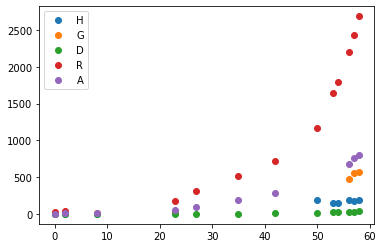

In [3]:
time = [0,2,8,23,27,35,42,50,53,54,56,57,58]
S = [141105] + [None]*(len(time)-1)
R = [54874] + [None]*(len(time)-1)
H = [0, 0, 0, 11, None, None, None, 189, 147, 147, 183, 176, 193]
G = [4, 7, 7, 37, None, None, None, None, None, None, 471, 558, 572]
D = [0, 0, 1, 1, 3, 3, 6, 16, 20, 22, 25, 32, 33]
cE = [28, 36, None, 169, 314, 513, 716, 1174, 1644, 1797, 2194, 2437, 2686]
cH = [4, 7, 8, 49, 91, 195, 290, None, None, None, 679, 766, 798]

plt.plot(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

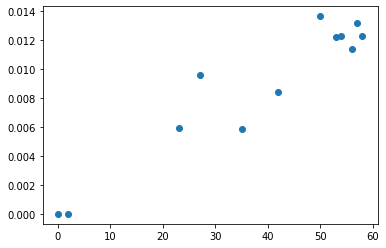

In [4]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [5]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
p0 = [1.5, 1/8, 0, 1/8, 1/8, 0.02]
config = {
    "grid_size": 59*2,
    "basis_number": 29,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        [1]*len(time)
    ],
    "regularisation_value": copy(p0),
}

In [6]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [7]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [8]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e1

In [9]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    30798
Number of nonzeros in Lagrangian Hessian.............:    19821

Total number of variables............................:      267
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

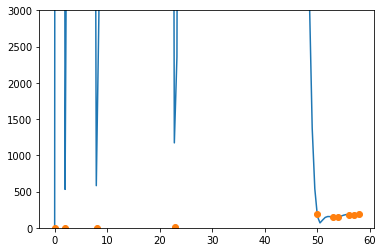

In [10]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [ ]:
prange = np.logspace(-6, 8, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': -1e-6,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    30798
Number of nonzeros in Lagrangian Hessian.............:    19821

Total number of variables............................:      267
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1062
        inequality constraints with only lower bounds:     1062
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  85  6.6270288e-04 0.00e+00 2.03e-06  -8.6 6.03e+02 -15.9 1.00e+00 1.00e+00h  1
  86  6.6265918e-04 0.00e+00 2.14e-05  -8.6 7.01e+04    -  7.67e-01 6.25e-02h  5
  87  6.6262489e-04 0.00e+00 3.66e-05  -8.6 2.49e+03 -16.4 1.00e+00 1.00e+00h  1
  88  6.6252126e-04 0.00e+00 9.97e-06  -8.6 3.27e+03 -16.8 1.00e+00 1.00e+00h  1
  89  6.6248407e-04 0.00e+00 7.86e-06  -8.6 1.43e+03 -16.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  6.6242901e-04 0.00e+00 7.85e-06  -8.6 2.34e+03 -16.9 1.00e+00 1.00e+00h  1
  91  6.6232973e-04 0.00e+00 1.17e-05  -8.6 5.65e+03 -17.4 1.00e+00 1.00e+00h  1
  92  6.6242928e-04 0.00e+00 6.98e-05  -8.6 8.50e+03 -17.0 1.00e+00 5.00e-01h  2
  93  6.6223901e-04 0.00e+00 2.42e-08  -8.6 6.62e+02 -16.5 1.00e+00 1.00e+00h  1
  94  6.8963045e-04 0.00e+00 8.83e-04  -9.0 2.46e+04    -  1.00e+00 1.00e+00h  1
  95  6.6176876e-04 0.00e+00 1.34e-05  -9.0 4.88e+02 -15.2 1.00e+00 1.00e+00h  1
  96  6.6156198e-04 0.00e+00

  45  1.1049023e-02 0.00e+00 2.82e-03  -5.7 1.41e+03 -12.4 1.00e+00 1.00e+00h  1
  46  1.0932315e-02 0.00e+00 4.93e-02  -5.7 6.58e+03 -12.9 1.00e+00 1.00e+00f  1
  47  1.0836787e-02 0.00e+00 2.57e-02  -5.7 3.44e+03 -12.5 1.00e+00 1.00e+00f  1
  48  1.0270062e-02 0.00e+00 2.41e-01  -5.7 3.00e+05 -12.9 5.57e-02 4.59e-02f  2
  49  9.0770295e-03 0.00e+00 2.05e-01  -5.7 2.00e+04 -12.5 1.25e-01 6.86e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  6.8221774e-03 0.00e+00 1.91e-02  -5.7 7.61e+02 -10.3 1.24e-02 9.31e-01f  1
  51  5.5456859e-03 0.00e+00 1.87e-02  -5.7 1.29e+03  -9.9 9.08e-02 3.09e-01f  1
  52  4.3834426e-03 0.00e+00 1.57e-02  -5.7 3.10e+03 -10.3 3.92e-02 1.60e-01f  1
  53  4.3367713e-03 0.00e+00 1.50e-02  -5.7 1.27e+06    -  1.17e-03 4.86e-02f  2
  54  3.1678404e-03 0.00e+00 1.24e-02  -5.7 6.68e+03 -10.8 3.13e-02 9.13e-02f  1
  55  1.9830373e-03 0.00e+00 9.37e-03  -5.7 2.13e+03 -11.3 8.83e-01 9.08e-01f  1
  56  1.7813048e-03 0.00e+00

  45  2.0826533e-01 0.00e+00 8.67e-01  -5.7 4.80e+03 -12.3 1.00e+00 1.00e+00f  1
  46  2.0402915e-01 0.00e+00 7.66e+00  -5.7 3.24e+04 -12.7 1.00e+00 1.88e-01f  3
  47  2.0130142e-01 0.00e+00 5.42e+00  -5.7 5.44e+03 -12.3 1.00e+00 3.18e-01f  1
  48  1.9403866e-01 0.00e+00 3.35e+00  -5.7 1.34e+04 -12.8 1.00e+00 1.00e+00f  1
  49  1.8796548e-01 0.00e+00 9.46e+00  -5.7 6.75e+03 -12.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.8641735e-01 0.00e+00 7.56e+00  -5.7 2.94e+03 -11.9 5.16e-01 2.07e-01f  1
  51  1.8062102e-01 0.00e+00 1.57e+00  -5.7 6.57e+03 -12.4 1.00e+00 1.00e+00f  1
  52  1.7689028e-01 0.00e+00 4.27e+00  -5.7 1.17e+04 -12.9 1.00e+00 5.00e-01f  2
  53  1.7243665e-01 0.00e+00 1.76e+00  -5.7 5.60e+03 -12.5 1.00e+00 1.00e+00f  1
  54  1.7010450e-01 0.00e+00 1.22e+00  -5.7 1.28e+05 -12.9 1.95e-01 6.97e-02f  1
  55  1.6906079e-01 0.00e+00 9.47e+00  -5.7 7.55e+03 -12.5 1.00e+00 1.00e+00f  1
  56  1.5907925e-01 0.00e+00

   2  3.7495774e-01 0.00e+00 8.62e-01  -1.0 2.72e+01    -  3.17e-01 1.00e+00f  1
   3  7.8667244e-01 0.00e+00 2.89e-02  -1.0 3.23e+01    -  8.88e-01 1.00e+00f  1
   4  7.6791167e-01 0.00e+00 5.63e-02  -1.0 1.31e+02    -  3.41e-01 1.00e+00f  1
   5  6.8059668e-01 0.00e+00 2.32e-02  -1.0 1.23e+02    -  5.47e-01 1.00e+00f  1
   6  5.1387655e-01 0.00e+00 3.33e-02  -1.0 1.76e+02    -  5.76e-01 1.00e+00f  1
   7  4.5753355e-01 0.00e+00 2.35e-02  -1.0 2.79e+02    -  5.05e-01 1.00e+00f  1
   8  4.9914565e-01 0.00e+00 1.07e-01  -1.0 6.65e+02    -  5.80e-01 1.00e+00f  1
   9  1.2571849e+00 0.00e+00 4.22e-01  -1.0 1.45e+03    -  6.11e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5064420e+00 0.00e+00 3.50e-01  -1.0 2.81e+03    -  7.20e-01 1.00e+00f  1
  11  9.1765798e+00 0.00e+00 6.68e+00  -1.0 6.61e+03    -  5.58e-01 6.69e-01f  1
  12  1.4205669e+01 0.00e+00 3.22e+01  -1.0 1.45e+04    -  9.07e-02 5.86e-01f  1
  13  1.4664824e+01 0.00e+00

  96  1.6038663e-02 0.00e+00 2.57e-01  -8.6 7.85e+03 -10.7 3.20e-03 4.13e-02f  4
  97  1.4452393e-02 0.00e+00 5.53e-02  -8.6 1.83e+03 -11.2 5.90e-01 1.00e+00f  1
  98  1.3943245e-02 0.00e+00 2.87e-02  -8.6 5.71e+03 -11.7 3.22e-01 7.01e-01f  1
  99  1.1752565e-02 0.00e+00 1.21e-02  -8.6 9.70e+02  -8.6 7.79e-02 2.54e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1015756e-02 0.00e+00 9.85e-03  -8.6 2.65e+02  -9.0 8.19e-01 1.87e-01f  1
 101  8.3326599e-03 0.00e+00 4.08e-03  -8.6 5.94e+02  -9.5 8.98e-01 6.30e-01f  1
 102  5.7498769e-03 0.00e+00 4.53e-03  -8.6 1.23e+03 -10.0 1.00e+00 5.59e-01f  1
 103  4.2855212e-03 0.00e+00 7.73e-03  -8.6 1.70e+03 -10.5 6.92e-02 1.00e+00f  1
 104  2.5247789e-03 0.00e+00 1.50e-03  -8.6 1.11e+02  -8.2 1.00e+00 1.00e+00f  1
 105  2.2743725e-03 0.00e+00 1.47e-04  -8.6 7.28e+01  -8.7 1.00e+00 1.00e+00f  1
 106  2.0723788e-03 0.00e+00 2.32e-04  -8.6 9.65e+01  -9.2 1.00e+00 1.00e+00f  1
 107  1.9052365e-03 0.00e+00

 191  1.7546064e-03 0.00e+00 3.04e-06  -9.0 2.55e+03 -17.9 1.00e+00 1.00e+00h  1
 192  1.7546075e-03 0.00e+00 1.57e-04  -9.0 9.10e+03 -18.4 1.00e+00 1.00e+00h  1
 193  1.7545950e-03 0.00e+00 7.53e-08  -9.0 2.87e+02 -17.1 1.00e+00 1.00e+00h  1
 194  1.7545907e-03 0.00e+00 4.40e-05  -9.0 7.22e+04    -  1.00e+00 6.25e-02h  5
 195  1.7545888e-03 0.00e+00 1.05e-06  -9.0 8.24e+02 -17.6 1.00e+00 1.00e+00h  1
 196  1.7545842e-03 0.00e+00 6.94e-05  -9.0 4.86e+04    -  1.00e+00 1.25e-01h  4
 197  1.7545800e-03 0.00e+00 2.01e-06  -9.0 1.58e+03 -18.0 1.00e+00 1.00e+00h  1
 198  1.7545753e-03 0.00e+00 3.45e-05  -9.0 3.75e+04    -  1.00e+00 1.25e-01h  4
 199  1.7545684e-03 0.00e+00 4.30e-06  -9.0 5.23e+03 -18.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.7546497e-03 0.00e+00 4.44e-04  -9.0 3.12e+04 -19.0 1.00e+00 5.00e-01h  2
 201  1.7545523e-03 0.00e+00 1.62e-07  -9.0 1.70e+02 -16.8 1.00e+00 1.00e+00h  1
 202  1.7545491e-03 0.00e+00

  47  2.2161986e-01 0.00e+00 7.45e+00  -5.7 4.05e+03 -11.9 1.00e+00 9.79e-01f  1
  48  2.1548630e-01 0.00e+00 4.63e+00  -5.7 4.89e+03 -12.4 1.00e+00 1.00e+00f  1
  49  2.1050010e-01 0.00e+00 9.14e+00  -5.7 1.24e+04 -12.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.0262580e-01 0.00e+00 4.86e+00  -5.7 3.26e+03 -12.4 1.00e+00 1.00e+00f  1
  51  1.9970131e-01 0.00e+00 2.89e+00  -5.7 2.12e+04 -12.9 6.32e-01 2.54e-01f  1
  52  1.9815875e-01 0.00e+00 1.39e+01  -5.7 5.94e+03 -12.5 1.00e+00 1.00e+00f  1
  53  1.9070472e-01 0.00e+00 5.30e-01  -5.7 2.58e+03 -12.0 1.00e+00 1.00e+00f  1
  54  1.8826994e-01 0.00e+00 7.51e+00  -5.7 1.64e+04 -12.5 1.00e+00 2.50e-01f  3
  55  1.8482396e-01 0.00e+00 1.55e+00  -5.7 2.85e+03 -12.1 1.00e+00 1.00e+00f  1
  56  1.8273866e-01 0.00e+00 4.64e+00  -5.7 6.13e+03 -12.6 1.00e+00 5.00e-01f  2
  57  1.8037417e-01 0.00e+00 1.86e+00  -5.7 2.57e+03 -12.1 1.00e+00 1.00e+00f  1
  58  1.7896954e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  2.4315191e-03 0.00e+00 3.85e-05  -8.6 5.66e+01 -14.5 1.00e+00 1.00e+00h  1
 141  2.4315157e-03 0.00e+00 5.17e-07  -8.6 1.41e+02 -15.0 1.00e+00 1.00e+00h  1
 142  2.4314576e-03 0.00e+00 1.88e-04  -8.6 5.30e+04    -  1.00e+00 6.25e-02h  5
 143  2.4314377e-03 0.00e+00 2.30e-06  -8.6 3.60e+02 -15.5 1.00e+00 1.00e+00h  1
 144  2.4312627e-03 0.00e+00 8.56e-04  -8.6 5.67e+04    -  1.00e+00 5.00e-01h  2
 145  2.4309846e-03 0.00e+00 9.49e-07  -8.6 1.32e+02 -15.0 1.00e+00 1.00e+00h  1
 146  2.4309446e-03 0.00e+00 1.52e-04  -8.6 5.67e+04    -  1.00e+00 6.25e-02h  5
 147  2.4309328e-03 0.00e+00 7.60e-07  -8.6 2.58e+02 -15.5 1.00e+00 1.00e+00h  1
 148  2.4309088e-03 0.00e+00 2.63e-04  -8.6 6.13e+04    -  1.00e+00 6.25e-02h  5
 149  2.4308768e-03 0.00e+00 3.64e-06  -8.6 5.95e+02 -16.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  2.4309791e-03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1025379e+00 0.00e+00 9.77e-01  -1.0 2.52e+03    -  8.27e-01 1.00e+00f  1
  11  5.9531630e+00 0.00e+00 5.00e+00  -1.0 8.35e+03    -  4.41e-01 2.59e-01f  1
  12  8.4130281e+00 0.00e+00 7.53e+00  -1.0 1.66e+04    -  4.44e-02 3.14e-01f  1
  13  1.0877883e+01 0.00e+00 1.25e+01  -1.0 1.72e+04    -  4.78e-01 3.04e-01f  1
  14  1.4382748e+01 0.00e+00 4.70e+01  -1.0 3.91e+04    -  5.60e-02 3.30e-01f  1
  15  1.4022468e+01 0.00e+00 7.29e+01  -1.0 7.01e-01  -4.0 1.00e+00 5.00e-01f  2
  16  1.6278776e+01 0.00e+00 3.28e+01  -1.0 1.02e+06    -  7.14e-01 3.51e-01f  1
  17  1.7441620e+01 0.00e+00 5.23e+01  -1.0 2.12e+05    -  3.73e-02 1.19e-01f  2
  18  1.6515517e+01 0.00e+00 8.34e-04  -1.0 4.54e-01  -4.5 1.00e+00 1.00e+00f  1
  19  5.8746075e+00 0.00e+00 2.78e+00  -2.5 4.66e+03    -  8.78e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.1767154e+00 0.00e+00

 105  6.0777924e-03 0.00e+00 2.18e-02  -8.6 9.35e+02  -9.9 1.00e+00 9.32e-01f  1
 106  5.2161927e-03 0.00e+00 3.78e-02  -8.6 8.37e+02 -10.4 4.41e-01 1.00e+00f  1
 107  4.0054478e-03 0.00e+00 4.73e-02  -8.6 4.01e+03 -10.9 7.62e-02 7.16e-02f  1
 108  3.9610384e-03 0.00e+00 4.60e-02  -8.6 2.16e+03 -11.4 7.69e-03 3.02e-02f  1
 109  3.5991378e-03 0.00e+00 2.88e-02  -8.6 1.59e+02 -11.8 1.00e+00 3.79e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.3911078e-03 0.00e+00 8.49e-03  -8.6 1.22e+02 -12.3 1.00e+00 7.17e-01f  1
 111  3.3688238e-03 0.00e+00 4.22e-04  -8.6 3.55e+01 -12.8 1.00e+00 1.00e+00f  1
 112  3.3677372e-03 0.00e+00 9.27e-05  -8.6 9.10e+00 -13.3 6.66e-01 1.00e+00h  1
 113  3.3676295e-03 0.00e+00 1.66e-07  -8.6 1.77e+01 -13.7 1.00e+00 1.00e+00h  1
 114  3.4677167e-03 0.00e+00 1.98e-02  -8.6 4.63e+04    -  1.00e+00 5.00e-01h  2
 115  3.3672697e-03 0.00e+00 2.49e-04  -8.6 6.75e+02 -14.2 1.00e+00 1.00e+00f  1
 116  3.3667234e-03 0.00e+00

 203  3.3641942e-03 0.00e+00 2.74e-06  -8.6 6.41e+02 -16.4 1.00e+00 1.00e+00h  1
 204  3.3641876e-03 0.00e+00 2.48e-05  -8.6 1.75e+05    -  1.00e+00 1.56e-02h  7
 205  3.3641870e-03 0.00e+00 1.11e-07  -8.6 1.74e+02 -16.9 1.00e+00 1.00e+00h  1
 206  3.3641794e-03 0.00e+00 3.30e-05  -8.6 2.57e+04    -  1.00e+00 1.25e-01h  4
 207  3.3641781e-03 0.00e+00 6.28e-07  -8.6 4.11e+02 -17.3 1.00e+00 1.00e+00h  1
 208  3.3641672e-03 0.00e+00 8.19e-05  -8.6 2.10e+04    -  1.00e+00 2.50e-01h  3
 209  3.3641641e-03 0.00e+00 9.97e-07  -8.6 5.81e+02 -17.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  3.3641552e-03 0.00e+00 4.21e-05  -8.6 1.58e+04    -  1.00e+00 2.50e-01h  3
 211  3.3641519e-03 0.00e+00 2.79e-06  -8.6 1.19e+03 -18.3 1.00e+00 1.00e+00h  1
 212  3.3641416e-03 0.00e+00 5.55e-05  -8.6 9.60e+03    -  1.00e+00 5.00e-01h  2
 213  3.3641401e-03 0.00e+00 3.49e-07  -8.6 3.04e+02 -17.9 1.00e+00 1.00e+00h  1
 214  3.3641314e-03 0.00e+00

  49  2.2300692e-01 0.00e+00 1.23e+00  -3.8 7.37e+04    -  5.86e-01 9.90e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.1998624e-01 0.00e+00 1.59e+00  -3.8 2.45e+03 -11.1 1.00e+00 1.00e+00f  1
  51  2.1848516e-01 0.00e+00 1.10e+00  -3.8 2.88e+03 -11.6 1.00e+00 1.00e+00f  1
  52  2.1711901e-01 0.00e+00 1.16e+00  -3.8 2.97e+03 -12.0 1.00e+00 1.00e+00f  1
  53  2.1683863e-01 0.00e+00 2.85e-01  -3.8 1.86e+03 -11.6 1.00e+00 1.00e+00f  1
  54  2.1653118e-01 0.00e+00 1.23e+00  -3.8 4.12e+03 -12.1 1.00e+00 1.00e+00f  1
  55  2.1666006e-01 0.00e+00 1.39e-01  -3.8 1.52e+03 -11.7 1.00e+00 1.00e+00f  1
  56  2.1648413e-01 0.00e+00 9.98e-01  -3.8 4.21e+03 -12.1 1.00e+00 1.00e+00f  1
  57  2.1710129e-01 0.00e+00 7.91e-01  -3.8 3.28e+04 -12.6 1.00e+00 7.82e-02f  4
  58  2.1690703e-01 0.00e+00 7.22e-02  -3.8 7.24e+02 -11.3 1.00e+00 1.00e+00f  1
  59  2.1794189e-01 0.00e+00 3.75e+00  -3.8 5.29e+04    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr 

 141  4.1702250e-02 0.00e+00 3.55e+00  -8.6 5.29e+04 -15.3 1.00e+00 1.00e+00H  1
 142  4.0284354e-02 0.00e+00 5.70e-03  -8.6 5.77e+01 -10.4 1.00e+00 1.00e+00f  1
 143  4.0277833e-02 0.00e+00 5.71e-04  -8.6 9.94e+01 -10.9 1.00e+00 1.00e+00h  1
 144  4.0276797e-02 0.00e+00 5.40e-04  -8.6 6.90e+01 -11.3 1.00e+00 1.00e+00h  1
 145  4.0276511e-02 0.00e+00 4.07e-04  -8.6 9.74e+01 -11.8 1.00e+00 1.00e+00h  1
 146  4.0275712e-02 0.00e+00 7.12e-05  -8.6 2.75e+02 -12.3 1.00e+00 1.00e+00h  1
 147  4.0273135e-02 0.00e+00 6.91e-04  -8.6 8.62e+02 -12.8 1.00e+00 1.00e+00h  1
 148  4.0263263e-02 0.00e+00 8.27e-03  -8.6 2.99e+03 -13.2 1.00e+00 1.00e+00h  1
 149  4.0217343e-02 0.00e+00 1.88e-01  -8.6 1.67e+04 -13.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  4.0065796e-02 0.00e+00 2.51e-01  -8.6 1.48e+04 -14.2 1.00e+00 1.00e+00f  1
 151  3.9864229e-02 0.00e+00 1.85e-01  -8.6 8.61e+02 -12.0 6.44e-01 2.85e-01f  1
 152  3.9616727e-02 0.00e+00

Number of inequality constraint Jacobian evaluations = 240
Number of Lagrangian Hessian evaluations             = 239
Total CPU secs in IPOPT (w/o function evaluations)   =      1.912
Total CPU secs in NLP function evaluations           =     32.926

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 184.97ms (278.57us) 185.31ms (279.09us)       664
       nlp_g  |  29.78ms ( 44.85us)  29.60ms ( 44.57us)       664
    nlp_grad  | 926.00us (926.00us) 924.88us (924.88us)         1
  nlp_grad_f  | 211.41ms (877.22us) 211.83ms (878.98us)       241
  nlp_hess_l  |  32.48 s (135.89ms)  32.55 s (136.21ms)       239
   nlp_jac_g  |  69.81ms (289.67us)  70.04ms (290.63us)       241
       total  |  34.91 s ( 34.91 s)  34.98 s ( 34.98 s)         1
Solving for p=9.770099572992246e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of no

  76  6.6139987e-03 0.00e+00 7.71e-03  -5.7 2.03e+04    -  1.00e+00 5.00e-01h  2
  77  6.6065580e-03 0.00e+00 8.32e-05  -5.7 3.30e+03 -15.4 1.00e+00 1.00e+00h  1
  78  6.6112250e-03 0.00e+00 5.83e-03  -5.7 1.71e+04    -  1.00e+00 5.00e-01h  2
  79  6.6063763e-03 0.00e+00 1.22e-05  -5.7 2.15e+02 -14.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  6.4757983e-03 0.00e+00 1.04e-03  -8.6 3.66e+03    -  9.26e-01 1.00e+00f  1
  81  6.4580486e-03 0.00e+00 3.60e-05  -8.6 8.44e+02 -15.4 8.80e-01 1.00e+00h  1
  82  6.4576072e-03 0.00e+00 1.78e-03  -8.6 8.72e+04    -  5.69e-01 1.14e-01h  4
  83  6.4544005e-03 0.00e+00 3.50e-04  -8.6 6.82e+02 -15.0 9.89e-01 7.90e-01h  1
  84  6.4535060e-03 0.00e+00 1.25e-04  -8.6 1.44e+03 -15.5 1.00e+00 1.00e+00f  1
  85  6.4532383e-03 0.00e+00 3.07e-04  -8.6 2.69e+03 -15.9 1.00e+00 1.00e+00h  1
  86  6.4529264e-03 0.00e+00 5.97e-05  -8.6 5.14e+03 -16.4 1.00e+00 1.00e+00h  1
  87  6.4529060e-03 0.00e+00

 176  6.4480501e-03 0.00e+00 2.44e-04  -8.6 6.64e+03 -18.3 1.00e+00 1.00e+00h  1
 177  6.4480409e-03 0.00e+00 7.94e-07  -8.6 4.21e+02 -17.0 1.00e+00 1.00e+00h  1
 178  6.4480306e-03 0.00e+00 7.07e-05  -8.6 5.97e+04    -  1.00e+00 6.25e-02h  5
 179  6.4480264e-03 0.00e+00 7.28e-06  -8.6 1.21e+03 -17.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  6.4480153e-03 0.00e+00 7.68e-05  -8.6 3.26e+04    -  1.00e+00 1.25e-01h  4
 181  6.4480080e-03 0.00e+00 2.54e-05  -8.6 2.30e+03 -17.9 1.00e+00 1.00e+00h  1
 182  6.4479946e-03 0.00e+00 1.82e-04  -8.6 6.29e+03 -18.4 1.00e+00 1.00e+00h  1
 183  6.4479891e-03 0.00e+00 6.81e-07  -8.6 4.06e+02 -17.1 1.00e+00 1.00e+00h  1
 184  6.4582082e-03 0.00e+00 8.78e-03  -8.6 4.86e+04    -  1.00e+00 1.00e+00H  1
 185  6.4478677e-03 0.00e+00 2.48e-05  -8.6 1.17e+03 -15.8 1.00e+00 1.00e+00h  1
 186  6.4478636e-03 0.00e+00 3.70e-07  -8.6 1.31e+01 -16.2 1.00e+00 1.00e+00h  1
 187  6.4478360e-03 0.00e+00

  59  6.8708261e-02 0.00e+00 2.15e-01  -5.7 1.87e+03 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  6.5635082e-02 0.00e+00 2.48e-01  -5.7 2.22e+03 -11.0 7.35e-01 1.00e+00f  1
  61  5.4023341e-02 0.00e+00 1.72e-01  -5.7 4.16e+02  -8.7 1.00e+00 1.00e+00f  1
  62  4.5075581e-02 0.00e+00 1.35e-02  -5.7 2.53e+02  -8.3 1.00e+00 1.00e+00f  1
  63  3.5368891e-02 0.00e+00 7.84e-02  -5.7 6.96e+02  -8.8 1.00e+00 1.00e+00f  1
  64  2.0605303e-02 0.00e+00 2.43e-02  -5.7 7.59e+02  -9.3 1.00e+00 1.00e+00f  1
  65  1.4962085e-02 0.00e+00 1.07e-01  -5.7 1.12e+03  -9.7 7.58e-01 5.35e-01f  1
  66  1.1084906e-02 0.00e+00 3.25e-02  -5.7 9.32e+02 -10.2 7.61e-03 1.00e+00f  1
  67  1.0403153e-02 0.00e+00 2.17e-02  -5.7 4.96e+01  -8.0 1.00e+00 3.28e-01f  1
  68  9.4398210e-03 0.00e+00 1.10e-02  -5.7 7.66e+01  -8.5 1.00e+00 1.00e+00f  1
  69  9.2318287e-03 0.00e+00 4.76e-04  -5.7 6.45e+01  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 153  8.9253462e-03 0.00e+00 3.38e-07  -9.0 4.24e+03 -17.7 1.00e+00 1.00e+00h  1
 154  8.9253414e-03 0.00e+00 2.97e-04  -9.0 5.53e+05    -  1.00e+00 1.99e-02h  6
 155  8.9253273e-03 0.00e+00 8.40e-06  -9.0 1.84e+03 -17.2 1.00e+00 1.00e+00h  1
 156  8.9253095e-03 0.00e+00 1.52e-04  -9.0 6.83e+03 -17.7 1.00e+00 1.00e+00h  1
 157  8.9252670e-03 0.00e+00 2.07e-04  -9.0 1.45e+04 -18.2 1.00e+00 1.00e+00h  1
 158  8.9252584e-03 0.00e+00 5.52e-04  -9.0 2.09e+05 -17.8 1.00e+00 6.25e-02h  5
 159  8.9252238e-03 0.00e+00 4.58e-06  -9.0 1.66e+03 -17.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  8.9252257e-03 0.00e+00 4.26e-04  -9.0 2.07e+05    -  1.00e+00 6.25e-02h  5
 161  8.9251900e-03 0.00e+00 6.58e-05  -9.0 6.62e+03 -17.8 1.00e+00 1.00e+00h  1
 162  8.9251762e-03 0.00e+00 3.26e-04  -9.0 1.56e+05 -18.3 1.00e+00 6.25e-02h  5
 163  8.9251521e-03 0.00e+00 5.22e-06  -9.0 5.23e+03 -17.9 1.00e+00 1.00e+00h  1
 164  8.9251399e-03 0.00e+00

   2  2.8323959e-01 0.00e+00 1.11e+00  -1.0 5.46e+01    -  3.47e-01 1.00e+00f  1
   3  6.2422572e-01 0.00e+00 8.18e-02  -1.0 5.28e+01    -  7.59e-01 1.00e+00f  1
   4  1.0669528e+00 0.00e+00 4.37e-02  -1.0 1.26e+02    -  6.51e-01 1.00e+00f  1
   5  6.7354845e-01 0.00e+00 5.36e-02  -1.0 2.15e+02    -  4.87e-01 1.00e+00f  1
   6  5.7542150e-01 0.00e+00 3.64e-02  -1.0 2.83e+02    -  5.24e-01 1.00e+00f  1
   7  5.7609444e-01 0.00e+00 3.79e-02  -1.0 5.05e+02    -  5.63e-01 1.00e+00f  1
   8  7.5972692e-01 0.00e+00 1.67e-01  -1.0 1.14e+03    -  4.70e-01 1.00e+00f  1
   9  1.7971694e+00 0.00e+00 4.90e-01  -1.0 1.94e+03    -  6.06e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.3239451e+00 0.00e+00 1.97e+00  -1.0 4.36e+03    -  7.39e-01 1.00e+00f  1
  11  1.3267769e+01 0.00e+00 1.22e+01  -1.0 1.64e+04    -  5.48e-01 1.00e+00f  1
  12  1.7365991e+01 0.00e+00 4.19e+01  -1.0 3.16e+04    -  6.25e-01 5.39e-01f  1
  13  1.6845625e+01 0.00e+00

  99  1.2518797e-02 0.00e+00 2.04e-02  -5.7 2.66e+04    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2489841e-02 0.00e+00 2.02e-05  -5.7 1.31e+02 -14.4 1.00e+00 1.00e+00h  1
 101  1.2668402e-02 0.00e+00 5.03e-02  -5.7 1.74e+04    -  1.00e+00 1.00e+00H  1
 102  1.2492728e-02 0.00e+00 4.59e-04  -5.7 8.41e+02 -14.0 1.00e+00 1.00e+00f  1
 103  1.2491606e-02 0.00e+00 1.92e-05  -5.7 1.32e+02 -14.4 1.00e+00 1.00e+00h  1
 104  1.2491238e-02 0.00e+00 5.52e-04  -5.7 2.70e+03    -  1.00e+00 1.00e+00h  1
 105  1.2491203e-02 0.00e+00 3.34e-07  -5.7 6.63e+01    -  1.00e+00 1.00e+00h  1
 106  1.2385171e-02 0.00e+00 5.08e-03  -8.6 6.66e+03    -  9.42e-01 1.00e+00f  1
 107  1.2368483e-02 0.00e+00 2.46e-05  -8.6 4.62e+02 -14.9 8.29e-01 1.00e+00h  1
 108  1.2599884e-02 0.00e+00 5.81e-02  -8.6 5.33e+04    -  9.33e-01 5.94e-01H  1
 109  1.2599884e-02 0.00e+00 5.81e-02  -8.6 1.08e+04 -14.5 9.21e-01 5.68e-14h 45
iter    objective    inf_pr 

 195  1.2353577e-02 0.00e+00 8.77e-06  -8.6 1.30e+03 -16.9 1.00e+00 1.00e+00h  1
 196  1.2353553e-02 0.00e+00 2.82e-04  -8.6 9.23e+04    -  1.00e+00 6.25e-02h  5
 197  1.2353530e-02 0.00e+00 3.78e-05  -8.6 3.15e+03 -17.3 1.00e+00 1.00e+00h  1
 198  1.2353501e-02 0.00e+00 5.93e-04  -8.6 1.03e+04 -17.8 1.00e+00 1.00e+00h  1
 199  1.2353458e-02 0.00e+00 8.11e-06  -8.6 3.48e+03 -17.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2353443e-02 0.00e+00 3.47e-04  -8.6 4.63e+07    -  1.56e-02 1.48e-04h  6
 201  1.2353428e-02 0.00e+00 8.46e-06  -8.6 1.32e+03 -17.0 1.00e+00 1.00e+00h  1
 202  1.2353406e-02 0.00e+00 2.42e-04  -8.6 8.77e+04    -  1.00e+00 6.25e-02h  5
 203  1.2353387e-02 0.00e+00 4.05e-05  -8.6 3.27e+03 -17.4 1.00e+00 1.00e+00h  1
 204  1.2353360e-02 0.00e+00 5.50e-04  -8.6 1.03e+04 -17.9 1.00e+00 1.00e+00h  1
 205  1.2353318e-02 0.00e+00 2.89e-05  -8.6 4.18e+03 -17.5 1.00e+00 1.00e+00h  1
 206  1.2353295e-02 0.00e+00

  21  1.5365250e+00 0.00e+00 1.18e-02  -2.5 7.98e+00  -5.4 1.00e+00 1.00e+00f  1
  22  4.8684833e-01 0.00e+00 2.21e+01  -3.8 3.82e+03    -  6.42e-01 1.00e+00f  1
  23  4.7586340e-01 0.00e+00 1.42e-02  -3.8 9.30e+00  -5.9 1.00e+00 1.00e+00f  1
  24  4.6357003e-01 0.00e+00 1.90e-04  -3.8 2.07e+01  -6.4 1.00e+00 1.00e+00f  1
  25  4.4058013e-01 0.00e+00 2.24e-01  -5.7 4.80e+01  -6.9 7.68e-01 1.00e+00f  1
  26  4.1646148e-01 0.00e+00 3.82e-02  -5.7 6.21e+01  -7.3 8.96e-01 1.00e+00f  1
  27  3.9610781e-01 0.00e+00 3.56e-03  -5.7 9.03e+01  -7.8 9.39e-01 1.00e+00f  1
  28  3.8324622e-01 0.00e+00 5.81e-03  -5.7 1.68e+02  -8.3 9.11e-01 1.00e+00f  1
  29  3.7779302e-01 0.00e+00 8.71e-03  -5.7 1.87e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.7643234e-01 0.00e+00 3.99e-03  -5.7 1.12e+02  -9.2 1.00e+00 1.00e+00f  1
  31  3.7570944e-01 0.00e+00 6.41e-03  -5.7 1.86e+02  -9.7 1.00e+00 1.00e+00f  1
  32  3.7419237e-01 0.00e+00

 116  1.3530976e-01 0.00e+00 2.54e-01  -5.7 1.71e+04 -11.0 1.92e-01 8.70e-02f  3
 117  1.3432566e-01 0.00e+00 3.70e-01  -5.7 5.94e+03 -11.4 1.00e+00 5.00e-01f  2
 118  1.3066715e-01 0.00e+00 7.62e-02  -5.7 3.51e+02 -10.1 1.00e+00 1.00e+00f  1
 119  1.2607457e-01 0.00e+00 2.54e-01  -5.7 1.26e+03  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.1799622e-01 0.00e+00 4.43e-01  -5.7 7.48e+03 -10.2 2.49e-01 2.00e-01f  2
 121  1.0385745e-01 0.00e+00 1.60e-01  -5.7 1.93e+03 -10.6 1.00e+00 5.45e-01f  1
 122  8.8591039e-02 0.00e+00 8.46e-02  -5.7 2.96e+02  -8.4 1.00e+00 1.00e+00f  1
 123  6.9233635e-02 0.00e+00 2.23e-01  -5.7 8.55e+02  -8.9 5.25e-01 1.00e+00f  1
 124  4.1460585e-02 0.00e+00 1.33e-01  -5.7 6.00e+02  -9.4 1.00e+00 1.00e+00f  1
 125  3.0604149e-02 0.00e+00 2.45e-01  -5.7 9.12e+02  -9.8 6.50e-01 4.98e-01f  1
 126  2.3523791e-02 0.00e+00 7.83e-02  -5.7 3.07e+02 -10.3 5.16e-01 1.00e+00f  1
 127  1.9103175e-02 0.00e+00

 212  1.7095649e-02 0.00e+00 2.19e-04  -8.6 4.79e+03 -16.9 1.00e+00 1.00e+00h  1
 213  1.7095524e-02 0.00e+00 2.22e-04  -8.6 1.04e+04 -17.4 1.00e+00 1.00e+00h  1
 214  1.7095445e-02 0.00e+00 7.04e-04  -8.6 9.55e+04 -17.8 1.00e+00 1.25e-01h  4
 215  1.7095391e-02 0.00e+00 1.04e-04  -8.6 2.83e+03 -16.5 1.00e+00 1.00e+00h  1
 216  1.7095339e-02 0.00e+00 2.05e-04  -8.6 4.93e+03 -17.0 1.00e+00 1.00e+00h  1
 217  1.7095223e-02 0.00e+00 2.72e-04  -8.6 1.09e+04 -17.5 1.00e+00 1.00e+00h  1
 218  1.7095175e-02 0.00e+00 1.20e-04  -8.6 4.45e+03 -17.0 1.00e+00 1.00e+00h  1
 219  1.7095084e-02 0.00e+00 7.28e-04  -8.6 1.19e+04 -17.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.7095016e-02 0.00e+00 2.40e-06  -8.6 4.15e+03 -17.1 1.00e+00 1.00e+00h  1
 221  1.7095000e-02 0.00e+00 7.48e-04  -8.6 3.66e+05    -  1.00e+00 2.21e-02h  6
 222  1.7094957e-02 0.00e+00 1.41e-05  -8.6 1.66e+03 -16.7 1.00e+00 1.00e+00h  1
 223  1.7094904e-02 0.00e+00

   1  1.4001824e-01 0.00e+00 2.93e-01  -1.0 2.07e+01    -  7.72e-01 1.00e+00f  1
   2  2.9725810e-01 0.00e+00 1.10e+00  -1.0 4.94e+01    -  3.37e-01 1.00e+00f  1
   3  6.5131040e-01 0.00e+00 6.78e-02  -1.0 4.63e+01    -  7.85e-01 1.00e+00f  1
   4  1.0599079e+00 0.00e+00 4.71e-02  -1.0 1.18e+02    -  6.09e-01 1.00e+00f  1
   5  6.9165890e-01 0.00e+00 4.25e-02  -1.0 1.75e+02    -  5.15e-01 1.00e+00f  1
   6  5.7844240e-01 0.00e+00 3.60e-02  -1.0 2.55e+02    -  5.05e-01 1.00e+00f  1
   7  6.7126951e-01 0.00e+00 5.07e-02  -1.0 4.91e+02    -  5.40e-01 1.00e+00f  1
   8  1.1360515e+00 0.00e+00 3.00e-01  -1.0 1.02e+03    -  5.37e-01 1.00e+00f  1
   9  3.1542271e+00 0.00e+00 1.20e+00  -1.0 1.88e+03    -  6.03e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.7849573e+00 0.00e+00 2.73e+00  -1.0 4.19e+03    -  7.39e-01 1.00e+00f  1
  11  1.6596301e+01 0.00e+00 3.90e+01  -1.0 1.37e+04    -  6.35e-01 9.43e-01f  1
  12  2.0987175e+01 0.00e+00

 102  2.3657542e-02 0.00e+00 4.24e-04  -8.6 2.97e+03 -15.9 1.00e+00 1.00e+00h  1
 103  2.3657167e-02 0.00e+00 9.24e-04  -8.6 6.45e+03 -16.4 1.00e+00 1.00e+00h  1
 104  2.3656989e-02 0.00e+00 1.64e-04  -8.6 2.49e+03 -15.9 1.00e+00 1.00e+00h  1
 105  2.3656708e-02 0.00e+00 2.05e-03  -8.6 7.69e+03 -16.4 1.00e+00 1.00e+00h  1
 106  2.3656426e-02 0.00e+00 6.25e-06  -8.6 2.32e+03 -16.0 1.00e+00 1.00e+00h  1
 107  2.3656712e-02 0.00e+00 5.29e-03  -8.6 1.28e+05    -  1.00e+00 1.25e-01h  4
 108  2.3655681e-02 0.00e+00 3.33e-06  -8.6 1.66e+02 -14.7 1.00e+00 1.00e+00h  1
 109  2.3655324e-02 0.00e+00 2.98e-03  -8.6 1.16e+05    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.3654982e-02 0.00e+00 1.05e-05  -8.6 4.44e+02 -15.1 1.00e+00 1.00e+00h  1
 111  2.3654855e-02 0.00e+00 1.42e-03  -8.6 3.22e+05    -  6.02e-01 3.12e-02h  6
 112  2.3654727e-02 0.00e+00 7.99e-05  -8.6 1.35e+03 -15.6 1.00e+00 1.00e+00h  1
 113  2.3654612e-02 0.00e+00

 196  2.3647171e-02 0.00e+00 2.08e-06  -8.6 3.43e+02 -16.3 1.00e+00 1.00e+00h  1
 197  2.3647137e-02 0.00e+00 4.51e-04  -8.6 1.57e+05    -  1.00e+00 6.25e-02h  5
 198  2.3647127e-02 0.00e+00 1.45e-06  -8.6 6.23e+02 -16.7 1.00e+00 1.00e+00h  1
 199  2.3647095e-02 0.00e+00 5.12e-04  -8.6 1.66e+05    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.3647079e-02 0.00e+00 7.13e-06  -8.6 1.57e+03 -17.2 1.00e+00 1.00e+00h  1
 201  2.3647395e-02 0.00e+00 3.51e-03  -8.6 1.36e+05    -  1.00e+00 2.50e-01h  3
 202  2.3646943e-02 0.00e+00 1.75e-06  -8.6 4.70e+02 -16.8 1.00e+00 1.00e+00h  1
 203  2.3646913e-02 0.00e+00 5.20e-04  -8.6 1.76e+05    -  1.00e+00 6.25e-02h  5
 204  2.3646898e-02 0.00e+00 4.67e-06  -8.6 1.31e+03 -17.3 1.00e+00 1.00e+00h  1
 205  2.3646858e-02 0.00e+00 6.94e-04  -8.6 1.25e+05    -  1.00e+00 1.25e-01h  4
 206  2.3646804e-02 0.00e+00 1.28e-04  -8.6 8.10e+04 -17.8 1.00e+00 1.25e-01h  4
 207  2.3646779e-02 0.00e+00

  11  3.1933981e+01 0.00e+00 1.77e+02  -1.0 2.98e+04    -  5.82e-01 1.00e+00f  1
  12  1.7677337e+01 0.00e+00 1.36e-01  -1.0 1.73e+00  -4.0 9.92e-01 1.00e+00f  1
  13  7.3418939e+00 0.00e+00 1.56e+01  -1.7 1.08e+06    -  7.55e-01 1.00e+00f  1
  14  5.8798916e+00 0.00e+00 4.47e+01  -1.7 5.20e+05    -  4.13e-01 1.00e+00f  1
  15  5.1721283e+00 0.00e+00 3.29e-03  -1.7 1.44e+00  -4.5 1.00e+00 1.00e+00f  1
  16  1.3559328e+00 0.00e+00 2.67e+00  -3.8 5.27e+03    -  7.45e-01 1.00e+00f  1
  17  6.8214127e-01 0.00e+00 2.35e+00  -3.8 2.87e+03    -  6.72e-01 1.00e+00f  1
  18  6.7088581e-01 0.00e+00 3.01e-03  -3.8 3.26e+00  -5.0 1.00e+00 1.00e+00f  1
  19  6.5916095e-01 0.00e+00 1.49e-04  -3.8 8.78e+00  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.3555190e-01 0.00e+00 1.04e-01  -5.7 2.18e+01  -5.9 6.72e-01 9.28e-01f  1
  21  6.0611960e-01 0.00e+00 1.91e-02  -5.7 4.22e+01  -6.4 8.45e-01 6.42e-01f  1
  22  5.5213131e-01 0.00e+00

 107  3.2706659e-02 0.00e+00 1.95e-04  -8.6 4.51e+03 -16.8 1.00e+00 1.00e+00h  1
 108  3.2706537e-02 0.00e+00 7.19e-04  -8.6 1.09e+04 -17.3 1.00e+00 1.00e+00h  1
 109  3.2706476e-02 0.00e+00 6.96e-05  -8.6 3.91e+03 -16.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.2706374e-02 0.00e+00 1.30e-03  -8.6 1.27e+04 -17.4 1.00e+00 1.00e+00h  1
 111  3.2706283e-02 0.00e+00 2.06e-06  -8.6 3.98e+03 -16.9 1.00e+00 1.00e+00h  1
 112  3.2706261e-02 0.00e+00 1.36e-03  -8.6 3.63e+05    -  1.00e+00 2.46e-02h  6
 113  3.2706195e-02 0.00e+00 1.23e-05  -8.6 1.56e+03 -16.5 1.00e+00 1.00e+00h  1
 114  3.2705683e-02 0.00e+00 4.41e-03  -8.6 2.12e+05    -  1.00e+00 5.00e-01h  2
 115  3.2705158e-02 0.00e+00 8.24e-06  -8.6 6.93e+02 -16.1 1.00e+00 1.00e+00h  1
 116  3.2705133e-02 0.00e+00 1.44e-03  -8.6 1.74e+05    -  1.00e+00 6.25e-02h  5
 117  3.2705069e-02 0.00e+00 6.14e-06  -8.6 1.06e+03 -16.6 1.00e+00 1.00e+00h  1
 118  3.2705039e-02 0.00e+00

   2  3.1157719e-01 0.00e+00 1.19e+00  -1.0 5.53e+01    -  3.26e-01 1.00e+00f  1
   3  6.6333523e-01 0.00e+00 9.76e-02  -1.0 5.06e+01    -  7.33e-01 1.00e+00f  1
   4  1.0758571e+00 0.00e+00 3.38e-02  -1.0 1.09e+02    -  6.70e-01 1.00e+00f  1
   5  6.9273069e-01 0.00e+00 5.42e-02  -1.0 1.94e+02    -  4.85e-01 1.00e+00f  1
   6  6.3176470e-01 0.00e+00 3.61e-02  -1.0 3.02e+02    -  5.24e-01 1.00e+00f  1
   7  7.7772968e-01 0.00e+00 7.19e-02  -1.0 6.05e+02    -  5.74e-01 1.00e+00f  1
   8  1.6467326e+00 0.00e+00 5.62e-01  -1.0 1.29e+03    -  4.80e-01 1.00e+00f  1
   9  4.1881457e+00 0.00e+00 1.72e+00  -1.0 2.09e+03    -  7.06e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0374619e+01 0.00e+00 1.03e+01  -1.0 6.44e+03    -  7.09e-01 1.00e+00f  1
  11  2.6490648e+01 0.00e+00 2.07e+02  -1.0 2.41e+04    -  5.47e-01 8.28e-01f  1
  12  1.7377477e+01 0.00e+00 1.53e-01  -1.0 1.69e+00  -4.0 9.93e-01 1.00e+00f  1
  13  7.3442538e+00 0.00e+00

  98  5.0427467e-01 0.00e+00 9.29e+00  -3.8 1.85e+03 -12.3 1.00e+00 5.00e-01f  2
  99  5.0405460e-01 0.00e+00 7.61e+00  -3.8 1.02e+05 -12.7 1.00e+00 3.93e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0364345e-01 0.00e+00 1.36e+00  -3.8 1.23e+03 -12.3 1.00e+00 1.00e+00f  1
 101  5.0312558e-01 0.00e+00 4.50e+00  -3.8 1.39e+03 -11.9 1.00e+00 5.00e-01f  2
 102  5.0270499e-01 0.00e+00 1.35e+01  -3.8 3.36e+03 -12.4 1.00e+00 1.00e+00f  1
 103  5.0235159e-01 0.00e+00 4.09e-01  -3.8 2.03e+02 -11.0 1.00e+00 1.00e+00f  1
 104  5.0210403e-01 0.00e+00 7.78e+00  -3.8 4.63e+04    -  1.00e+00 6.25e-02f  5
 105  5.0155637e-01 0.00e+00 6.19e+00  -3.8 8.40e+02 -11.5 1.00e+00 1.00e+00f  1
 106  5.0119085e-01 0.00e+00 2.26e+00  -3.8 1.33e+03 -12.0 1.00e+00 1.00e+00f  1
 107  5.0091201e-01 0.00e+00 3.20e+00  -3.8 5.40e+03 -12.5 1.00e+00 1.25e-01f  4
 108  5.0071057e-01 0.00e+00 4.25e+00  -3.8 4.37e+03 -12.9 1.00e+00 5.00e-01f  2
 109  5.0038537e-01 0.00e+00

 202  4.7155301e-01 0.00e+00 5.00e-01  -5.7 9.30e+02 -12.3 1.00e+00 1.00e+00h  1
 203  4.7151728e-01 0.00e+00 2.50e+00  -5.7 2.83e+03 -12.8 1.00e+00 1.00e+00h  1
 204  4.7149924e-01 0.00e+00 3.53e-01  -5.7 2.08e+02 -11.5 1.00e+00 1.00e+00h  1
 205  4.7148996e-01 0.00e+00 2.33e-01  -5.7 4.17e+02 -12.0 1.00e+00 1.00e+00h  1
 206  4.7146853e-01 0.00e+00 6.80e-01  -5.7 1.40e+03 -12.4 1.00e+00 1.00e+00h  1
 207  4.7144198e-01 0.00e+00 1.61e+00  -5.7 4.37e+03 -12.9 1.00e+00 5.00e-01h  2
 208  4.7142318e-01 0.00e+00 4.59e-01  -5.7 2.78e+02 -11.6 1.00e+00 1.00e+00h  1
 209  4.7141205e-01 0.00e+00 1.72e-01  -5.7 7.01e+02 -12.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  4.7138933e-01 0.00e+00 1.17e+00  -5.7 1.67e+03 -12.5 1.00e+00 1.00e+00h  1
 211  4.7137066e-01 0.00e+00 5.85e-01  -5.7 8.04e+02 -12.1 1.00e+00 1.00e+00h  1
 212  4.7135786e-01 0.00e+00 2.12e+00  -5.7 2.62e+03 -12.6 1.00e+00 5.00e-01h  2
 213  4.7133437e-01 0.00e+00

 296  4.6648443e-01 0.00e+00 7.05e-01  -5.7 1.67e+03 -12.0 1.00e+00 1.00e+00f  1
 297  4.6629158e-01 0.00e+00 1.05e+00  -5.7 1.25e+03 -11.6 1.00e+00 1.00e+00f  1
 298  4.6602838e-01 0.00e+00 4.66e-01  -5.7 5.19e+03 -12.1 1.00e+00 2.50e-01f  3
 299  4.6584835e-01 0.00e+00 1.02e+00  -5.7 2.54e+03 -11.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  4.6558590e-01 0.00e+00 6.19e-01  -5.7 4.47e+02 -11.2 1.00e+00 1.00e+00f  1
 301  4.6538401e-01 0.00e+00 8.83e-01  -5.7 2.43e+03 -11.7 1.00e+00 5.00e-01f  2
 302  4.6510665e-01 0.00e+00 1.12e+00  -5.7 5.14e+02 -11.3 1.00e+00 1.00e+00f  1
 303  4.6492385e-01 0.00e+00 2.19e+00  -5.7 3.42e+03 -11.8 1.00e+00 5.00e-01f  2
 304  4.6462794e-01 0.00e+00 1.30e+00  -5.7 3.17e+03 -11.3 1.00e+00 1.25e-01f  4
 305  4.6421556e-01 0.00e+00 8.91e-01  -5.7 5.96e+03 -11.8 1.00e+00 2.50e-01f  3
 306  4.6397068e-01 0.00e+00 1.38e+00  -5.7 2.02e+04 -12.3 7.44e-01 6.03e-02f  5
 307  4.6343177e-01 0.00e+00

 390  4.5223661e-02 0.00e+00 1.69e-03  -9.0 1.97e+05    -  1.00e+00 3.12e-02h  6
 391  4.5223606e-02 0.00e+00 8.25e-08  -9.0 1.19e+01 -13.7 1.00e+00 1.00e+00h  1
 392  4.5223286e-02 0.00e+00 2.73e-03  -9.0 1.90e+05    -  1.00e+00 6.25e-02h  5
 393  4.5223142e-02 0.00e+00 6.81e-08  -9.0 3.34e+01 -14.1 1.00e+00 1.00e+00h  1
 394  4.5222894e-02 0.00e+00 3.24e-03  -9.0 1.96e+05    -  1.00e+00 6.25e-02h  5
 395  4.5222689e-02 0.00e+00 1.50e-07  -9.0 9.32e+01 -14.6 1.00e+00 1.00e+00h  1
 396  4.5222507e-02 0.00e+00 3.63e-03  -9.0 2.03e+05    -  1.00e+00 6.25e-02h  5
 397  4.5222245e-02 0.00e+00 7.25e-07  -9.0 2.54e+02 -15.1 1.00e+00 1.00e+00h  1
 398  4.5222028e-02 0.00e+00 3.26e-03  -9.0 2.08e+05    -  1.00e+00 6.25e-02h  5
 399  4.5221804e-02 0.00e+00 6.47e-06  -9.0 6.67e+02 -15.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.5221601e-02 0.00e+00 3.33e-03  -9.0 2.35e+05    -  1.00e+00 6.25e-02h  5
 401  4.5221270e-02 0.00e+00

 482  4.5213016e-02 0.00e+00 1.17e-03  -9.0 1.48e+04 -17.6 1.00e+00 1.00e+00h  1
 483  4.5212978e-02 0.00e+00 1.39e-05  -9.0 2.45e+03 -17.1 1.00e+00 1.00e+00h  1
 484  4.5212957e-02 0.00e+00 2.32e-04  -9.0 2.98e+06    -  1.80e-01 3.91e-03h  9
 485  4.5212918e-02 0.00e+00 4.64e-04  -9.0 1.04e+04 -17.6 1.00e+00 1.00e+00h  1
 486  4.5212832e-02 0.00e+00 3.45e-04  -9.0 1.97e+04 -18.1 1.00e+00 1.00e+00h  1
 487  4.5212792e-02 0.00e+00 7.23e-04  -9.0 1.26e+04 -17.7 1.00e+00 1.00e+00h  1
 488  4.5212725e-02 0.00e+00 2.92e-04  -9.0 7.02e+04 -18.1 1.00e+00 2.50e-01h  3
 489  4.5212686e-02 0.00e+00 7.10e-04  -9.0 1.28e+04 -17.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  4.5212665e-02 0.00e+00 2.10e-03  -9.0 1.31e+05 -18.2 1.00e+00 2.50e-01h  3
 491  4.5212575e-02 0.00e+00 1.38e-05  -9.0 1.73e+03 -16.9 1.00e+00 1.00e+00h  1
 492  4.5212562e-02 0.00e+00 4.85e-05  -9.0 3.76e+03 -17.3 1.00e+00 1.00e+00h  1
 493  4.5212528e-02 0.00e+00

 575  4.5210715e-02 0.00e+00 2.06e-04  -9.0 2.36e+05    -  1.00e+00 6.25e-02h  5
 576  4.5210707e-02 0.00e+00 7.55e-05  -9.0 6.44e+03 -18.7 1.00e+00 1.00e+00h  1
 577  4.5210689e-02 0.00e+00 4.93e-04  -9.0 1.89e+04 -19.2 1.00e+00 1.00e+00h  1
 578  4.5210683e-02 0.00e+00 2.08e-06  -9.0 1.08e+03 -17.8 1.00e+00 1.00e+00h  1
 579  4.5210653e-02 0.00e+00 5.39e-04  -9.0 2.25e+05    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580  4.5210645e-02 0.00e+00 6.82e-06  -9.0 2.39e+03 -18.3 1.00e+00 1.00e+00h  1
 581  4.5210618e-02 0.00e+00 2.48e-04  -9.0 1.87e+05    -  1.00e+00 1.25e-01h  4
 582  4.5210609e-02 0.00e+00 2.73e-05  -9.0 6.65e+03 -18.8 1.00e+00 1.00e+00h  1
 583  4.5210588e-02 0.00e+00 1.15e-04  -9.0 2.68e+05    -  1.00e+00 6.25e-02h  5
 584  4.5210584e-02 0.00e+00 2.96e-05  -9.0 3.61e+03 -18.4 1.00e+00 1.00e+00h  1
 585  4.5210558e-02 0.00e+00 2.54e-04  -9.0 3.36e+05    -  1.00e+00 6.25e-02h  5
 586  4.5210556e-02 0.00e+00

  46  6.3062371e-02 0.00e+00 2.41e-05  -5.7 1.16e+01 -10.6 1.00e+00 1.00e+00f  1
  47  6.3050121e-02 0.00e+00 1.95e-02  -5.7 2.47e+04    -  1.00e+00 6.25e-02f  5
  48  6.3042606e-02 0.00e+00 3.83e-06  -5.7 2.78e+01 -11.0 1.00e+00 1.00e+00h  1
  49  6.3017607e-02 0.00e+00 2.92e-02  -8.6 7.44e+03    -  7.11e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  6.2951430e-02 0.00e+00 6.88e-03  -8.6 5.72e+01 -11.5 9.03e-01 7.66e-01f  1
  51  6.2935173e-02 0.00e+00 6.73e-04  -8.6 1.55e+02 -12.0 9.83e-01 1.00e+00f  1
  52  6.2924941e-02 0.00e+00 4.64e-03  -8.6 4.63e+02 -12.5 1.00e+00 8.09e-01h  1
  53  6.2911507e-02 0.00e+00 2.34e-02  -8.6 8.85e+02 -12.9 1.00e+00 1.00e+00f  1
  54  6.2893216e-02 0.00e+00 6.55e-03  -8.6 5.33e+02 -13.4 1.00e+00 1.00e+00h  1
  55  6.2881566e-02 0.00e+00 1.95e-02  -8.6 1.63e+03 -13.9 1.00e+00 5.00e-01h  2
  56  6.2858377e-02 0.00e+00 6.24e-03  -8.6 4.04e+03 -14.4 1.00e+00 1.00e+00h  1
  57  6.2845996e-02 0.00e+00

 140  6.2511932e-02 0.00e+00 1.69e-03  -8.6 3.16e+04 -16.9 1.00e+00 1.00e+00h  1
 141  6.2511686e-02 0.00e+00 6.26e-03  -8.6 5.74e+03 -15.6 1.00e+00 1.00e+00h  1
 142  6.2510803e-02 0.00e+00 2.73e-04  -8.6 3.21e+03 -16.0 1.00e+00 1.00e+00h  1
 143  6.2511121e-02 0.00e+00 9.72e-03  -8.6 1.62e+04 -16.5 1.00e+00 5.00e-01h  2
 144  6.2509474e-02 0.00e+00 2.47e-04  -8.6 5.60e+03 -16.1 1.00e+00 1.00e+00h  1
 145  6.2509127e-02 0.00e+00 4.15e-03  -8.6 4.15e+04 -16.6 1.00e+00 1.25e-01h  4
 146  6.2508528e-02 0.00e+00 5.81e-04  -8.6 3.21e+03 -16.2 1.00e+00 1.00e+00h  1
 147  6.2508132e-02 0.00e+00 4.75e-03  -8.6 1.31e+04 -16.6 1.00e+00 5.00e-01h  2
 148  6.2507481e-02 0.00e+00 3.53e-04  -8.6 3.76e+03 -16.2 1.00e+00 1.00e+00h  1
 149  6.2507410e-02 0.00e+00 7.31e-03  -8.6 1.64e+04 -16.7 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  6.2506332e-02 0.00e+00 2.71e-04  -8.6 6.35e+03 -16.3 1.00e+00 1.00e+00h  1
 151  6.2506342e-02 0.00e+00

 233  6.2487487e-02 0.00e+00 2.11e-04  -8.6 5.69e+03 -17.4 1.00e+00 1.00e+00h  1
 234  6.2487406e-02 0.00e+00 1.36e-03  -8.6 2.18e+04 -17.9 1.00e+00 5.00e-01h  2
 235  6.2487322e-02 0.00e+00 2.60e-04  -8.6 6.15e+03 -17.4 1.00e+00 1.00e+00h  1
 236  6.2487243e-02 0.00e+00 1.21e-03  -8.6 2.10e+04 -17.9 1.00e+00 5.00e-01h  2
 237  6.2487162e-02 0.00e+00 3.12e-04  -8.6 6.62e+03 -17.5 1.00e+00 1.00e+00h  1
 238  6.2487160e-02 0.00e+00 3.62e-03  -8.6 2.03e+04 -18.0 1.00e+00 1.00e+00h  1
 239  6.2486968e-02 0.00e+00 1.29e-05  -8.6 1.23e+03 -16.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  6.2487012e-02 0.00e+00 1.93e-03  -8.6 1.47e+06    -  1.00e+00 3.11e-02h  5
 241  6.2486933e-02 0.00e+00 7.78e-05  -8.6 3.12e+03 -17.1 1.00e+00 1.00e+00h  1
 242  6.2486878e-02 0.00e+00 2.17e-03  -8.6 1.43e+04 -17.6 1.00e+00 1.00e+00h  1
 243  6.2486787e-02 0.00e+00 6.98e-05  -8.6 3.11e+03 -17.2 1.00e+00 1.00e+00h  1
 244  6.2486745e-02 0.00e+00

 331  6.2483651e-02 0.00e+00 3.98e-04  -8.6 1.28e+05    -  1.00e+00 1.25e-01h  4
 332  6.2483635e-02 0.00e+00 3.98e-05  -8.6 4.30e+03 -18.2 1.00e+00 1.00e+00h  1
 333  6.2483537e-02 0.00e+00 3.62e-04  -8.6 1.21e+05    -  1.00e+00 2.50e-01h  3
 334  6.2483529e-02 0.00e+00 3.26e-05  -8.6 2.39e+03 -17.8 1.00e+00 1.00e+00h  1
 335  6.2483442e-02 0.00e+00 1.36e-03  -8.6 7.40e+04    -  1.00e+00 5.00e-01h  2
 336  6.2483416e-02 0.00e+00 2.18e-07  -8.6 6.07e+02 -17.4 1.00e+00 1.00e+00h  1
 337  6.2483391e-02 0.00e+00 2.00e-04  -8.6 7.22e+04    -  1.00e+00 1.25e-01h  4
 338  6.2483389e-02 0.00e+00 5.91e-06  -8.6 1.39e+03 -17.8 1.00e+00 1.00e+00h  1
 339  6.2483351e-02 0.00e+00 4.12e-04  -8.6 5.58e+04    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  6.2483350e-02 0.00e+00 5.89e-07  -8.6 2.79e+03 -18.3 1.00e+00 1.00e+00h  1
 341  6.2483294e-02 0.00e+00 1.03e-03  -8.6 5.03e+04    -  1.00e+00 5.00e-01h  2
 342  6.2483279e-02 0.00e+00

  54  1.1940965e+00 0.00e+00 1.42e+02  -2.5 3.06e+04    -  1.00e+00 2.50e-01f  3
  55  1.1893795e+00 0.00e+00 7.58e-01  -2.5 2.44e+02 -10.2 1.00e+00 1.00e+00f  1
  56  1.2041726e+00 0.00e+00 9.15e+01  -2.5 2.88e+04    -  1.00e+00 5.00e-01f  2
  57  1.1939195e+00 0.00e+00 1.94e+00  -2.5 5.76e+02 -10.7 1.00e+00 1.00e+00f  1
  58  1.2043101e+00 0.00e+00 1.18e+02  -2.5 2.43e+04    -  1.00e+00 5.00e-01f  2
  59  1.1959893e+00 0.00e+00 2.10e-01  -2.5 9.99e+01 -10.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.1996879e+00 0.00e+00 6.88e+01  -2.5 1.48e+04    -  1.00e+00 5.00e-01f  2
  61  1.1987402e+00 0.00e+00 1.25e-01  -2.5 1.26e+02 -10.7 1.00e+00 1.00e+00f  1
  62  1.2005593e+00 0.00e+00 3.23e+01  -2.5 8.88e+03    -  1.00e+00 5.00e-01f  2
  63  1.2005179e+00 0.00e+00 7.20e-02  -2.5 1.92e+02 -11.2 1.00e+00 1.00e+00f  1
  64  1.2024438e+00 0.00e+00 3.77e+01  -2.5 4.80e+03    -  1.00e+00 1.00e+00f  1
  65  1.2022394e+00 0.00e+00

 149  6.7099312e-01 0.00e+00 4.43e+00  -5.7 8.18e+03 -12.5 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  6.7088540e-01 0.00e+00 6.05e+00  -5.7 1.64e+03 -12.1 1.00e+00 5.00e-01f  2
 151  6.7054572e-01 0.00e+00 7.29e+00  -5.7 2.02e+04 -12.6 9.38e-01 1.25e-01f  4
 152  6.7054438e-01 0.00e+00 6.72e+00  -5.7 7.83e+02 -11.2 1.00e+00 6.21e-04h  2
 153  6.7020424e-01 0.00e+00 1.47e+00  -5.7 5.83e+02 -11.7 1.00e+00 1.00e+00f  1
 154  6.6975880e-01 0.00e+00 4.33e+00  -5.7 2.04e+03 -12.2 1.00e+00 1.00e+00f  1
 155  6.6936303e-01 0.00e+00 6.77e-01  -5.7 8.58e+02 -11.8 1.00e+00 1.00e+00f  1
 156  6.6932849e-01 0.00e+00 9.20e+00  -5.7 1.81e+03 -11.3 1.00e+00 5.00e-01f  2
 157  6.6836959e-01 0.00e+00 7.98e-01  -5.7 1.26e+03 -11.8 1.00e+00 1.00e+00f  1
 158  6.6787700e-01 0.00e+00 3.95e+00  -5.7 5.08e+02 -10.5 1.00e+00 1.00e+00f  1
 159  6.6736803e-01 0.00e+00 1.36e+01  -5.7 8.54e+02 -11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 243  8.6329450e-02 0.00e+00 2.36e-04  -8.6 3.96e+03 -16.5 1.00e+00 1.00e+00h  1
 244  8.6329248e-02 0.00e+00 2.62e-04  -8.6 1.02e+04 -17.0 1.00e+00 1.00e+00h  1
 245  8.6328873e-02 0.00e+00 4.19e-03  -8.6 3.01e+04 -17.4 1.00e+00 1.00e+00h  1
 246  8.6328668e-02 0.00e+00 2.00e-05  -8.6 1.40e+03 -16.1 1.00e+00 1.00e+00h  1
 247  8.6328330e-02 0.00e+00 2.65e-03  -8.6 3.83e+05    -  1.00e+00 6.25e-02h  5
 248  8.6328178e-02 0.00e+00 2.98e-04  -8.6 4.44e+03 -16.6 1.00e+00 1.00e+00h  1
 249  8.6328000e-02 0.00e+00 2.14e-04  -8.6 1.06e+04 -17.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  8.6327565e-02 0.00e+00 2.05e-03  -8.6 3.04e+04 -17.5 1.00e+00 1.00e+00h  1
 251  8.6327731e-02 0.00e+00 7.31e-03  -8.6 3.88e+04 -17.1 1.00e+00 5.00e-01h  2
 252  8.6327187e-02 0.00e+00 5.83e-07  -8.6 4.99e+02 -15.8 1.00e+00 1.00e+00h  1
 253  8.6326359e-02 0.00e+00 6.38e-03  -8.6 3.74e+05    -  1.00e+00 2.50e-01h  3
 254  8.6325931e-02 0.00e+00

  16  9.1143172e-01 0.00e+00 3.53e+00  -3.8 1.27e+05    -  7.34e-01 1.00e+00f  1
  17  8.8814452e-01 0.00e+00 1.35e-02  -3.8 4.70e+00  -5.0 9.83e-01 1.00e+00f  1
  18  8.6224150e-01 0.00e+00 8.30e-04  -3.8 1.07e+01  -5.4 1.00e+00 1.00e+00f  1
  19  8.1756195e-01 0.00e+00 5.62e-02  -5.7 2.15e+01  -5.9 6.98e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.6355789e-01 0.00e+00 2.02e-02  -5.7 2.94e+01  -6.4 9.07e-01 9.68e-01f  1
  21  7.0755701e-01 0.00e+00 5.81e-02  -5.7 4.47e+01  -6.9 8.02e-01 1.00e+00f  1
  22  6.6809960e-01 0.00e+00 7.88e-02  -5.7 7.02e+01  -7.3 5.14e-01 1.00e+00f  1
  23  6.4186699e-01 0.00e+00 7.38e-02  -5.7 1.17e+02  -7.8 7.64e-01 1.00e+00f  1
  24  6.3627715e-01 0.00e+00 1.76e-01  -5.7 2.44e+02  -8.3 1.00e+00 1.63e-01f  1
  25  5.9418967e-01 0.00e+00 5.81e+00  -5.7 5.81e+02  -8.8 5.34e-01 1.00e+00f  1
  26  5.3042429e-01 0.00e+00 1.26e+01  -5.7 2.60e+03  -9.2 1.13e-01 4.46e-01f  1
  27  5.0860240e-01 0.00e+00

 111  1.1921422e-01 0.00e+00 1.47e-06  -8.6 4.52e+03 -16.9 1.00e+00 1.00e+00h  1
 112  1.1921410e-01 0.00e+00 2.18e-03  -8.6 4.97e+05    -  1.00e+00 3.12e-02h  6
 113  1.1921392e-01 0.00e+00 1.10e-03  -8.6 2.70e+04 -17.4 1.00e+00 5.00e-01h  2
 114  1.1921385e-01 0.00e+00 1.91e-04  -8.6 5.45e+03 -17.0 1.00e+00 1.00e+00h  1
 115  1.1921372e-01 0.00e+00 4.48e-04  -8.6 1.39e+04 -17.5 1.00e+00 1.00e+00h  1
 116  1.1921353e-01 0.00e+00 2.36e-03  -8.6 4.34e+04 -17.9 1.00e+00 5.00e-01h  2
 117  1.1921347e-01 0.00e+00 2.83e-05  -8.6 2.09e+03 -16.6 1.00e+00 1.00e+00h  1
 118  1.1921332e-01 0.00e+00 1.52e-03  -8.6 4.99e+05    -  7.90e-01 3.12e-02h  6
 119  1.1921325e-01 0.00e+00 3.77e-04  -8.6 6.83e+03 -17.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.1921311e-01 0.00e+00 2.73e-04  -8.6 1.50e+04 -17.6 1.00e+00 1.00e+00h  1
 121  1.1921278e-01 0.00e+00 2.75e-03  -8.6 4.19e+04 -18.0 1.00e+00 1.00e+00h  1
 122  1.1921270e-01 0.00e+00

   2  3.6987353e-01 0.00e+00 4.03e-01  -1.0 4.94e+01    -  5.36e-01 1.00e+00f  1
   3  7.5985310e-01 0.00e+00 3.76e-01  -1.0 5.92e+01    -  5.47e-01 1.00e+00f  1
   4  1.1588335e+00 0.00e+00 5.52e-02  -1.0 8.31e+01    -  7.13e-01 1.00e+00f  1
   5  8.5976813e-01 0.00e+00 7.97e-02  -1.0 2.10e+02    -  4.08e-01 1.00e+00f  1
   6  8.5423602e-01 0.00e+00 2.62e-02  -1.0 3.23e+02    -  6.11e-01 1.00e+00f  1
   7  1.1406401e+00 0.00e+00 1.62e-01  -1.0 7.85e+02    -  6.10e-01 1.00e+00f  1
   8  3.0264666e+00 0.00e+00 1.83e+00  -1.0 1.86e+03    -  5.26e-01 1.00e+00f  1
   9  6.9318804e+00 0.00e+00 6.18e+00  -1.0 3.57e+03    -  7.24e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4399544e+01 0.00e+00 1.58e+01  -1.0 1.25e+04    -  6.76e-01 1.00e+00f  1
  11  2.1657619e+01 0.00e+00 4.71e+01  -1.0 3.76e+04    -  7.65e-01 1.00e+00f  1
  12  2.0913094e+01 0.00e+00 6.04e-02  -1.0 2.30e+00  -4.0 9.92e-01 1.00e+00f  1
  13  1.3875321e+01 0.00e+00

 105  1.6480218e-01 0.00e+00 4.80e-04  -5.7 6.02e+02 -14.4 1.00e+00 1.00e+00h  1
 106  1.6480347e-01 0.00e+00 3.38e-02  -5.7 1.62e+04    -  1.00e+00 2.50e-01h  3
 107  1.6479549e-01 0.00e+00 1.04e-03  -5.7 1.89e+03 -14.9 1.00e+00 1.00e+00h  1
 108  1.6486409e-01 0.00e+00 1.20e-01  -5.7 8.64e+03 -15.3 1.00e+00 1.00e+00H  1
 109  1.6478620e-01 0.00e+00 3.07e-04  -5.7 5.52e+02 -14.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.6478429e-01 0.00e+00 7.46e-03  -5.7 3.53e+04    -  1.00e+00 6.25e-02h  5
 111  1.6478349e-01 0.00e+00 2.63e-04  -5.7 4.49e+02 -14.5 1.00e+00 1.00e+00h  1
 112  1.6478624e-01 0.00e+00 3.69e-02  -5.7 9.76e+03    -  1.00e+00 5.00e-01h  2
 113  1.6477883e-01 0.00e+00 1.33e-05  -5.7 9.92e+01 -14.1 1.00e+00 1.00e+00h  1
 114  1.6477195e-01 0.00e+00 5.24e-02  -8.6 4.55e+04    -  7.74e-01 1.93e-01h  3
 115  1.6471972e-01 0.00e+00 1.26e-02  -8.6 2.13e+03 -14.5 9.76e-01 7.45e-01f  1
 116  1.6470686e-01 0.00e+00

 207  1.6459742e-01 0.00e+00 1.23e-04  -8.6 1.91e+03 -15.8 1.00e+00 1.00e+00h  1
 208  1.6459724e-01 0.00e+00 4.69e-04  -8.6 4.59e+03 -16.3 1.00e+00 1.00e+00h  1
 209  1.6459679e-01 0.00e+00 2.66e-03  -8.6 1.24e+04 -16.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.6459645e-01 0.00e+00 6.79e-03  -8.6 1.35e+06 -17.2 2.67e-01 1.56e-02h  7
 211  1.6459612e-01 0.00e+00 1.70e-04  -8.6 2.30e+03 -15.9 1.00e+00 1.00e+00h  1
 212  1.6459593e-01 0.00e+00 5.78e-04  -8.6 5.27e+03 -16.4 1.00e+00 1.00e+00h  1
 213  1.6459548e-01 0.00e+00 2.80e-03  -8.6 1.39e+04 -16.9 1.00e+00 1.00e+00h  1
 214  1.6459526e-01 0.00e+00 2.21e-04  -8.6 4.89e+03 -16.4 1.00e+00 1.00e+00h  1
 215  1.6459483e-01 0.00e+00 4.28e-03  -8.6 1.57e+04 -16.9 1.00e+00 1.00e+00h  1
 216  1.6459456e-01 0.00e+00 5.06e-05  -8.6 5.05e+03 -16.5 1.00e+00 1.00e+00h  1
 217  1.6459439e-01 0.00e+00 2.72e-03  -8.6 1.94e+06    -  2.00e-01 7.81e-03h  8
 218  1.6459427e-01 0.00e+00

 301  1.6457855e-01 0.00e+00 9.44e-05  -8.6 5.91e+03 -17.6 1.00e+00 1.00e+00h  1
 302  1.6457848e-01 0.00e+00 2.91e-03  -8.6 2.12e+04 -18.0 1.00e+00 1.00e+00h  1
 303  1.6457839e-01 0.00e+00 4.94e-05  -8.6 6.56e+03 -17.6 1.00e+00 1.00e+00h  1
 304  1.6457844e-01 0.00e+00 6.15e-04  -8.6 4.64e+06    -  1.00e+00 2.96e-03h  6
 305  1.6457837e-01 0.00e+00 8.05e-04  -8.6 5.10e+04 -18.1 1.00e+00 2.50e-01h  3
 306  1.6457833e-01 0.00e+00 3.10e-04  -8.6 7.68e+03 -17.7 1.00e+00 1.00e+00h  1
 307  1.6457824e-01 0.00e+00 2.46e-03  -8.6 2.16e+04 -18.1 1.00e+00 1.00e+00h  1
 308  1.6457817e-01 0.00e+00 4.42e-05  -8.6 7.96e+03 -17.7 1.00e+00 1.00e+00h  1
 309  1.6457814e-01 0.00e+00 2.85e-03  -8.6 2.83e+05    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.6457808e-01 0.00e+00 3.65e-05  -8.6 2.81e+03 -17.3 1.00e+00 1.00e+00h  1
 311  1.6457805e-01 0.00e+00 3.39e-03  -8.6 2.93e+05    -  1.00e+00 6.25e-02h  5
 312  1.6457799e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2728504e-01 0.00e+00 1.05e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.7353816e-01 0.00e+00 8.58e-01  -1.0 4.79e+01    -  7.62e-01 1.00e+00f  1
   2  4.6479877e-01 0.00e+00 6.57e-01  -1.0 5.46e+01    -  3.95e-01 1.00e+00f  1
   3  8.2623497e-01 0.00e+00 2.43e-01  -1.0 5.16e+01    -  6.82e-01 1.00e+00f  1
   4  1.2263151e+00 0.00e+00 9.91e-02  -1.0 1.05e+02    -  6.28e-01 1.00e+00f  1
   5  9.5582757e-01 0.00e+00 5.62e-02  -1.0 2.29e+02    -  4.62e-01 1.00e+00f  1
   6  9.5270528e-01 0.00e+00 2.94e-02  -1.0 4.00e+02    -  5.78e-01 1.00e+00f  1
   7  1.4437952e+00 0.00e+00 2.66e-01  -1.0 9.07e+02    -  6.57e-01 1.00e+00f  1
   8  4.1598562e+00 0.00e+00 3.88e+00  -1.0 2.47e+03    -  4.97e-01 1.00e+00f  1
   9  8.3729188e+00 0.00e+00 6.75e+00  -1.0 4.56e+03    -  7.19e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6755496e+01 0.00e+00

  96  1.7938127e+00 0.00e+00 3.03e+01  -2.5 4.99e+03    -  1.00e+00 2.50e-01f  3
  97  1.7932096e+00 0.00e+00 8.07e+00  -2.5 9.28e+02 -12.2 1.00e+00 1.00e+00f  1
  98  1.7929444e+00 0.00e+00 3.05e+01  -2.5 2.45e+03    -  1.00e+00 5.00e-01f  2
  99  1.7927551e+00 0.00e+00 4.34e+00  -2.5 5.37e+02 -11.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7924467e+00 0.00e+00 1.50e+01  -2.5 3.62e+03    -  1.00e+00 2.50e-01f  3
 101  1.7920488e+00 0.00e+00 1.46e+01  -2.5 1.00e+03 -12.2 1.00e+00 1.00e+00f  1
 102  1.7915867e+00 0.00e+00 1.55e+01  -2.5 1.24e+03 -12.7 1.00e+00 1.00e+00f  1
 103  1.7914387e+00 0.00e+00 9.50e+00  -2.5 7.27e+02 -12.3 1.00e+00 1.00e+00f  1
 104  1.7909797e+00 0.00e+00 2.70e+01  -2.5 1.65e+03    -  1.00e+00 1.00e+00f  1
 105  1.7909581e+00 0.00e+00 1.62e+00  -2.5 4.19e+02 -11.9 1.00e+00 1.00e+00f  1
 106  1.7905106e+00 0.00e+00 1.13e+01  -2.5 3.33e+03    -  1.00e+00 2.50e-01f  3
 107  1.7896841e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2906634e+00 0.00e+00 6.87e+00  -3.8 1.54e+03    -  1.00e+00 1.00e+00h  1
 201  1.2908706e+00 0.00e+00 1.26e+00  -3.8 7.85e+02 -12.4 1.00e+00 1.00e+00h  1
 202  1.2908782e+00 0.00e+00 1.69e+00  -3.8 2.76e+02 -12.0 1.00e+00 1.00e+00h  1
 203  1.2906266e+00 0.00e+00 4.87e+00  -3.8 1.55e+03    -  1.00e+00 5.00e-01h  2
 204  1.2906386e+00 0.00e+00 8.76e-01  -3.8 2.14e+02 -12.5 1.00e+00 1.00e+00h  1
 205  1.2904727e+00 0.00e+00 4.69e+00  -3.8 2.52e+03    -  1.00e+00 2.50e-01h  3
 206  1.2903491e+00 0.00e+00 1.30e+00  -3.8 3.91e+02 -13.0 1.00e+00 1.00e+00h  1
 207  1.2901605e+00 0.00e+00 7.49e+00  -3.8 1.52e+03    -  1.00e+00 5.00e-01h  2
 208  1.2902727e+00 0.00e+00 4.53e-01  -3.8 5.01e+02 -12.5 1.00e+00 1.00e+00h  1
 209  1.2901943e+00 0.00e+00 3.42e+00  -3.8 3.95e+03 -13.0 1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.2896835e+00 0.00e+00

 293  1.2610588e+00 0.00e+00 1.17e+01  -3.8 4.14e+04 -11.9 8.84e-01 5.50e-02f  5
 294  1.2603529e+00 0.00e+00 1.62e+01  -3.8 1.24e+03 -10.6 1.00e+00 5.00e-01f  2
 295  1.2587192e+00 0.00e+00 9.63e-01  -3.8 1.49e+02 -11.0 1.00e+00 1.00e+00f  1
 296  1.2578425e+00 0.00e+00 1.47e+01  -3.8 2.29e+03 -11.5 1.00e+00 2.50e-01f  3
 297  1.2560737e+00 0.00e+00 1.11e+00  -3.8 3.82e+02 -11.1 1.00e+00 1.00e+00f  1
 298  1.2550819e+00 0.00e+00 1.58e+01  -3.8 2.36e+03 -11.6 1.00e+00 2.50e-01f  3
 299  1.2520765e+00 0.00e+00 7.05e+00  -3.8 1.65e+03 -11.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.2514169e+00 0.00e+00 1.22e+00  -3.8 1.45e+02  -9.8 1.00e+00 1.00e+00f  1
 301  1.2501517e+00 0.00e+00 7.20e+00  -3.8 3.48e+02 -10.3 1.00e+00 1.00e+00f  1
 302  1.2486179e+00 0.00e+00 5.05e+00  -3.8 3.00e+02 -10.8 1.00e+00 1.00e+00f  1
 303  1.2464419e+00 0.00e+00 1.31e+01  -3.8 6.55e+02 -11.2 1.00e+00 1.00e+00f  1
 304  1.2442377e+00 0.00e+00

 389  2.2727821e-01 0.00e+00 4.13e-03  -8.6 3.81e+03 -14.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  2.2781582e-01 0.00e+00 3.73e-01  -8.6 2.37e+04 -15.4 1.00e+00 1.00e+00H  1
 391  2.2726605e-01 0.00e+00 1.25e-03  -8.6 2.44e+02 -13.2 1.00e+00 1.00e+00f  1
 392  2.2726528e-01 0.00e+00 6.85e-05  -8.6 1.60e+02 -13.7 1.00e+00 1.00e+00h  1
 393  2.2726391e-01 0.00e+00 1.51e-02  -8.6 2.75e+05    -  4.69e-01 3.12e-02h  6
 394  2.2726277e-01 0.00e+00 8.99e-05  -8.6 4.93e+02 -14.1 1.00e+00 1.00e+00h  1
 395  2.2726219e-01 0.00e+00 2.17e-02  -8.6 3.67e+05    -  3.75e-01 3.12e-02h  6
 396  2.2725939e-01 0.00e+00 2.11e-03  -8.6 2.10e+03 -14.6 1.00e+00 1.00e+00h  1
 397  2.2725780e-01 0.00e+00 2.69e-03  -8.6 3.50e+03 -15.1 1.00e+00 1.00e+00h  1
 398  2.2725414e-01 0.00e+00 7.50e-03  -8.6 8.68e+03 -15.6 1.00e+00 1.00e+00h  1
 399  2.2725257e-01 0.00e+00 9.79e-04  -8.6 3.20e+03 -15.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 481  2.2716509e-01 0.00e+00 4.92e-03  -8.6 1.86e+04 -17.1 1.00e+00 1.00e+00h  1
 482  2.2716484e-01 0.00e+00 5.25e-05  -8.6 5.91e+03 -16.7 1.00e+00 1.00e+00h  1
 483  2.2716468e-01 0.00e+00 2.65e-03  -8.6 2.07e+06    -  2.38e-01 7.81e-03h  8
 484  2.2716447e-01 0.00e+00 6.97e-03  -8.6 5.24e+05 -17.1 1.00e+00 3.12e-02h  6
 485  2.2716411e-01 0.00e+00 1.96e-04  -8.6 6.42e+03 -16.7 1.00e+00 1.00e+00h  1
 486  2.2716384e-01 0.00e+00 8.01e-03  -8.6 2.27e+04 -17.2 1.00e+00 1.00e+00h  1
 487  2.2716340e-01 0.00e+00 4.88e-04  -8.6 7.33e+03 -16.8 1.00e+00 1.00e+00h  1
 488  2.2716340e-01 0.00e+00 1.20e-02  -8.6 2.64e+04 -17.2 1.00e+00 1.00e+00h  1
 489  2.2716257e-01 0.00e+00 5.55e-03  -8.6 1.92e+04 -16.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  2.2716237e-01 0.00e+00 2.81e-04  -8.6 3.95e+03 -16.4 1.00e+00 1.00e+00h  1
 491  2.2716219e-01 0.00e+00 9.19e-04  -8.6 8.86e+03 -16.9 1.00e+00 1.00e+00h  1
 492  2.2716174e-01 0.00e+00

 577  2.2714908e-01 0.00e+00 5.18e-03  -8.6 2.61e+04 -18.0 1.00e+00 1.00e+00h  1
 578  2.2714896e-01 0.00e+00 4.52e-05  -8.6 3.60e+03 -17.5 1.00e+00 1.00e+00h  1
 579  2.2714894e-01 0.00e+00 3.40e-03  -8.6 4.55e+05    -  1.00e+00 5.70e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580  2.2714889e-01 0.00e+00 1.57e-05  -8.6 1.67e+03 -17.1 1.00e+00 1.00e+00h  1
 581  2.2714885e-01 0.00e+00 1.19e-03  -8.6 5.36e+05    -  1.00e+00 2.26e-02h  6
 582  2.2714882e-01 0.00e+00 1.39e-04  -8.6 4.86e+03 -17.6 1.00e+00 1.00e+00h  1
 583  2.2714876e-01 0.00e+00 1.58e-03  -8.6 1.57e+04 -18.1 1.00e+00 1.00e+00h  1
 584  2.2714873e-01 0.00e+00 1.38e-04  -8.6 4.97e+03 -17.6 1.00e+00 1.00e+00h  1
 585  2.2714867e-01 0.00e+00 1.82e-03  -8.6 1.69e+04 -18.1 1.00e+00 1.00e+00h  1
 586  2.2714863e-01 0.00e+00 1.39e-04  -8.6 5.16e+03 -17.7 1.00e+00 1.00e+00h  1
 587  2.2714857e-01 0.00e+00 2.08e-03  -8.6 1.81e+04 -18.2 1.00e+00 1.00e+00h  1
 588  2.2714853e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.6546396e+00 0.00e+00 1.25e-01  -1.7 5.11e+01  -5.9 1.00e+00 1.00e+00f  1
  21  3.9783167e+00 0.00e+00 1.81e+01  -2.5 6.45e+03    -  8.16e-01 5.52e-01f  1
  22  2.8787553e+00 0.00e+00 1.04e+00  -2.5 8.91e+01  -6.4 1.00e+00 1.00e+00f  1
  23  2.7862152e+00 0.00e+00 1.28e+02  -2.5 2.82e+04    -  4.52e-01 1.14e-01f  3
  24  2.2238324e+00 0.00e+00 1.79e+00  -2.5 9.09e+01  -6.9 1.00e+00 1.00e+00f  1
  25  2.2926346e+00 0.00e+00 3.36e+01  -2.5 3.44e+04    -  5.39e-01 1.73e-01f  3
  26  2.0589072e+00 0.00e+00 1.04e+00  -2.5 9.53e+01  -7.3 1.00e+00 1.00e+00f  1
  27  2.0851937e+00 0.00e+00 3.35e+01  -2.5 4.02e+04    -  5.00e-01 7.36e-02f  4
  28  2.0385333e+00 0.00e+00 1.14e-01  -2.5 4.64e+01  -7.8 1.00e+00 1.00e+00f  1
  29  2.0671690e+00 0.00e+00 3.64e+01  -2.5 3.75e+04    -  5.47e-01 8.05e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.0451479e+00 0.00e+00

 115  2.1613900e+00 0.00e+00 3.21e+00  -2.5 3.83e+02 -11.3 1.00e+00 1.00e+00f  1
 116  2.1607522e+00 0.00e+00 2.19e+01  -2.5 6.67e+03    -  1.00e+00 1.25e-01f  4
 117  2.1599117e+00 0.00e+00 1.61e+01  -2.5 7.66e+02 -11.7 1.00e+00 1.00e+00f  1
 118  2.1587330e+00 0.00e+00 3.56e+01  -2.5 1.39e+03 -12.2 1.00e+00 1.00e+00f  1
 119  2.1579125e+00 0.00e+00 6.31e+00  -2.5 5.33e+02 -11.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.1576479e+00 0.00e+00 5.40e+01  -2.5 2.91e+03    -  1.00e+00 5.00e-01f  2
 121  2.1567919e+00 0.00e+00 1.40e+00  -2.5 2.82e+02 -11.4 1.00e+00 1.00e+00f  1
 122  2.1564047e+00 0.00e+00 1.47e+01  -2.5 6.48e+03    -  1.00e+00 1.25e-01f  4
 123  2.1559638e+00 0.00e+00 1.30e+01  -2.5 7.89e+02 -11.8 1.00e+00 1.00e+00f  1
 124  2.1554173e+00 0.00e+00 2.42e+01  -2.5 1.15e+03 -12.3 1.00e+00 1.00e+00f  1
 125  2.1550469e+00 0.00e+00 5.17e+00  -2.5 5.24e+02 -11.9 1.00e+00 1.00e+00f  1
 126  2.1548108e+00 0.00e+00

 208  1.6598280e+00 0.00e+00 1.35e-01  -3.8 5.95e+01 -11.1 1.00e+00 1.00e+00f  1
 209  1.6597818e+00 0.00e+00 1.91e+00  -3.8 2.74e+02 -11.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.6590020e+00 0.00e+00 1.76e+01  -3.8 2.58e+04    -  1.00e+00 2.50e-01f  3
 211  1.6584729e+00 0.00e+00 4.15e+00  -3.8 9.61e+02 -12.0 1.00e+00 1.00e+00f  1
 212  1.6584298e+00 0.00e+00 7.45e+00  -3.8 4.86e+02 -11.6 1.00e+00 1.00e+00h  1
 213  1.6582777e+00 0.00e+00 3.88e+00  -3.8 4.40e+02 -12.1 1.00e+00 1.00e+00h  1
 214  1.6579022e+00 0.00e+00 1.89e+01  -3.8 1.15e+03 -12.6 1.00e+00 1.00e+00f  1
 215  1.6577812e+00 0.00e+00 3.04e-01  -3.8 8.87e+01 -11.2 1.00e+00 1.00e+00f  1
 216  1.6575501e+00 0.00e+00 8.64e+00  -3.8 2.72e+05    -  1.77e-01 2.72e-03f  7
 217  1.6574687e+00 0.00e+00 1.78e+00  -3.8 2.48e+02 -11.7 1.00e+00 1.00e+00h  1
 218  1.6567899e+00 0.00e+00 2.04e+01  -3.8 1.93e+04    -  1.00e+00 2.50e-01f  3
 219  1.6566353e+00 0.00e+00

 301  1.5309086e+00 0.00e+00 1.87e+01  -3.8 1.89e+03 -10.4 1.00e+00 1.00e+00f  1
 302  1.5240016e+00 0.00e+00 7.99e+00  -3.8 2.36e+02  -9.0 1.00e+00 1.00e+00f  1
 303  1.5153872e+00 0.00e+00 1.77e+01  -3.8 3.42e+02  -9.5 1.00e+00 1.00e+00f  1
 304  1.5030207e+00 0.00e+00 9.51e+00  -3.8 3.17e+02 -10.0 1.00e+00 1.00e+00f  1
 305  1.4811081e+00 0.00e+00 1.98e+01  -3.8 2.59e+03 -10.5 1.00e+00 1.00e+00f  1
 306  1.4520834e+00 0.00e+00 4.33e+00  -3.8 8.83e+02 -10.1 1.00e+00 1.00e+00f  1
 307  1.4322965e+00 0.00e+00 1.02e+01  -3.8 6.49e+03 -10.5 1.00e+00 1.17e-01f  4
 308  1.3893870e+00 0.00e+00 1.47e+01  -3.8 1.88e+03 -10.1 1.00e+00 1.00e+00f  1
 309  1.3773583e+00 0.00e+00 8.36e+01  -3.8 5.21e+04 -10.6 2.55e-01 5.89e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.3097851e+00 0.00e+00 1.84e+01  -3.8 2.96e+02  -8.3 1.00e+00 1.00e+00f  1
 311  1.2655114e+00 0.00e+00 7.08e+00  -3.8 2.61e+02  -8.8 1.00e+00 1.00e+00f  1
 312  1.2250502e+00 0.00e+00

 397  3.1361258e-01 0.00e+00 2.85e-02  -8.6 1.70e+04 -15.4 1.00e+00 5.00e-01h  2
 398  3.1360951e-01 0.00e+00 3.33e-04  -8.6 7.15e+02 -14.0 1.00e+00 1.00e+00h  1
 399  3.1360826e-01 0.00e+00 2.22e-02  -8.6 2.89e+06    -  4.27e-02 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.1360466e-01 0.00e+00 6.53e-03  -8.6 2.84e+03 -14.5 1.00e+00 1.00e+00h  1
 401  3.1360114e-01 0.00e+00 4.29e-03  -8.6 4.21e+03 -15.0 1.00e+00 1.00e+00h  1
 402  3.1359279e-01 0.00e+00 5.20e-03  -8.6 1.08e+04 -15.5 1.00e+00 1.00e+00h  1
 403  3.1358940e-01 0.00e+00 2.08e-02  -8.6 7.04e+04 -15.9 1.00e+00 1.25e-01h  4
 404  3.1358633e-01 0.00e+00 5.48e-03  -8.6 2.89e+03 -14.6 1.00e+00 1.00e+00h  1
 405  3.1358332e-01 0.00e+00 4.45e-03  -8.6 4.44e+03 -15.1 1.00e+00 1.00e+00h  1
 406  3.1357610e-01 0.00e+00 1.88e-03  -8.6 1.12e+04 -15.6 1.00e+00 1.00e+00h  1
 407  3.1356299e-01 0.00e+00 2.58e-02  -8.6 2.68e+04 -16.0 1.00e+00 1.00e+00h  1
 408  3.1355970e-01 0.00e+00

 494  3.1345021e-01 0.00e+00 1.64e-02  -8.6 4.60e+04 -17.2 1.00e+00 5.00e-01h  2
 495  3.1344966e-01 0.00e+00 2.04e-02  -8.6 1.69e+05 -16.8 1.00e+00 2.50e-01h  3
 496  3.1344843e-01 0.00e+00 1.00e-05  -8.6 5.37e+02 -15.4 1.00e+00 1.00e+00h  1
 497  3.1344824e-01 0.00e+00 1.03e-02  -8.6 5.53e+05    -  1.00e+00 3.12e-02h  6
 498  3.1344789e-01 0.00e+00 2.07e-05  -8.6 1.33e+03 -15.9 1.00e+00 1.00e+00h  1
 499  3.1344694e-01 0.00e+00 1.80e-02  -8.6 5.24e+05    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.1344590e-01 0.00e+00 1.96e-05  -8.6 3.19e+03 -16.4 1.00e+00 1.00e+00h  1
 501  3.1344586e-01 0.00e+00 7.89e-03  -8.6 1.65e+06    -  1.00e+00 1.11e-02h  6
 502  3.1344540e-01 0.00e+00 1.00e-03  -8.6 1.01e+04 -16.9 1.00e+00 1.00e+00h  1
 503  3.1344528e-01 0.00e+00 1.24e-02  -8.6 4.63e+04 -17.3 1.00e+00 5.00e-01h  2
 504  3.1344486e-01 0.00e+00 1.54e-02  -8.6 3.08e+04 -16.9 1.00e+00 1.00e+00h  1
 505  3.1344390e-01 0.00e+00

 591  3.1342780e-01 0.00e+00 3.92e-04  -8.6 1.31e+04 -17.8 1.00e+00 1.00e+00h  1
 592  3.1342767e-01 0.00e+00 5.78e-03  -8.6 3.78e+04 -18.3 1.00e+00 1.00e+00h  1
 593  3.1342756e-01 0.00e+00 1.46e-05  -8.6 1.84e+03 -17.0 1.00e+00 1.00e+00h  1
 594  3.1342751e-01 0.00e+00 1.99e-03  -8.6 7.19e+05    -  1.00e+00 1.98e-02h  6
 595  3.1342747e-01 0.00e+00 1.31e-04  -8.6 5.39e+03 -17.5 1.00e+00 1.00e+00h  1
 596  3.1342738e-01 0.00e+00 1.73e-03  -8.6 1.75e+04 -17.9 1.00e+00 1.00e+00h  1
 597  3.1342734e-01 0.00e+00 1.60e-04  -8.6 5.89e+03 -17.5 1.00e+00 1.00e+00h  1
 598  3.1342725e-01 0.00e+00 1.98e-03  -8.6 1.88e+04 -18.0 1.00e+00 1.00e+00h  1
 599  3.1342720e-01 0.00e+00 1.67e-04  -8.6 6.26e+03 -17.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.1342711e-01 0.00e+00 2.28e-03  -8.6 2.03e+04 -18.0 1.00e+00 1.00e+00h  1
 601  3.1342706e-01 0.00e+00 1.67e-04  -8.6 6.63e+03 -17.6 1.00e+00 1.00e+00h  1
 602  3.1342696e-01 0.00e+00

   5  1.1723373e+00 0.00e+00 5.38e-02  -1.0 3.09e+02    -  4.48e-01 1.00e+00f  1
   6  1.3090969e+00 0.00e+00 7.56e-02  -1.0 5.44e+02    -  6.06e-01 1.00e+00f  1
   7  2.3997411e+00 0.00e+00 8.53e-01  -1.0 1.34e+03    -  6.22e-01 1.00e+00f  1
   8  6.0206064e+00 0.00e+00 8.56e+00  -1.0 3.36e+03    -  6.30e-01 1.00e+00f  1
   9  1.1698500e+01 0.00e+00 1.28e+01  -1.0 8.76e+03    -  7.78e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6442368e+01 0.00e+00 4.47e+02  -1.0 3.81e+04    -  6.11e-01 6.65e-01f  1
  11  1.6879034e+01 0.00e+00 8.37e-01  -1.0 3.32e+00  -4.0 9.91e-01 1.00e+00f  1
  12  3.2372902e+01 0.00e+00 2.42e+02  -1.0 9.32e+06    -  7.53e-01 4.25e-01f  1
  13  1.8377679e+01 0.00e+00 9.68e+00  -1.0 1.18e+01  -4.5 3.22e-01 1.00e+00f  1
  14  1.8483289e+01 0.00e+00 1.11e-02  -1.0 1.26e+01  -5.0 1.00e+00 1.00e+00f  1
  15  6.0590652e+00 0.00e+00 1.04e+01  -2.5 1.13e+03    -  8.93e-01 1.00e+00f  1
  16  5.0428860e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.3298637e-01 0.00e+00 4.59e-02  -8.6 2.53e+05    -  4.75e-01 3.12e-02f  6
 101  4.3297512e-01 0.00e+00 7.66e-03  -8.6 9.75e+02 -13.2 1.00e+00 1.00e+00h  1
 102  4.3296416e-01 0.00e+00 1.84e-02  -8.6 1.73e+03 -13.6 1.00e+00 1.00e+00h  1
 103  4.3294755e-01 0.00e+00 4.16e-02  -8.6 3.06e+03 -14.1 1.00e+00 1.00e+00h  1
 104  4.3292515e-01 0.00e+00 5.82e-02  -8.6 1.95e+04 -14.6 1.00e+00 5.00e-01h  2
 105  4.3291167e-01 0.00e+00 8.26e-03  -8.6 1.14e+03 -13.3 1.00e+00 1.00e+00h  1
 106  4.3290243e-01 0.00e+00 1.53e-02  -8.6 1.76e+03 -13.7 1.00e+00 1.00e+00h  1
 107  4.3288835e-01 0.00e+00 4.24e-02  -8.6 3.35e+03 -14.2 1.00e+00 1.00e+00h  1
 108  4.3288676e-01 0.00e+00 1.19e-01  -8.6 2.82e+04 -14.7 1.00e+00 5.00e-01h  2
 109  4.3284530e-01 0.00e+00 1.62e-02  -8.6 6.88e+03 -13.4 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  4.3283443e-01 0.00e+00

 193  4.3243946e-01 0.00e+00 1.28e-03  -8.6 3.00e+03 -15.4 1.00e+00 1.00e+00h  1
 194  4.3243805e-01 0.00e+00 8.54e-03  -8.6 8.18e+03 -15.8 1.00e+00 1.00e+00h  1
 195  4.3243585e-01 0.00e+00 2.63e-02  -8.6 2.08e+04 -16.3 1.00e+00 1.00e+00h  1
 196  4.3243408e-01 0.00e+00 3.96e-04  -8.6 1.51e+03 -15.0 1.00e+00 1.00e+00h  1
 197  4.3243350e-01 0.00e+00 1.43e-03  -8.6 3.38e+03 -15.5 1.00e+00 1.00e+00h  1
 198  4.3243212e-01 0.00e+00 9.16e-03  -8.6 9.07e+03 -15.9 1.00e+00 1.00e+00h  1
 199  4.3243008e-01 0.00e+00 1.14e-02  -8.6 3.27e+04 -16.4 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.3242956e-01 0.00e+00 3.00e-04  -8.6 1.50e+03 -15.1 1.00e+00 1.00e+00h  1
 201  4.3242894e-01 0.00e+00 1.77e-03  -8.6 3.91e+03 -15.6 1.00e+00 1.00e+00h  1
 202  4.3242756e-01 0.00e+00 9.86e-03  -8.6 1.01e+04 -16.0 1.00e+00 1.00e+00h  1
 203  4.3243273e-01 0.00e+00 6.40e-02  -8.6 7.20e+04 -16.5 1.00e+00 5.00e-01h  2
 204  4.3242305e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  4.3235908e-01 0.00e+00 3.82e-04  -8.6 9.80e+03 -17.2 1.00e+00 1.00e+00h  1
 291  4.3235879e-01 0.00e+00 8.12e-03  -8.6 3.17e+04 -17.7 1.00e+00 1.00e+00h  1
 292  4.3235849e-01 0.00e+00 3.77e-04  -8.6 1.09e+04 -17.2 1.00e+00 1.00e+00h  1
 293  4.3235826e-01 0.00e+00 4.32e-03  -8.6 4.06e+04 -17.7 1.00e+00 5.00e-01h  2
 294  4.3235807e-01 0.00e+00 2.83e-04  -8.6 1.12e+04 -17.3 1.00e+00 1.00e+00h  1
 295  4.3235785e-01 0.00e+00 1.07e-02  -8.6 3.69e+04 -17.8 1.00e+00 1.00e+00h  1
 296  4.3235736e-01 0.00e+00 4.90e-03  -8.6 2.26e+04 -17.3 1.00e+00 1.00e+00h  1
 297  4.3235722e-01 0.00e+00 5.40e-04  -8.6 6.87e+03 -16.9 1.00e+00 1.00e+00h  1
 298  4.3235705e-01 0.00e+00 1.78e-03  -8.6 1.50e+04 -17.4 1.00e+00 1.00e+00h  1
 299  4.3235658e-01 0.00e+00 6.38e-04  -8.6 3.70e+04 -17.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  4.3235648e-01 0.00e+00

 385  4.3234642e-01 0.00e+00 2.45e-03  -8.6 1.83e+04 -18.2 1.00e+00 1.00e+00h  1
 386  4.3234638e-01 0.00e+00 2.08e-04  -8.6 5.37e+03 -17.8 1.00e+00 1.00e+00h  1
 387  4.3234632e-01 0.00e+00 2.82e-03  -8.6 1.97e+04 -18.3 1.00e+00 1.00e+00h  1
 388  4.3234628e-01 0.00e+00 2.12e-04  -8.6 5.45e+03 -17.8 1.00e+00 1.00e+00h  1
 389  4.3234622e-01 0.00e+00 3.23e-03  -8.6 2.12e+04 -18.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  4.3234618e-01 0.00e+00 2.10e-04  -8.6 5.47e+03 -17.9 1.00e+00 1.00e+00h  1
 391  4.3234612e-01 0.00e+00 3.67e-03  -8.6 2.28e+04 -18.4 1.00e+00 1.00e+00h  1
 392  4.3234607e-01 0.00e+00 2.02e-04  -8.6 5.47e+03 -17.9 1.00e+00 1.00e+00h  1
 393  4.3234601e-01 0.00e+00 4.13e-03  -8.6 2.45e+04 -18.4 1.00e+00 1.00e+00h  1
 394  4.3234595e-01 0.00e+00 1.87e-04  -8.6 5.68e+03 -18.0 1.00e+00 1.00e+00h  1
 395  4.3234590e-01 0.00e+00 4.61e-03  -8.6 2.65e+04 -18.5 1.00e+00 1.00e+00h  1
 396  4.3234581e-01 0.00e+00

  23  1.9931953e+00 0.00e+00 3.75e+01  -3.8 2.12e+03  -8.8 1.00e+00 4.75e-01f  1
  24  1.9239583e+00 0.00e+00 3.10e+01  -3.8 2.53e+02  -8.3 1.00e+00 2.08e-01f  1
  25  1.6886928e+00 0.00e+00 8.76e+00  -3.8 9.10e+02  -8.8 1.00e+00 1.00e+00f  1
  26  1.4856054e+00 0.00e+00 2.82e+00  -3.8 2.13e+02  -8.4 1.00e+00 1.00e+00f  1
  27  1.4140006e+00 0.00e+00 3.15e+01  -3.8 9.52e+02  -8.9 6.39e-01 4.75e-01f  2
  28  1.2412985e+00 0.00e+00 1.88e+00  -3.8 3.38e+02  -8.4 7.13e-01 1.00e+00f  1
  29  1.2238560e+00 0.00e+00 3.27e+01  -3.8 7.76e+02  -8.9 5.78e-01 4.38e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.0566024e+00 0.00e+00 8.39e+00  -3.8 5.72e+02  -8.5 1.00e+00 1.00e+00f  1
  31  1.0157009e+00 0.00e+00 4.40e+00  -3.8 9.79e+02  -9.0 2.70e-01 1.54e-01f  3
  32  9.6798866e-01 0.00e+00 3.11e+00  -3.8 3.52e+02  -8.5 1.00e+00 1.00e+00f  1
  33  9.4304953e-01 0.00e+00 4.30e+01  -3.8 1.44e+03  -9.0 6.86e-01 1.00e+00f  1
  34  8.6624469e-01 0.00e+00

 117  5.9662538e-01 0.00e+00 2.05e-02  -5.7 9.44e+04 -15.4 1.00e+00 3.12e-02h  6
 118  5.9662070e-01 0.00e+00 1.19e-02  -5.7 2.14e+03 -15.0 1.00e+00 1.00e+00h  1
 119  5.9661648e-01 0.00e+00 4.05e-02  -5.7 3.56e+03 -15.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  5.9661273e-01 0.00e+00 2.83e-03  -5.7 1.80e+03 -15.0 1.00e+00 1.00e+00h  1
 121  5.9661066e-01 0.00e+00 3.89e-02  -5.7 1.93e+04    -  1.00e+00 2.50e-01h  3
 122  5.9660649e-01 0.00e+00 1.69e-03  -5.7 9.33e+02 -14.6 1.00e+00 1.00e+00h  1
 123  5.9666578e-01 0.00e+00 2.12e-01  -5.7 1.68e+04    -  1.00e+00 5.00e-01h  2
 124  5.9659260e-01 0.00e+00 8.28e-04  -5.7 8.84e+02 -14.2 1.00e+00 1.00e+00f  1
 125  5.9660521e-01 0.00e+00 1.21e-01  -5.7 1.12e+05    -  1.00e+00 6.25e-02h  5
 126  5.9658116e-01 0.00e+00 3.89e-05  -5.7 1.26e+02 -13.7 1.00e+00 1.00e+00h  1
 127  5.9658011e-01 0.00e+00 7.15e-02  -5.7 2.46e+04    -  1.00e+00 2.50e-01h  3
 128  5.9657135e-01 0.00e+00

 211  5.9622140e-01 0.00e+00 5.02e-02  -8.6 4.44e+04 -16.5 1.00e+00 1.00e+00h  1
 212  5.9621724e-01 0.00e+00 1.78e-05  -8.6 4.66e+02 -15.2 1.00e+00 1.00e+00h  1
 213  5.9621686e-01 0.00e+00 6.09e-03  -8.6 6.86e+05    -  1.00e+00 1.56e-02h  7
 214  5.9621675e-01 0.00e+00 3.25e-05  -8.6 1.25e+03 -15.7 1.00e+00 1.00e+00h  1
 215  5.9621613e-01 0.00e+00 2.60e-02  -8.6 6.23e+05    -  1.00e+00 6.25e-02h  5
 216  5.9621471e-01 0.00e+00 3.19e-03  -8.6 8.33e+03 -16.2 1.00e+00 1.00e+00h  1
 217  5.9621431e-01 0.00e+00 1.30e-03  -8.6 9.48e+03 -16.6 1.00e+00 1.00e+00h  1
 218  5.9621340e-01 0.00e+00 9.47e-03  -8.6 2.69e+04 -17.1 1.00e+00 1.00e+00h  1
 219  5.9621288e-01 0.00e+00 6.57e-05  -8.6 9.31e+03 -16.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  5.9621250e-01 0.00e+00 2.23e-02  -8.6 3.26e+04 -17.2 1.00e+00 1.00e+00h  1
 221  5.9621115e-01 0.00e+00 9.13e-03  -8.6 2.04e+04 -16.7 1.00e+00 1.00e+00h  1
 222  5.9621083e-01 0.00e+00

 315  5.9618176e-01 0.00e+00 1.33e-04  -8.6 1.18e+04 -17.6 1.00e+00 1.00e+00h  1
 316  5.9618167e-01 0.00e+00 1.13e-02  -8.6 4.01e+04 -18.1 1.00e+00 1.00e+00h  1
 317  5.9618135e-01 0.00e+00 1.11e-02  -8.6 3.89e+04 -17.7 1.00e+00 1.00e+00h  1
 318  5.9618108e-01 0.00e+00 9.88e-04  -8.6 1.04e+04 -17.2 1.00e+00 1.00e+00h  1
 319  5.9618098e-01 0.00e+00 1.16e-03  -8.6 1.40e+04 -17.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  5.9618077e-01 0.00e+00 4.88e-03  -8.6 3.53e+04 -18.2 1.00e+00 1.00e+00h  1
 321  5.9618063e-01 0.00e+00 3.04e-04  -8.6 1.29e+04 -17.8 1.00e+00 1.00e+00h  1
 322  5.9618050e-01 0.00e+00 3.04e-03  -8.6 4.31e+04 -18.2 1.00e+00 5.00e-01h  2
 323  5.9618039e-01 0.00e+00 7.47e-04  -8.6 1.41e+04 -17.8 1.00e+00 1.00e+00h  1
 324  5.9618023e-01 0.00e+00 8.56e-03  -8.6 4.18e+04 -18.3 1.00e+00 1.00e+00h  1
 325  5.9618010e-01 0.00e+00 2.42e-05  -8.6 2.13e+03 -17.0 1.00e+00 1.00e+00h  1
 326  5.9618006e-01 0.00e+00

 408  5.9617190e-01 0.00e+00 2.36e-03  -8.6 1.73e+05    -  1.00e+00 5.00e-01h  2
 409  5.9617188e-01 0.00e+00 2.28e-06  -8.6 7.88e+02 -18.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  5.9617173e-01 0.00e+00 1.08e-03  -8.6 1.03e+05    -  1.00e+00 5.00e-01h  2
 411  5.9617173e-01 0.00e+00 3.18e-06  -8.6 1.27e+03 -18.6 1.00e+00 1.00e+00h  1
 412  5.9617157e-01 0.00e+00 9.12e-04  -8.6 5.33e+04    -  1.00e+00 1.00e+00h  1
 413  5.9617157e-01 0.00e+00 1.81e-08  -8.6 6.19e+01 -19.1 1.00e+00 1.00e+00h  1
 414  5.9626960e-01 0.00e+00 2.49e-01  -9.0 1.77e+06    -  1.00e+00 1.00e+00h  1
 415  5.9616767e-01 0.00e+00 1.66e-04  -9.0 1.45e+03 -15.9 1.00e+00 1.00e+00h  1
 416  5.9616765e-01 0.00e+00 6.42e-06  -9.0 1.07e+02 -16.4 1.00e+00 1.00e+00h  1
 417  5.9616681e-01 0.00e+00 9.22e-03  -9.0 1.27e+06    -  1.00e+00 5.00e-01h  2
 418  5.9616667e-01 0.00e+00 4.35e-09  -9.0 1.86e+02 -16.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 4

  54  9.6887925e-01 0.00e+00 4.20e+00  -3.8 3.66e+01  -6.7 1.00e+00 1.00e+00f  1
  55  9.6612787e-01 0.00e+00 1.27e+00  -3.8 1.94e+01  -7.2 1.00e+00 1.00e+00f  1
  56  9.6359242e-01 0.00e+00 4.43e+00  -3.8 3.54e+01  -7.7 1.00e+00 1.00e+00f  1
  57  9.6106845e-01 0.00e+00 3.98e-01  -3.8 3.50e+01  -8.2 1.00e+00 1.00e+00f  1
  58  9.5835433e-01 0.00e+00 1.93e+00  -3.8 1.10e+02  -8.6 1.00e+00 1.00e+00f  1
  59  9.5308577e-01 0.00e+00 6.63e+00  -3.8 5.33e+02  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  9.5255801e-01 0.00e+00 8.52e-02  -3.8 5.15e+00  -6.9 1.00e+00 1.00e+00f  1
  61  9.5249580e-01 0.00e+00 4.12e-03  -3.8 8.08e+00  -7.4 1.00e+00 1.00e+00f  1
  62  9.5225934e-01 0.00e+00 7.95e-03  -3.8 2.46e+01  -7.8 1.00e+00 1.00e+00f  1
  63  9.5149431e-01 0.00e+00 1.24e-01  -3.8 7.53e+01  -8.3 1.00e+00 1.00e+00f  1
  64  9.4901615e-01 0.00e+00 1.25e+00  -3.8 2.39e+02  -8.8 1.00e+00 1.00e+00f  1
  65  9.4260316e-01 0.00e+00

 152  8.2199442e-01 0.00e+00 1.60e-04  -8.6 3.17e+03 -15.0 1.00e+00 1.00e+00h  1
 153  8.2199221e-01 0.00e+00 4.88e-02  -8.6 5.28e+05    -  5.96e-01 3.12e-02h  6
 154  8.2198686e-01 0.00e+00 9.06e-03  -8.6 3.33e+03 -14.6 1.00e+00 1.00e+00h  1
 155  8.2198347e-01 0.00e+00 9.67e-03  -8.6 4.56e+03 -15.0 1.00e+00 1.00e+00h  1
 156  8.2197688e-01 0.00e+00 2.94e-02  -8.6 1.04e+04 -15.5 1.00e+00 1.00e+00h  1
 157  8.2197314e-01 0.00e+00 3.35e-03  -8.6 3.80e+03 -15.1 1.00e+00 1.00e+00h  1
 158  8.2197081e-01 0.00e+00 7.15e-02  -8.6 1.32e+04 -15.6 1.00e+00 1.00e+00h  1
 159  8.2196184e-01 0.00e+00 2.50e-03  -8.6 4.25e+03 -15.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  8.2195897e-01 0.00e+00 4.91e-02  -8.6 1.95e+04 -15.6 1.00e+00 5.00e-01h  2
 161  8.2195350e-01 0.00e+00 2.56e-04  -8.6 3.93e+03 -15.2 1.00e+00 1.00e+00h  1
 162  8.2194985e-01 0.00e+00 3.27e-02  -8.6 1.75e+04 -15.7 1.00e+00 5.00e-01h  2
 163  8.2194600e-01 0.00e+00

 252  8.2176521e-01 0.00e+00 3.83e-04  -8.6 7.25e+03 -16.5 1.00e+00 1.00e+00h  1
 253  8.2176438e-01 0.00e+00 1.56e-02  -8.6 2.53e+04 -17.0 1.00e+00 1.00e+00h  1
 254  8.2176372e-01 0.00e+00 6.46e-05  -8.6 7.71e+03 -16.5 1.00e+00 1.00e+00h  1
 255  8.2176323e-01 0.00e+00 9.33e-03  -8.6 1.41e+06    -  5.92e-01 1.56e-02h  7
 256  8.2176295e-01 0.00e+00 5.09e-04  -8.6 4.04e+03 -16.1 1.00e+00 1.00e+00h  1
 257  8.2176252e-01 0.00e+00 2.56e-03  -8.6 1.03e+04 -16.6 1.00e+00 1.00e+00h  1
 258  8.2176151e-01 0.00e+00 7.81e-03  -8.6 2.55e+04 -17.1 1.00e+00 1.00e+00h  1
 259  8.2176105e-01 0.00e+00 9.04e-04  -8.6 9.35e+03 -16.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  8.2176021e-01 0.00e+00 1.68e-02  -8.6 3.00e+04 -17.1 1.00e+00 1.00e+00h  1
 261  8.2175945e-01 0.00e+00 6.35e-04  -8.6 9.78e+03 -16.7 1.00e+00 1.00e+00h  1
 262  8.2175965e-01 0.00e+00 3.57e-02  -8.6 3.75e+04 -17.2 1.00e+00 1.00e+00h  1
 263  8.2175718e-01 0.00e+00

 345  8.2172479e-01 0.00e+00 5.89e-04  -8.6 2.02e+04 -17.8 1.00e+00 1.00e+00h  1
 346  8.2172456e-01 0.00e+00 5.98e-03  -8.6 6.27e+04 -18.3 1.00e+00 5.00e-01h  2
 347  8.2172430e-01 0.00e+00 5.40e-04  -8.6 2.31e+04 -17.8 1.00e+00 1.00e+00h  1
 348  8.2172413e-01 0.00e+00 5.81e-03  -8.6 1.04e+05 -18.3 1.00e+00 2.50e-01h  3
 349  8.2172385e-01 0.00e+00 1.02e-03  -8.6 2.56e+04 -17.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  8.2172369e-01 0.00e+00 4.98e-03  -8.6 1.89e+05 -18.4 1.00e+00 1.25e-01h  4
 351  8.2172343e-01 0.00e+00 4.62e-04  -8.6 2.65e+04 -17.9 1.00e+00 1.00e+00h  1
 352  8.2172430e-01 0.00e+00 3.27e-02  -8.6 1.21e+05 -18.4 1.00e+00 5.00e-01h  2
 353  8.2172293e-01 0.00e+00 1.97e-05  -8.6 3.22e+03 -17.1 1.00e+00 1.00e+00h  1
 354  8.2172291e-01 0.00e+00 6.30e-03  -8.6 3.22e+06    -  1.00e+00 1.20e-02h  6
 355  8.2172278e-01 0.00e+00 3.77e-04  -8.6 1.01e+04 -17.6 1.00e+00 1.00e+00h  1
 356  8.2172259e-01 0.00e+00

 438  8.2171257e-01 0.00e+00 6.46e-06  -8.6 1.30e+03 -17.5 1.00e+00 1.00e+00h  1
 439  8.2171236e-01 0.00e+00 5.10e-03  -8.6 5.67e+05    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  8.2171232e-01 0.00e+00 3.58e-05  -8.6 2.68e+03 -18.0 1.00e+00 1.00e+00h  1
 441  8.2171213e-01 0.00e+00 2.32e-03  -8.6 4.72e+05    -  1.00e+00 1.25e-01h  4
 442  8.2171210e-01 0.00e+00 1.88e-04  -8.6 6.60e+03 -18.5 1.00e+00 1.00e+00h  1
 443  8.2171188e-01 0.00e+00 1.72e-03  -8.6 5.13e+05    -  1.00e+00 1.25e-01h  4
 444  8.2171187e-01 0.00e+00 1.01e-04  -8.6 4.65e+03 -18.0 1.00e+00 1.00e+00h  1
 445  8.2171158e-01 0.00e+00 2.27e-03  -8.6 3.65e+05    -  1.00e+00 2.50e-01h  3
 446  8.2171157e-01 0.00e+00 8.87e-05  -8.6 7.79e+03 -18.5 1.00e+00 1.00e+00h  1
 447  8.2171133e-01 0.00e+00 1.79e-03  -8.6 2.97e+05    -  1.00e+00 2.50e-01h  3
 448  8.2171144e-01 0.00e+00 2.90e-03  -8.6 5.59e+04 -19.0 1.00e+00 5.00e-01h  2
 449  8.2171140e-01 0.00e+00

  46  8.7109032e+00 0.00e+00 7.88e+02  -1.7 2.92e+04    -  9.83e-01 2.50e-01f  3
  47  8.3715916e+00 0.00e+00 3.25e+00  -1.7 1.08e+02  -8.2 1.00e+00 1.00e+00f  1
  48  8.4252049e+00 0.00e+00 3.94e+02  -1.7 2.64e+04    -  8.01e-01 5.38e-02f  5
  49  8.3975563e+00 0.00e+00 5.73e+00  -1.7 3.10e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  8.6333659e+00 0.00e+00 6.41e+02  -1.7 3.25e+04    -  1.00e+00 2.50e-01f  3
  51  8.4675270e+00 0.00e+00 3.65e+00  -1.7 4.31e+02  -9.2 1.00e+00 1.00e+00f  1
  52  8.5629857e+00 0.00e+00 5.84e+02  -1.7 2.75e+04    -  1.00e+00 1.25e-01f  4
  53  8.5225161e+00 0.00e+00 8.48e+00  -1.7 1.15e+03  -9.7 1.00e+00 1.00e+00f  1
  54  8.9636385e+00 0.00e+00 1.64e+03  -1.7 3.88e+04    -  1.00e+00 5.00e-01f  2
  55  8.7668238e+00 0.00e+00 5.98e+02  -1.7 2.60e+03  -9.2 7.40e-01 1.00e+00f  1
  56  8.6493720e+00 0.00e+00 2.53e+02  -1.7 1.76e+03  -9.7 1.00e+00 1.00e+00f  1
  57  8.7015018e+00 0.00e+00

 142  5.3170843e+00 0.00e+00 6.97e+01  -3.8 3.55e+03 -11.1 1.00e+00 1.00e+00f  1
 143  5.3076859e+00 0.00e+00 1.91e+02  -3.8 4.95e+03 -11.6 1.00e+00 1.00e+00f  1
 144  5.3024457e+00 0.00e+00 3.31e+00  -3.8 4.03e+02 -10.2 1.00e+00 1.00e+00f  1
 145  5.2996849e+00 0.00e+00 1.11e+01  -3.8 1.23e+03 -10.7 1.00e+00 1.00e+00f  1
 146  5.2974406e+00 0.00e+00 1.34e+02  -3.8 9.77e+04    -  8.54e-01 2.65e-02f  6
 147  5.2942844e+00 0.00e+00 3.00e+02  -3.8 4.56e+03 -11.2 1.00e+00 1.00e+00f  1
 148  5.2879004e+00 0.00e+00 9.18e-01  -3.8 1.16e+02  -9.9 1.00e+00 1.00e+00f  1
 149  5.2872706e+00 0.00e+00 1.11e+00  -3.8 3.49e+02 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  5.2856282e+00 0.00e+00 7.97e+00  -3.8 9.37e+02 -10.8 1.00e+00 1.00e+00f  1
 151  5.2824131e+00 0.00e+00 3.55e+01  -3.8 1.94e+03 -11.3 1.00e+00 1.00e+00f  1
 152  5.2780124e+00 0.00e+00 2.52e+01  -3.8 3.53e+03 -11.8 1.00e+00 1.00e+00f  1
 153  5.2751007e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  5.1006524e+00 0.00e+00 2.70e+01  -3.8 4.02e+02 -10.6 1.00e+00 1.00e+00f  1
 241  5.0979413e+00 0.00e+00 1.20e+02  -3.8 1.13e+03 -11.1 1.00e+00 1.00e+00f  1
 242  5.0914391e+00 0.00e+00 3.91e+00  -3.8 1.07e+02  -9.7 1.00e+00 1.00e+00f  1
 243  5.0883972e+00 0.00e+00 3.82e+01  -3.8 8.07e+02 -10.2 1.00e+00 5.00e-01f  2
 244  5.0839082e+00 0.00e+00 5.67e+01  -3.8 6.05e+02 -10.7 1.00e+00 1.00e+00f  1
 245  5.0796790e+00 0.00e+00 2.10e+01  -3.8 3.12e+02 -10.3 1.00e+00 1.00e+00f  1
 246  5.0759808e+00 0.00e+00 5.45e+01  -3.8 9.90e+02 -10.7 1.00e+00 5.00e-01f  2
 247  5.0712246e+00 0.00e+00 2.44e+01  -3.8 3.45e+02 -10.3 1.00e+00 1.00e+00f  1
 248  5.0669723e+00 0.00e+00 4.84e+01  -3.8 9.74e+02 -10.8 1.00e+00 5.00e-01f  2
 249  5.0616118e+00 0.00e+00 3.19e+01  -3.8 4.02e+02 -10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  5.0529891e+00 0.00e+00

 336  1.1491946e+00 0.00e+00 1.64e+00  -3.8 2.86e+05    -  1.00e+00 9.28e-02f  4
 337  1.1447777e+00 0.00e+00 1.07e+00  -3.8 1.01e+02  -8.0 1.00e+00 1.00e+00f  1
 338  1.1437539e+00 0.00e+00 2.83e-01  -3.8 4.66e+01  -8.5 1.00e+00 1.00e+00f  1
 339  1.1440176e+00 0.00e+00 2.82e-01  -3.8 9.68e+05    -  3.85e-01 1.20e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  1.1430023e+00 0.00e+00 6.49e-01  -3.8 7.36e+01  -8.9 1.00e+00 1.00e+00f  1
 341  1.1429866e+00 0.00e+00 2.35e-03  -3.8 3.82e+00  -9.4 1.00e+00 1.00e+00f  1
 342  1.1434085e+00 0.00e+00 6.13e-01  -3.8 1.09e+05    -  1.00e+00 1.25e-01f  4
 343  1.1430889e+00 0.00e+00 2.20e-03  -3.8 5.59e+00  -9.9 1.00e+00 1.00e+00f  1
 344  1.1433248e+00 0.00e+00 4.32e-01  -3.8 8.20e+04    -  1.00e+00 1.25e-01f  4
 345  1.1431339e+00 0.00e+00 8.91e-05  -3.8 8.77e+00 -10.4 1.00e+00 1.00e+00f  1
 346  1.1343700e+00 0.00e+00 1.48e-01  -5.7 7.00e+03    -  9.36e-01 1.00e+00f  1
 347  1.1331925e+00 0.00e+00

 433  1.1321466e+00 0.00e+00 1.14e-01  -8.6 1.37e+05 -15.9 1.00e+00 1.25e-01h  4
 434  1.1321334e+00 0.00e+00 4.12e-05  -8.6 8.03e+02 -14.6 1.00e+00 1.00e+00h  1
 435  1.1321306e+00 0.00e+00 2.95e-02  -8.6 4.47e+05    -  8.44e-01 3.12e-02h  6
 436  1.1321287e+00 0.00e+00 2.79e-03  -8.6 3.34e+03 -15.1 1.00e+00 1.00e+00h  1
 437  1.1321264e+00 0.00e+00 8.34e-03  -8.6 7.33e+03 -15.6 1.00e+00 1.00e+00h  1
 438  1.1321208e+00 0.00e+00 6.31e-03  -8.6 1.73e+04 -16.0 1.00e+00 1.00e+00h  1
 439  1.1321184e+00 0.00e+00 7.37e-02  -8.6 4.90e+04 -16.5 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  1.1321122e+00 0.00e+00 4.51e-02  -8.6 1.16e+04 -15.2 1.00e+00 1.00e+00h  1
 441  1.1321080e+00 0.00e+00 3.54e-03  -8.6 6.85e+03 -15.7 1.00e+00 1.00e+00h  1
 442  1.1321059e+00 0.00e+00 4.16e-02  -8.6 2.95e+04 -16.1 1.00e+00 5.00e-01h  2
 443  1.1321022e+00 0.00e+00 4.88e-03  -8.6 7.38e+03 -15.7 1.00e+00 1.00e+00h  1
 444  1.1321029e+00 0.00e+00

 534  1.1319709e+00 0.00e+00 8.31e-03  -8.6 7.03e+05 -16.9 1.00e+00 6.25e-02h  5
 535  1.1319699e+00 0.00e+00 1.87e-02  -8.6 3.68e+04 -17.3 1.00e+00 1.00e+00h  1
 536  1.1319695e+00 0.00e+00 7.43e-05  -8.6 1.95e+03 -16.0 1.00e+00 1.00e+00h  1
 537  1.1319692e+00 0.00e+00 1.51e-02  -8.6 2.16e+06    -  4.87e-01 1.56e-02h  7
 538  1.1319687e+00 0.00e+00 1.06e-03  -8.6 6.80e+03 -16.5 1.00e+00 1.00e+00h  1
 539  1.1319683e+00 0.00e+00 3.09e-03  -8.6 1.48e+04 -17.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  1.1319673e+00 0.00e+00 4.81e-03  -8.6 3.68e+04 -17.4 1.00e+00 1.00e+00h  1
 541  1.1319669e+00 0.00e+00 1.73e-03  -8.6 1.43e+04 -17.0 1.00e+00 1.00e+00h  1
 542  1.1319660e+00 0.00e+00 1.34e-02  -8.6 4.11e+04 -17.5 1.00e+00 1.00e+00h  1
 543  1.1319654e+00 0.00e+00 9.11e-04  -8.6 1.47e+04 -17.1 1.00e+00 1.00e+00h  1
 544  1.1319649e+00 0.00e+00 1.43e-02  -8.6 5.78e+04 -17.5 1.00e+00 5.00e-01h  2
 545  1.1319642e+00 0.00e+00

 628  1.1319374e+00 0.00e+00 1.08e-02  -8.6 4.16e+04 -18.1 1.00e+00 1.00e+00h  1
 629  1.1319371e+00 0.00e+00 1.99e-05  -8.6 1.36e+04 -17.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  1.1319371e+00 0.00e+00 6.98e-03  -8.6 7.44e+06    -  1.00e+00 5.07e-03h  6
 631  1.1319370e+00 0.00e+00 1.38e-04  -8.6 5.28e+03 -17.2 1.00e+00 1.00e+00h  1
 632  1.1319369e+00 0.00e+00 1.93e-03  -8.6 1.75e+04 -17.7 1.00e+00 1.00e+00h  1
 633  1.1319366e+00 0.00e+00 5.20e-03  -8.6 4.17e+04 -18.2 1.00e+00 1.00e+00h  1
 634  1.1319365e+00 0.00e+00 7.24e-04  -8.6 1.55e+04 -17.8 1.00e+00 1.00e+00h  1
 635  1.1319362e+00 0.00e+00 1.24e-02  -8.6 4.88e+04 -18.3 1.00e+00 1.00e+00h  1
 636  1.1319359e+00 0.00e+00 6.08e-03  -8.6 3.24e+04 -17.8 1.00e+00 1.00e+00h  1
 637  1.1319358e+00 0.00e+00 6.73e-04  -8.6 9.47e+03 -17.4 1.00e+00 1.00e+00h  1
 638  1.1319356e+00 0.00e+00 2.67e-03  -8.6 2.11e+04 -17.9 1.00e+00 1.00e+00h  1
 639  1.1319352e+00 0.00e+00

 728  1.1319231e+00 0.00e+00 3.18e-09  -8.6 6.25e+01 -18.7 1.00e+00 1.00e+00h  1

Number of Iterations....: 728

                                   (scaled)                 (unscaled)
Objective...............:   1.1319231499167888e+00    1.1319231499167888e+00
Dual infeasibility......:   3.1808590355510889e-09    3.1808590355510889e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036389777366e-09    2.5059036389777366e-09
Overall NLP error.......:   3.1808590355510889e-09    3.1808590355510889e-09


Number of objective function evaluations             = 1462
Number of objective gradient evaluations             = 729
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1462
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 729
Number of Lagrangian Hessian evaluations             = 728
Total CPU secs in 

  66  1.0704650e+01 0.00e+00 5.29e-01  -1.7 1.10e+02  -8.9 1.00e+00 1.00e+00f  1
  67  1.0705234e+01 0.00e+00 4.52e+02  -1.7 9.88e+03    -  1.00e+00 2.50e-01f  3
  68  1.0705250e+01 0.00e+00 1.05e+00  -1.7 2.06e+02  -9.4 1.00e+00 1.00e+00f  1
  69  1.0701800e+01 0.00e+00 2.65e+02  -1.7 7.90e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.0710154e+01 0.00e+00 2.26e+00  -1.7 3.34e+02  -9.9 1.00e+00 1.00e+00f  1
  71  1.0704556e+01 0.00e+00 1.45e+02  -1.7 6.08e+03    -  1.00e+00 2.50e-01f  3
  72  1.0712345e+01 0.00e+00 4.32e+00  -1.7 3.07e+02 -10.3 1.00e+00 1.00e+00f  1
  73  1.0705906e+01 0.00e+00 7.12e+01  -1.7 4.48e+03    -  1.00e+00 2.50e-01f  3
  74  1.0701007e+01 0.00e+00 3.35e+01  -1.7 3.84e+03    -  1.00e+00 1.00e+00f  1
  75  1.0697836e+01 0.00e+00 6.06e+01  -1.7 9.08e+03    -  1.00e+00 6.25e-02f  5
  76  1.0688671e+01 0.00e+00 4.72e+01  -1.7 2.65e+03    -  1.00e+00 1.00e+00f  1
  77  1.0687032e+01 0.00e+00

 169  7.0735508e+00 0.00e+00 7.67e+01  -3.8 1.51e+03 -11.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  7.0716767e+00 0.00e+00 3.02e+01  -3.8 5.00e+02 -11.0 1.00e+00 1.00e+00f  1
 171  7.0697399e+00 0.00e+00 6.91e+01  -3.8 1.59e+03 -11.4 1.00e+00 5.00e-01f  2
 172  7.0676504e+00 0.00e+00 3.82e+01  -3.8 5.93e+02 -11.0 1.00e+00 1.00e+00f  1
 173  7.0639833e+00 0.00e+00 1.21e+02  -3.8 1.76e+03 -11.5 1.00e+00 1.00e+00f  1
 174  7.0619275e+00 0.00e+00 5.40e+00  -3.8 1.47e+02 -10.2 1.00e+00 1.00e+00f  1
 175  7.0603589e+00 0.00e+00 1.06e+02  -3.8 7.61e+02 -10.6 1.00e+00 1.00e+00f  1
 176  7.0585352e+00 0.00e+00 6.74e+00  -3.8 1.79e+02 -10.2 1.00e+00 1.00e+00f  1
 177  7.0572737e+00 0.00e+00 1.32e+02  -3.8 8.78e+02 -10.7 1.00e+00 1.00e+00f  1
 178  7.0546569e+00 0.00e+00 6.34e+00  -3.8 1.83e+02 -10.3 1.00e+00 1.00e+00f  1
 179  7.0529617e+00 0.00e+00 4.90e+01  -3.8 1.05e+03 -10.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 263  1.6080467e+00 0.00e+00 1.39e+00  -3.8 1.45e+03  -8.4 1.65e-01 3.14e-02f  5
 264  1.6028826e+00 0.00e+00 1.38e+01  -3.8 6.87e+02  -8.8 1.00e+00 5.00e-01f  2
 265  1.5893175e+00 0.00e+00 5.21e-01  -3.8 2.06e+01  -6.6 1.00e+00 1.00e+00f  1
 266  1.5883632e+00 0.00e+00 5.39e-02  -3.8 2.02e+01  -7.1 1.00e+00 1.00e+00f  1
 267  1.5827574e+00 0.00e+00 2.30e+00  -3.8 5.09e+05    -  9.69e-01 6.94e-02f  4
 268  1.5795236e+00 0.00e+00 3.89e-01  -3.8 4.35e+01  -7.6 1.00e+00 1.00e+00f  1
 269  1.5799070e+00 0.00e+00 4.17e-01  -3.8 1.47e+07    -  3.79e-02 1.05e-03f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.5752084e+00 0.00e+00 3.35e+00  -3.8 1.53e+02  -8.0 1.00e+00 1.00e+00f  1
 271  1.5739882e+00 0.00e+00 1.26e+00  -3.8 8.69e+01  -8.5 1.00e+00 5.00e-01f  2
 272  1.5756049e+00 0.00e+00 3.35e+00  -3.8 1.84e+05    -  1.00e+00 1.74e-01f  3
 273  1.5726703e+00 0.00e+00 5.38e-03  -3.8 2.23e+00  -6.3 1.00e+00 1.00e+00f  1
 274  1.5744072e+00 0.00e+00

 362  1.5583715e+00 0.00e+00 9.56e-02  -8.6 2.17e+04 -15.9 1.00e+00 1.00e+00h  1
 363  1.5583639e+00 0.00e+00 4.47e-04  -8.6 1.23e+03 -14.6 1.00e+00 1.00e+00h  1
 364  1.5583621e+00 0.00e+00 1.92e-02  -8.6 3.31e+06    -  8.57e-02 3.91e-03h  9
 365  1.5583605e+00 0.00e+00 2.28e-03  -8.6 3.28e+03 -15.0 1.00e+00 1.00e+00h  1
 366  1.5583571e+00 0.00e+00 9.76e-03  -8.6 8.50e+03 -15.5 1.00e+00 1.00e+00h  1
 367  1.5583488e+00 0.00e+00 3.13e-02  -8.6 2.18e+04 -16.0 1.00e+00 1.00e+00h  1
 368  1.5583470e+00 0.00e+00 7.22e-02  -8.6 2.94e+04 -15.6 1.00e+00 5.00e-01h  2
 369  1.5583417e+00 0.00e+00 2.73e-04  -8.6 2.95e+03 -15.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  1.5583409e+00 0.00e+00 1.74e-02  -8.6 3.19e+06    -  5.85e-01 2.98e-03h  6
 371  1.5583375e+00 0.00e+00 9.74e-04  -8.6 8.63e+03 -15.6 1.00e+00 1.00e+00h  1
 372  1.5583370e+00 0.00e+00 1.07e-01  -8.6 2.78e+04 -16.1 1.00e+00 1.00e+00h  1
 373  1.5583277e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  1.5581517e+00 0.00e+00 1.83e-02  -8.6 3.77e+04 -17.2 1.00e+00 1.00e+00h  1
 461  1.5581509e+00 0.00e+00 1.43e-03  -8.6 1.32e+04 -16.8 1.00e+00 1.00e+00h  1
 462  1.5581501e+00 0.00e+00 1.06e-02  -8.6 4.68e+04 -17.3 1.00e+00 5.00e-01h  2
 463  1.5581495e+00 0.00e+00 1.21e-05  -8.6 1.40e+04 -16.9 1.00e+00 1.00e+00h  1
 464  1.5581489e+00 0.00e+00 2.75e-02  -8.6 1.11e+06    -  1.00e+00 3.12e-02h  6
 465  1.5581482e+00 0.00e+00 2.70e-05  -8.6 5.09e+03 -16.4 1.00e+00 1.00e+00h  1
 466  1.5581470e+00 0.00e+00 3.90e-02  -8.6 1.09e+06    -  1.00e+00 6.25e-02h  5
 467  1.5581449e+00 0.00e+00 1.15e-02  -8.6 7.68e+04 -16.9 1.00e+00 5.00e-01h  2
 468  1.5581446e+00 0.00e+00 7.49e-04  -8.6 6.62e+03 -16.5 1.00e+00 1.00e+00h  1
 469  1.5581440e+00 0.00e+00 3.52e-03  -8.6 1.70e+04 -17.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  1.5581426e+00 0.00e+00

 555  1.5581069e+00 0.00e+00 1.20e-03  -8.6 1.86e+04 -17.6 1.00e+00 1.00e+00h  1
 556  1.5581067e+00 0.00e+00 7.25e-03  -8.6 6.35e+04 -18.1 1.00e+00 5.00e-01h  2
 557  1.5581065e+00 0.00e+00 4.24e-04  -8.6 1.71e+04 -17.7 1.00e+00 1.00e+00h  1
 558  1.5581062e+00 0.00e+00 1.59e-02  -8.6 5.47e+04 -18.2 1.00e+00 1.00e+00h  1
 559  1.5581057e+00 0.00e+00 6.81e-03  -8.6 3.20e+04 -17.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560  1.5581056e+00 0.00e+00 6.19e-04  -8.6 9.24e+03 -17.3 1.00e+00 1.00e+00h  1
 561  1.5581054e+00 0.00e+00 2.84e-03  -8.6 2.26e+04 -17.8 1.00e+00 1.00e+00h  1
 562  1.5581049e+00 0.00e+00 4.42e-04  -8.6 5.89e+04 -18.3 1.00e+00 1.00e+00h  1
 563  1.5581047e+00 0.00e+00 7.31e-03  -8.6 2.42e+05 -18.7 1.00e+00 1.25e-01h  4
 564  1.5581046e+00 0.00e+00 2.72e-04  -8.6 8.22e+03 -17.4 1.00e+00 1.00e+00h  1
 565  1.5581044e+00 0.00e+00 4.17e-03  -8.6 2.70e+04 -17.9 1.00e+00 1.00e+00h  1
 566  1.5581042e+00 0.00e+00

 648  1.5580912e+00 0.00e+00 6.58e-06  -8.6 2.08e+03 -17.5 1.00e+00 1.00e+00h  1
 649  1.5580912e+00 0.00e+00 2.31e-02  -8.6 9.69e+05    -  1.00e+00 1.15e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650  1.5580908e+00 0.00e+00 1.92e-06  -8.6 7.42e+02 -17.1 1.00e+00 1.00e+00h  1
 651  1.5580906e+00 0.00e+00 4.31e-03  -8.6 8.96e+05    -  1.00e+00 6.25e-02h  5
 652  1.5580906e+00 0.00e+00 1.79e-05  -8.6 1.91e+03 -17.5 1.00e+00 1.00e+00h  1
 653  1.5580904e+00 0.00e+00 2.80e-03  -8.6 8.17e+05    -  1.00e+00 6.25e-02h  5
 654  1.5580904e+00 0.00e+00 1.20e-04  -8.6 4.75e+03 -18.0 1.00e+00 1.00e+00h  1
 655  1.5580902e+00 0.00e+00 3.96e-02  -8.6 8.15e+05    -  1.00e+00 5.00e-01h  2
 656  1.5580890e+00 0.00e+00 1.23e-04  -8.6 5.36e+03 -17.6 1.00e+00 1.00e+00h  1
 657  1.5580889e+00 0.00e+00 3.05e-03  -8.6 8.92e+05    -  1.00e+00 5.58e-02h  5
 658  1.5580888e+00 0.00e+00 4.53e-05  -8.6 4.19e+03 -18.1 1.00e+00 1.00e+00h  1
 659  1.5580890e+00 0.00e+00

  47  2.2859904e+00 0.00e+00 1.35e+00  -3.8 6.20e+01  -7.5 1.00e+00 1.00e+00f  1
  48  2.2763987e+00 0.00e+00 7.77e+00  -3.8 1.65e+02  -8.0 1.00e+00 1.00e+00f  1
  49  2.2676974e+00 0.00e+00 3.01e-01  -3.8 6.87e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.2590524e+00 0.00e+00 1.13e+00  -3.8 1.72e+02  -8.1 1.00e+00 1.00e+00f  1
  51  2.2493035e+00 0.00e+00 9.82e+00  -3.8 5.56e+02  -8.5 1.00e+00 5.00e-01f  2
  52  2.2465803e+00 0.00e+00 7.18e-01  -3.8 2.91e+01  -7.2 1.00e+00 1.00e+00f  1
  53  2.2422067e+00 0.00e+00 1.04e+00  -3.8 8.95e+01  -7.7 1.00e+00 1.00e+00f  1
  54  2.2321013e+00 0.00e+00 8.84e+00  -3.8 2.60e+02  -8.2 1.00e+00 1.00e+00f  1
  55  2.2292921e+00 0.00e+00 9.09e-02  -3.8 1.23e+01  -6.8 1.00e+00 1.00e+00f  1
  56  2.2272969e+00 0.00e+00 2.56e-01  -3.8 4.09e+01  -7.3 1.00e+00 1.00e+00f  1
  57  2.2212302e+00 0.00e+00 2.28e+00  -3.8 1.25e+02  -7.8 1.00e+00 1.00e+00f  1
  58  2.2114914e+00 0.00e+00

 146  2.1434988e+00 0.00e+00 2.09e-03  -8.6 1.48e+03 -14.2 1.00e+00 1.00e+00h  1
 147  2.1434864e+00 0.00e+00 7.93e-02  -8.6 1.02e+04 -14.7 1.00e+00 5.00e-01h  2
 148  2.1434631e+00 0.00e+00 1.12e-01  -8.6 4.01e+04 -15.2 1.00e+00 5.00e-01h  2
 149  2.1434481e+00 0.00e+00 2.03e-02  -8.6 2.54e+03 -13.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  2.1434381e+00 0.00e+00 3.04e-02  -8.6 3.53e+03 -14.3 1.00e+00 1.00e+00h  1
 151  2.1434232e+00 0.00e+00 8.65e-02  -8.6 6.78e+03 -14.8 1.00e+00 1.00e+00h  1
 152  2.1434020e+00 0.00e+00 1.98e-02  -8.6 1.32e+05 -15.3 1.00e+00 1.25e-01h  4
 153  2.1433997e+00 0.00e+00 1.67e-01  -8.6 3.17e+04 -14.9 1.00e+00 2.50e-01h  3
 154  2.1433765e+00 0.00e+00 4.08e-03  -8.6 2.05e+03 -14.4 1.00e+00 1.00e+00h  1
 155  2.1433660e+00 0.00e+00 7.31e-02  -8.6 1.15e+04 -14.9 1.00e+00 5.00e-01h  2
 156  2.1433587e+00 0.00e+00 1.85e-01  -8.6 1.11e+05 -15.4 1.00e+00 2.50e-01h  3
 157  2.1433804e+00 0.00e+00

 249  2.1427564e+00 0.00e+00 6.08e-03  -8.6 7.20e+03 -15.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  2.1427547e+00 0.00e+00 1.75e-02  -8.6 1.39e+04 -16.3 1.00e+00 1.00e+00h  1
 251  2.1427508e+00 0.00e+00 1.19e-02  -8.6 2.89e+04 -16.7 1.00e+00 1.00e+00h  1
 252  2.1427492e+00 0.00e+00 3.31e-02  -8.6 3.47e+04 -16.3 1.00e+00 5.00e-01h  2
 253  2.1427609e+00 0.00e+00 1.68e-01  -8.6 1.59e+05 -16.8 1.00e+00 5.00e-01h  2
 254  2.1427431e+00 0.00e+00 3.41e-05  -8.6 3.27e+02 -14.6 1.00e+00 1.00e+00h  1
 255  2.1427420e+00 0.00e+00 2.18e-02  -8.6 7.76e+05    -  1.00e+00 1.56e-02h  7
 256  2.1427416e+00 0.00e+00 5.62e-05  -8.6 8.30e+02 -15.0 1.00e+00 1.00e+00h  1
 257  2.1427394e+00 0.00e+00 2.78e-02  -8.6 1.05e+06    -  1.00e+00 3.12e-02h  6
 258  2.1427385e+00 0.00e+00 8.90e-04  -8.6 2.95e+03 -15.5 1.00e+00 1.00e+00h  1
 259  2.1427377e+00 0.00e+00 4.65e-03  -8.6 7.30e+03 -16.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 348  2.1426392e+00 0.00e+00 4.56e-03  -8.6 2.50e+04 -17.2 1.00e+00 1.00e+00h  1
 349  2.1426526e+00 0.00e+00 1.55e-01  -8.6 1.65e+05 -17.7 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  2.1426374e+00 0.00e+00 7.77e-06  -8.6 1.78e+03 -16.3 1.00e+00 1.00e+00h  1
 351  2.1426373e+00 0.00e+00 1.41e-02  -8.6 5.38e+06    -  1.00e+00 7.00e-03h  7
 352  2.1426371e+00 0.00e+00 4.87e-04  -8.6 6.46e+03 -16.8 1.00e+00 1.00e+00h  1
 353  2.1426367e+00 0.00e+00 7.29e-03  -8.6 2.24e+04 -17.3 1.00e+00 1.00e+00h  1
 354  2.1426357e+00 0.00e+00 1.42e-03  -8.6 4.39e+04 -17.8 1.00e+00 1.00e+00h  1
 355  2.1426350e+00 0.00e+00 2.95e-02  -8.6 1.28e+05 -18.3 1.00e+00 5.00e-01h  2
 356  2.1426343e+00 0.00e+00 2.86e-04  -8.6 6.39e+03 -16.9 1.00e+00 1.00e+00h  1
 357  2.1426339e+00 0.00e+00 9.32e-03  -8.6 2.61e+04 -17.4 1.00e+00 1.00e+00h  1
 358  2.1426330e+00 0.00e+00 2.04e-02  -8.6 5.70e+04 -17.9 1.00e+00 1.00e+00h  1
 359  2.1426327e+00 0.00e+00

 444  2.1426051e+00 0.00e+00 8.06e-05  -8.6 3.79e+03 -17.3 1.00e+00 1.00e+00h  1
 445  2.1426054e+00 0.00e+00 1.27e-02  -8.6 1.19e+07    -  1.00e+00 1.13e-02h  5
 446  2.1426054e+00 0.00e+00 2.39e-02  -8.6 5.41e+04 -17.8 1.00e+00 1.00e+00h  1
 447  2.1426050e+00 0.00e+00 8.39e-05  -8.6 4.11e+03 -17.4 1.00e+00 1.00e+00h  1
 448  2.1426052e+00 0.00e+00 1.00e-02  -8.6 9.95e+06    -  1.00e+00 1.24e-02h  5
 449  2.1426051e+00 0.00e+00 1.54e-02  -8.6 4.40e+04 -17.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  2.1426049e+00 0.00e+00 1.29e-04  -8.6 4.97e+03 -17.4 1.00e+00 1.00e+00h  1
 451  2.1426048e+00 0.00e+00 2.29e-03  -8.6 1.86e+04 -17.9 1.00e+00 1.00e+00h  1
 452  2.1426046e+00 0.00e+00 8.86e-03  -8.6 4.09e+04 -18.4 1.00e+00 1.00e+00h  1
 453  2.1426044e+00 0.00e+00 8.97e-04  -8.6 1.42e+04 -17.9 1.00e+00 1.00e+00h  1
 454  2.1426043e+00 0.00e+00 1.63e-02  -8.6 5.11e+04 -18.4 1.00e+00 1.00e+00h  1
 455  2.1426040e+00 0.00e+00

 548  2.1425930e+00 0.00e+00 2.13e-03  -8.6 3.15e+04 -19.1 1.00e+00 1.00e+00h  1
 549  2.1425929e+00 0.00e+00 1.46e-04  -8.6 1.22e+04 -18.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  2.1425918e+00 0.00e+00 7.16e-03  -8.6 6.95e+05    -  1.00e+00 5.00e-01h  2
 551  2.1425918e+00 0.00e+00 1.65e-04  -8.6 6.57e+03 -18.2 1.00e+00 1.00e+00h  1
 552  2.1425914e+00 0.00e+00 3.49e-03  -8.6 2.70e+05    -  1.00e+00 5.00e-01h  2
 553  2.1425914e+00 0.00e+00 5.47e-05  -8.6 7.44e+03 -18.7 1.00e+00 1.00e+00h  1
 554  2.1425911e+00 0.00e+00 3.31e-03  -8.6 1.72e+05    -  1.00e+00 5.00e-01h  2
 555  2.1425911e+00 0.00e+00 8.78e-07  -8.6 4.98e+02 -18.3 1.00e+00 1.00e+00h  1
 556  2.1425909e+00 0.00e+00 1.36e-03  -8.6 8.06e+04    -  1.00e+00 1.00e+00h  1
 557  2.1425909e+00 0.00e+00 8.39e-09  -8.6 5.00e+01 -18.8 1.00e+00 1.00e+00h  1

Number of Iterations....: 557

                                   (scaled)                 (unscaled)
Object

  53  3.1083427e+01 0.00e+00 1.67e+03  -1.0 2.58e+04    -  1.00e+00 1.25e-01f  4
  54  3.1015332e+01 0.00e+00 5.71e+01  -1.0 7.11e+02  -9.2 1.00e+00 1.00e+00f  1
  55  3.2011702e+01 0.00e+00 4.54e+03  -1.0 2.77e+04    -  1.00e+00 5.00e-01f  2
  56  3.1187818e+01 0.00e+00 1.27e+01  -1.0 2.34e+02  -8.8 1.00e+00 1.00e+00f  1
  57  3.1408192e+01 0.00e+00 2.51e+03  -1.0 2.79e+04    -  1.00e+00 1.25e-01f  4
  58  3.1263547e+01 0.00e+00 1.27e+01  -1.0 4.38e+02  -9.2 1.00e+00 1.00e+00f  1
  59  3.1329426e+01 0.00e+00 9.17e+02  -1.0 2.05e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.1348194e+01 0.00e+00 1.59e+02  -1.0 1.06e+03  -9.7 1.00e+00 1.00e+00f  1
  61  3.1527625e+01 0.00e+00 1.80e+03  -1.0 2.18e+04    -  1.00e+00 5.00e-01f  2
  62  3.1429746e+01 0.00e+00 3.71e+02  -1.0 1.57e+03  -9.3 1.00e+00 1.00e+00f  1
  63  3.1463893e+01 0.00e+00 2.90e+02  -1.0 1.06e+03  -9.8 1.00e+00 1.00e+00f  1
  64  3.1520144e+01 0.00e+00

 146  1.3421277e+01 0.00e+00 2.17e+02  -3.8 4.47e+03 -11.6 1.00e+00 1.00e+00f  1
 147  1.3417003e+01 0.00e+00 4.32e+01  -3.8 2.51e+03 -11.2 1.00e+00 1.00e+00f  1
 148  1.3414829e+01 0.00e+00 3.59e+01  -3.8 7.24e+02 -10.8 1.00e+00 1.00e+00f  1
 149  1.3409386e+01 0.00e+00 1.26e+02  -3.8 2.05e+03 -11.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.3406973e+01 0.00e+00 1.72e+01  -3.8 7.62e+02 -10.8 1.00e+00 1.00e+00f  1
 151  1.3402174e+01 0.00e+00 2.95e+02  -3.8 2.28e+03 -11.3 1.00e+00 1.00e+00f  1
 152  1.3397936e+01 0.00e+00 2.04e+01  -3.8 1.02e+03 -10.9 1.00e+00 1.00e+00f  1
 153  1.3395485e+01 0.00e+00 1.12e+02  -3.8 3.91e+03 -11.3 1.00e+00 2.50e-01f  3
 154  1.3392628e+01 0.00e+00 4.01e+01  -3.8 9.40e+02 -10.9 1.00e+00 1.00e+00f  1
 155  1.3387639e+01 0.00e+00 3.56e+02  -3.8 2.70e+03 -11.4 1.00e+00 1.00e+00f  1
 156  1.3384237e+01 0.00e+00 2.36e+00  -3.8 1.46e+02 -10.1 1.00e+00 1.00e+00f  1
 157  1.3382813e+01 0.00e+00

 242  1.0866938e+01 0.00e+00 1.98e+02  -3.8 1.39e+03  -8.7 1.00e+00 2.50e-01f  3
 243  1.0504614e+01 0.00e+00 6.93e+01  -3.8 2.35e+02  -8.2 1.00e+00 1.00e+00f  1
 244  1.0182341e+01 0.00e+00 1.77e+02  -3.8 1.23e+03  -8.7 1.00e+00 5.00e-01f  2
 245  9.6350947e+00 0.00e+00 4.50e+01  -3.8 4.06e+02  -8.3 1.00e+00 1.00e+00f  1
 246  9.1924404e+00 0.00e+00 1.63e+02  -3.8 2.42e+03  -8.8 8.32e-01 5.00e-01f  2
 247  8.1651840e+00 0.00e+00 1.02e+02  -3.8 8.61e+02  -8.3 1.00e+00 1.00e+00f  1
 248  8.1133490e+00 0.00e+00 1.85e+02  -3.8 2.87e+03  -8.8 4.08e-01 2.56e-01f  2
 249  6.7548469e+00 0.00e+00 8.84e+00  -3.8 1.58e+02  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  6.3366575e+00 0.00e+00 1.26e+02  -3.8 1.40e+03  -8.0 6.35e-01 1.69e-01f  3
 251  5.8675858e+00 0.00e+00 3.81e+02  -3.8 4.91e+03  -8.4 1.48e-01 4.25e-01f  2
 252  5.4937420e+00 0.00e+00 9.87e+01  -3.8 6.97e+02  -7.1 4.27e-01 5.00e-01f  2
 253  5.4846612e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  2.9434732e+00 0.00e+00 4.41e-02  -5.7 3.06e+04    -  1.00e+00 1.25e-01h  4
 341  2.9434542e+00 0.00e+00 3.60e-03  -5.7 6.53e+03 -15.2 1.00e+00 1.00e+00h  1
 342  2.9434679e+00 0.00e+00 2.27e-01  -5.7 4.01e+04    -  1.00e+00 2.50e-01h  3
 343  2.9434399e+00 0.00e+00 1.56e-04  -5.7 3.36e+02 -13.9 1.00e+00 1.00e+00h  1
 344  2.9434498e+00 0.00e+00 2.30e-01  -5.7 6.55e+04    -  1.00e+00 1.25e-01h  4
 345  2.9434205e+00 0.00e+00 5.32e-04  -5.7 5.82e+02 -14.4 1.00e+00 1.00e+00h  1
 346  2.9434137e+00 0.00e+00 3.51e-02  -5.7 5.49e+04    -  1.00e+00 6.25e-02h  5
 347  2.9434082e+00 0.00e+00 9.91e-03  -5.7 2.23e+03 -14.8 1.00e+00 1.00e+00h  1
 348  2.9433984e+00 0.00e+00 8.34e-02  -5.7 6.19e+03 -15.3 1.00e+00 1.00e+00h  1
 349  2.9433906e+00 0.00e+00 2.71e-03  -5.7 1.81e+03 -14.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  2.9433836e+00 0.00e+00

 442  2.9427019e+00 0.00e+00 6.71e-04  -8.6 4.69e+03 -15.6 1.00e+00 1.00e+00h  1
 443  2.9426994e+00 0.00e+00 7.22e-03  -8.6 1.43e+04 -16.1 1.00e+00 1.00e+00h  1
 444  2.9426950e+00 0.00e+00 7.35e-02  -8.6 3.95e+04 -16.6 1.00e+00 1.00e+00h  1
 445  2.9426918e+00 0.00e+00 3.63e-04  -8.6 2.15e+03 -15.2 1.00e+00 1.00e+00h  1
 446  2.9426909e+00 0.00e+00 5.49e-02  -8.6 3.81e+06    -  1.10e-01 7.81e-03h  8
 447  2.9426881e+00 0.00e+00 8.77e-03  -8.6 8.55e+03 -15.7 1.00e+00 1.00e+00h  1
 448  2.9426855e+00 0.00e+00 3.33e-04  -8.6 1.53e+04 -16.2 1.00e+00 1.00e+00h  1
 449  2.9426815e+00 0.00e+00 7.57e-02  -8.6 4.59e+04 -16.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  2.9426782e+00 0.00e+00 8.99e-06  -8.6 2.02e+03 -15.3 1.00e+00 1.00e+00h  1
 451  2.9426755e+00 0.00e+00 9.05e-02  -8.6 7.72e+05    -  1.00e+00 6.25e-02h  5
 452  2.9426702e+00 0.00e+00 3.69e-03  -8.6 6.91e+03 -15.8 1.00e+00 1.00e+00h  1
 453  2.9426678e+00 0.00e+00

 536  2.9425466e+00 0.00e+00 1.23e-03  -8.6 1.23e+04 -16.9 1.00e+00 1.00e+00h  1
 537  2.9425457e+00 0.00e+00 7.55e-03  -8.6 3.50e+04 -17.3 1.00e+00 1.00e+00h  1
 538  2.9425449e+00 0.00e+00 1.78e-02  -8.6 2.74e+05 -17.8 1.00e+00 1.25e-01h  4
 539  2.9425446e+00 0.00e+00 3.66e-04  -8.6 5.42e+03 -16.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  2.9425442e+00 0.00e+00 1.72e-03  -8.6 1.47e+04 -17.0 1.00e+00 1.00e+00h  1
 541  2.9425431e+00 0.00e+00 8.14e-03  -8.6 4.11e+04 -17.4 1.00e+00 1.00e+00h  1
 542  2.9425427e+00 0.00e+00 5.21e-04  -8.6 1.50e+04 -17.0 1.00e+00 1.00e+00h  1
 543  2.9425416e+00 0.00e+00 1.45e-02  -8.6 4.59e+04 -17.5 1.00e+00 1.00e+00h  1
 544  2.9425410e+00 0.00e+00 7.49e-04  -8.6 1.62e+04 -17.1 1.00e+00 1.00e+00h  1
 545  2.9425401e+00 0.00e+00 2.56e-02  -8.6 5.22e+04 -17.5 1.00e+00 1.00e+00h  1
 546  2.9425392e+00 0.00e+00 4.98e-03  -8.6 2.04e+04 -17.1 1.00e+00 1.00e+00h  1
 547  2.9425388e+00 0.00e+00

 632  2.9425018e+00 0.00e+00 9.34e-03  -8.6 4.39e+04 -18.0 1.00e+00 1.00e+00h  1
 633  2.9425016e+00 0.00e+00 4.92e-04  -8.6 1.48e+04 -17.6 1.00e+00 1.00e+00h  1
 634  2.9425013e+00 0.00e+00 1.09e-02  -8.6 4.78e+04 -18.1 1.00e+00 1.00e+00h  1
 635  2.9425011e+00 0.00e+00 3.56e-04  -8.6 1.61e+04 -17.7 1.00e+00 1.00e+00h  1
 636  2.9425007e+00 0.00e+00 1.34e-02  -8.6 5.24e+04 -18.2 1.00e+00 1.00e+00h  1
 637  2.9425005e+00 0.00e+00 9.68e-06  -8.6 1.79e+04 -17.7 1.00e+00 1.00e+00h  1
 638  2.9425006e+00 0.00e+00 1.55e-02  -8.6 1.12e+09    -  3.38e-02 8.16e-05h  5
 639  2.9425004e+00 0.00e+00 1.27e-04  -8.6 6.72e+03 -17.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  2.9425003e+00 0.00e+00 2.19e-03  -8.6 1.77e+09    -  7.77e-04 1.53e-05h 17
 641  2.9425001e+00 0.00e+00 3.32e-03  -8.6 2.39e+04 -17.8 1.00e+00 1.00e+00h  1
 642  2.9424996e+00 0.00e+00 2.95e-03  -8.6 5.68e+04 -18.3 1.00e+00 1.00e+00h  1
 643  2.9424994e+00 0.00e+00

 734  2.9424812e+00 0.00e+00 8.70e-03  -8.6 1.70e+06    -  7.36e-01 6.25e-02h  5
 735  2.9424812e+00 0.00e+00 1.83e-02  -8.6 1.32e+05 -18.4 1.00e+00 5.00e-01h  2
 736  2.9424810e+00 0.00e+00 2.46e-05  -8.6 3.48e+03 -18.0 1.00e+00 1.00e+00h  1
 737  2.9424804e+00 0.00e+00 2.17e-02  -8.6 1.01e+06    -  1.00e+00 2.50e-01h  3
 738  2.9424801e+00 0.00e+00 2.54e-06  -8.6 1.06e+03 -17.6 1.00e+00 1.00e+00h  1
 739  2.9424947e+00 0.00e+00 1.83e-01  -8.6 7.71e+05    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740  2.9424777e+00 0.00e+00 3.96e-04  -8.6 7.18e+03 -17.2 1.00e+00 1.00e+00h  1
 741  2.9424775e+00 0.00e+00 1.99e-03  -8.6 5.81e+04    -  1.00e+00 1.00e+00h  1
 742  2.9424775e+00 0.00e+00 1.35e-07  -8.6 3.17e+02 -17.6 1.00e+00 1.00e+00h  1
 743  2.9424775e+00 0.00e+00 2.94e-04  -8.6 1.42e+04    -  1.00e+00 1.00e+00h  1
 744  2.9424775e+00 0.00e+00 5.57e-07  -8.6 6.00e+02    -  1.00e+00 1.00e+00h  1
 745  2.9424775e+00 0.00e+00

  53  3.5292486e+01 0.00e+00 5.13e+01  -1.0 2.18e+02  -8.0 1.00e+00 1.00e+00f  1
  54  3.6200299e+01 0.00e+00 3.29e+03  -1.0 3.83e+04    -  1.00e+00 5.00e-01f  2
  55  3.5606042e+01 0.00e+00 4.71e+01  -1.0 2.56e+02  -8.4 1.00e+00 1.00e+00f  1
  56  3.5782385e+01 0.00e+00 1.95e+03  -1.0 2.23e+04    -  1.00e+00 1.25e-01f  4
  57  3.5731771e+01 0.00e+00 1.03e+02  -1.0 5.44e+02  -8.9 1.00e+00 1.00e+00f  1
  58  3.6562750e+01 0.00e+00 3.31e+03  -1.0 3.09e+04    -  1.00e+00 5.00e-01f  2
  59  3.6019965e+01 0.00e+00 7.32e+01  -1.0 6.27e+02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.6114851e+01 0.00e+00 1.57e+03  -1.0 1.71e+04    -  1.00e+00 1.25e-01f  4
  61  3.6179738e+01 0.00e+00 5.55e+02  -1.0 1.43e+03  -9.9 1.00e+00 1.00e+00f  1
  62  3.6460142e+01 0.00e+00 3.13e+03  -1.0 3.72e+03 -10.3 1.00e+00 1.00e+00f  1
  63  3.6279070e+01 0.00e+00 2.56e+01  -1.0 2.94e+02  -9.0 1.00e+00 1.00e+00f  1
  64  3.6422827e+01 0.00e+00

 148  1.8794166e+01 0.00e+00 6.78e+00  -2.5 4.94e+02 -10.1 1.00e+00 1.00e+00f  1
 149  1.8782581e+01 0.00e+00 3.59e+01  -2.5 1.20e+03 -10.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.8764041e+01 0.00e+00 1.15e+03  -2.5 4.35e+04    -  1.00e+00 2.50e-01f  3
 151  1.8743602e+01 0.00e+00 5.42e+00  -2.5 4.53e+02 -10.1 1.00e+00 1.00e+00f  1
 152  1.8735967e+01 0.00e+00 1.74e+01  -2.5 8.75e+02 -10.6 1.00e+00 1.00e+00f  1
 153  1.8726172e+01 0.00e+00 2.32e+02  -2.5 4.77e+04    -  1.00e+00 6.25e-02f  5
 154  1.8708060e+01 0.00e+00 3.01e+02  -2.5 2.39e+03 -11.1 1.00e+00 1.00e+00f  1
 155  1.8708290e+01 0.00e+00 1.21e+02  -2.5 2.90e+03 -10.7 1.00e+00 2.50e-01f  3
 156  1.8702136e+01 0.00e+00 1.78e+02  -2.5 1.41e+03 -11.1 1.00e+00 1.00e+00f  1
 157  1.8698209e+01 0.00e+00 1.81e+00  -2.5 5.99e+02 -10.7 1.00e+00 1.00e+00f  1
 158  1.8689971e+01 0.00e+00 3.90e+02  -2.5 4.95e+04    -  1.00e+00 6.25e-02f  5
 159  1.8686797e+01 0.00e+00

 245  1.8418322e+01 0.00e+00 2.39e+01  -2.5 2.12e+02 -11.1 1.00e+00 1.00e+00f  1
 246  1.8410308e+01 0.00e+00 1.31e+02  -2.5 3.56e+03    -  1.00e+00 5.00e-01f  2
 247  1.8410085e+01 0.00e+00 9.67e+00  -2.5 2.81e+02 -10.7 1.00e+00 1.00e+00f  1
 248  1.8405579e+01 0.00e+00 1.11e+02  -2.5 4.35e+03    -  1.00e+00 1.25e-01f  4
 249  1.8410276e+01 0.00e+00 2.32e+01  -2.5 1.90e+03 -11.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  1.8398928e+01 0.00e+00 1.37e+02  -2.5 4.22e+03    -  1.00e+00 5.00e-01f  2
 251  1.8398258e+01 0.00e+00 1.13e+01  -2.5 2.61e+02 -10.8 1.00e+00 1.00e+00f  1
 252  1.8393491e+01 0.00e+00 9.06e+01  -2.5 3.88e+03    -  1.00e+00 1.25e-01f  4
 253  1.8394264e+01 0.00e+00 2.41e+01  -2.5 5.78e+02 -11.2 1.00e+00 1.00e+00f  1
 254  1.8379879e+01 0.00e+00 1.01e+02  -2.5 6.04e+03    -  1.00e+00 5.00e-01f  2
 255  1.8379842e+01 0.00e+00 2.28e+01  -2.5 4.60e+02 -10.8 1.00e+00 1.00e+00f  1
 256  1.8375936e+01 0.00e+00

 339  1.3380182e+01 0.00e+00 8.83e+02  -2.5 7.21e+03  -9.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  1.3027774e+01 0.00e+00 6.21e+02  -2.5 9.49e+03  -8.8 1.96e-01 2.52e-02f  4
 341  1.1965437e+01 0.00e+00 6.97e+02  -2.5 2.82e+03  -9.3 1.00e+00 1.00e+00f  1
 342  1.0820073e+01 0.00e+00 5.60e+02  -2.5 2.47e+03  -9.8 1.00e+00 1.00e+00f  1
 343  9.9316624e+00 0.00e+00 7.85e+02  -2.5 4.07e+03  -9.4 1.00e+00 5.00e-01f  2
 344  9.1599841e+00 0.00e+00 1.27e+02  -2.5 6.28e+02  -9.8 1.00e+00 5.00e-01f  2
 345  7.9584634e+00 0.00e+00 3.45e+02  -2.5 1.22e+03  -8.5 1.00e+00 1.00e+00f  1
 346  7.5431274e+00 0.00e+00 9.22e+01  -2.5 1.04e+04  -8.1 6.91e-02 2.71e-02f  3
 347  7.0298365e+00 0.00e+00 5.18e+02  -2.5 2.09e+03  -8.6 1.00e+00 1.00e+00f  1
 348  6.3893619e+00 0.00e+00 5.84e+01  -2.5 1.12e+02  -6.3 1.00e+00 1.00e+00f  1
 349  6.1397239e+00 0.00e+00 2.73e+01  -2.5 1.26e+02  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 431  4.4119237e+00 0.00e+00 1.26e-01  -3.8 3.94e+00  -7.4 1.00e+00 1.00e+00h  1
 432  4.4118405e+00 0.00e+00 4.97e-02  -3.8 1.35e+01  -7.8 1.00e+00 1.00e+00h  1
 433  4.4115619e+00 0.00e+00 1.12e-01  -3.8 4.41e+01  -8.3 1.00e+00 1.00e+00f  1
 434  4.4107205e+00 0.00e+00 1.13e+00  -3.8 1.38e+02  -8.8 1.00e+00 1.00e+00f  1
 435  4.4081080e+00 0.00e+00 1.05e+01  -3.8 4.31e+02  -9.3 1.00e+00 1.00e+00f  1
 436  4.4054408e+00 0.00e+00 1.20e+01  -3.8 1.01e+03  -9.7 1.00e+00 5.00e-01f  2
 437  4.4023394e+00 0.00e+00 5.70e+01  -3.8 6.04e+03 -10.2 1.00e+00 1.25e-01f  4
 438  4.3994372e+00 0.00e+00 4.47e+00  -3.8 1.07e+01  -6.2 1.00e+00 1.00e+00f  1
 439  4.3992663e+00 0.00e+00 3.45e-02  -3.8 1.76e+00  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  4.3991793e+00 0.00e+00 3.11e-02  -3.8 3.12e+00  -7.1 1.00e+00 1.00e+00h  1
 441  4.3990514e+00 0.00e+00 1.15e-02  -3.8 9.48e+00  -7.6 1.00e+00 1.00e+00f  1
 442  4.3987536e+00 0.00e+00

 524  4.0364768e+00 0.00e+00 3.71e-02  -5.7 8.37e+00  -8.7 1.00e+00 1.00e+00f  1
 525  4.0364257e+00 0.00e+00 4.83e-03  -5.7 3.04e+00  -9.1 1.00e+00 1.00e+00h  1
 526  4.0363630e+00 0.00e+00 1.37e-01  -5.7 8.01e+04    -  1.00e+00 6.25e-02f  5
 527  4.0363485e+00 0.00e+00 3.81e-05  -5.7 3.86e-01  -9.6 1.00e+00 1.00e+00h  1
 528  4.0362775e+00 0.00e+00 3.67e-01  -5.7 7.95e+04    -  1.00e+00 1.25e-01f  4
 529  4.0362167e+00 0.00e+00 2.63e-05  -5.7 9.61e-01 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  4.0361646e+00 0.00e+00 3.96e-01  -5.7 8.29e+04    -  1.00e+00 1.25e-01f  4
 531  4.0360937e+00 0.00e+00 1.55e-05  -5.7 2.56e+00 -10.6 1.00e+00 1.00e+00f  1
 532  4.0360410e+00 0.00e+00 3.52e-01  -8.6 9.55e+04    -  6.79e-01 1.03e-01f  4
 533  4.0359623e+00 0.00e+00 4.40e-02  -8.6 8.01e+00 -11.0 9.93e-01 8.75e-01f  1
 534  4.0359578e+00 0.00e+00 1.37e-03  -8.6 2.26e+01 -11.5 1.00e+00 9.69e-01f  1
 535  4.0359311e+00 0.00e+00

 622  4.0343267e+00 0.00e+00 9.23e-04  -8.6 1.42e+03 -14.4 1.00e+00 1.00e+00h  1
 623  4.0343247e+00 0.00e+00 3.27e-03  -8.6 3.25e+03 -14.9 1.00e+00 1.00e+00h  1
 624  4.0343193e+00 0.00e+00 2.52e-02  -8.6 9.27e+03 -15.4 1.00e+00 1.00e+00h  1
 625  4.0343064e+00 0.00e+00 2.73e-02  -8.6 2.06e+04 -15.9 1.00e+00 1.00e+00h  1
 626  4.0343024e+00 0.00e+00 1.01e-01  -8.6 1.52e+04 -15.4 1.00e+00 1.00e+00h  1
 627  4.0342961e+00 0.00e+00 8.50e-04  -8.6 2.95e+03 -15.0 1.00e+00 1.00e+00h  1
 628  4.0342940e+00 0.00e+00 8.07e-02  -8.6 7.31e+06    -  7.40e-02 3.91e-03h  9
 629  4.0342902e+00 0.00e+00 8.89e-04  -8.6 1.55e+03 -14.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  4.0342881e+00 0.00e+00 4.40e-03  -8.6 4.01e+03 -15.0 1.00e+00 1.00e+00h  1
 631  4.0342825e+00 0.00e+00 3.10e-02  -8.6 1.12e+04 -15.5 1.00e+00 1.00e+00h  1
 632  4.0342769e+00 0.00e+00 1.48e-01  -8.6 2.89e+04 -16.0 1.00e+00 1.00e+00h  1
 633  4.0342659e+00 0.00e+00

 725  4.0339673e+00 0.00e+00 1.21e-02  -8.6 2.24e+04 -16.8 1.00e+00 1.00e+00h  1
 726  4.0339666e+00 0.00e+00 5.07e-03  -8.6 1.09e+04 -16.3 1.00e+00 1.00e+00h  1
 727  4.0339650e+00 0.00e+00 1.57e-02  -8.6 2.45e+04 -16.8 1.00e+00 1.00e+00h  1
 728  4.0339635e+00 0.00e+00 5.58e-02  -8.6 1.01e+05 -17.3 1.00e+00 5.00e-01h  2
 729  4.0339617e+00 0.00e+00 1.30e-03  -8.6 5.19e+03 -16.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  4.0339611e+00 0.00e+00 3.95e-03  -8.6 1.10e+04 -16.4 1.00e+00 1.00e+00h  1
 731  4.0339595e+00 0.00e+00 2.16e-02  -8.6 2.91e+04 -16.9 1.00e+00 1.00e+00h  1
 732  4.0339586e+00 0.00e+00 1.73e-03  -8.6 1.00e+04 -16.5 1.00e+00 1.00e+00h  1
 733  4.0339571e+00 0.00e+00 3.20e-02  -8.6 3.35e+04 -17.0 1.00e+00 1.00e+00h  1
 734  4.0339560e+00 0.00e+00 8.33e-04  -8.6 1.03e+04 -16.6 1.00e+00 1.00e+00h  1
 735  4.0339546e+00 0.00e+00 4.05e-02  -8.6 3.74e+04 -17.0 1.00e+00 1.00e+00h  1
 736  4.0339532e+00 0.00e+00

 819  4.0338772e+00 0.00e+00 1.58e-02  -8.6 4.50e+04 -17.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  4.0338768e+00 0.00e+00 7.10e-04  -8.6 1.45e+04 -17.3 1.00e+00 1.00e+00h  1
 821  4.0338763e+00 0.00e+00 1.93e-02  -8.6 4.96e+04 -17.8 1.00e+00 1.00e+00h  1
 822  4.0338758e+00 0.00e+00 3.84e-04  -8.6 1.55e+04 -17.4 1.00e+00 1.00e+00h  1
 823  4.0338753e+00 0.00e+00 2.40e-02  -8.6 5.50e+04 -17.8 1.00e+00 1.00e+00h  1
 824  4.0338748e+00 0.00e+00 2.72e-04  -8.6 1.71e+04 -17.4 1.00e+00 1.00e+00h  1
 825  4.0338744e+00 0.00e+00 3.28e-02  -8.6 6.24e+04 -17.9 1.00e+00 1.00e+00h  1
 826  4.0338735e+00 0.00e+00 2.68e-03  -8.6 2.17e+04 -17.5 1.00e+00 1.00e+00h  1
 827  4.0338731e+00 0.00e+00 1.96e-02  -8.6 8.76e+04 -17.9 1.00e+00 5.00e-01h  2
 828  4.0338727e+00 0.00e+00 3.02e-04  -8.6 2.03e+04 -17.5 1.00e+00 1.00e+00h  1
 829  4.0338722e+00 0.00e+00 1.11e-02  -8.6 7.40e+04 -18.0 1.00e+00 5.00e-01h  2
iter    objective    inf_pr 

 917  4.0338458e+00 0.00e+00 1.06e-02  -8.6 4.41e+04 -18.3 1.00e+00 1.00e+00h  1
 918  4.0338457e+00 0.00e+00 7.32e-04  -8.6 1.36e+04 -17.9 1.00e+00 1.00e+00h  1
 919  4.0338455e+00 0.00e+00 1.26e-02  -8.6 4.81e+04 -18.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  4.0338453e+00 0.00e+00 6.84e-04  -8.6 1.44e+04 -18.0 1.00e+00 1.00e+00h  1
 921  4.0338452e+00 0.00e+00 1.51e-02  -8.6 5.26e+04 -18.4 1.00e+00 1.00e+00h  1
 922  4.0338450e+00 0.00e+00 5.40e-04  -8.6 1.56e+04 -18.0 1.00e+00 1.00e+00h  1
 923  4.0338448e+00 0.00e+00 1.86e-02  -8.6 5.79e+04 -18.5 1.00e+00 1.00e+00h  1
 924  4.0338445e+00 0.00e+00 1.78e-04  -8.6 2.05e+04 -18.1 1.00e+00 1.00e+00h  1
 925  4.0338444e+00 0.00e+00 6.93e-03  -8.6 6.88e+04 -18.5 1.00e+00 5.00e-01h  2
 926  4.0338443e+00 0.00e+00 1.61e-03  -8.6 1.92e+04 -18.1 1.00e+00 1.00e+00h  1
 927  4.0338441e+00 0.00e+00 1.77e-02  -8.6 5.92e+04 -18.6 1.00e+00 1.00e+00h  1
 928  4.0338437e+00 0.00e+00

1012  4.0338296e+00 0.00e+00 1.39e-06  -8.6 5.29e+02 -18.0 1.00e+00 1.00e+00h  1
1013  4.0338294e+00 0.00e+00 9.82e-04  -8.6 7.57e+04    -  1.00e+00 1.00e+00h  1
1014  4.0338294e+00 0.00e+00 2.83e-08  -8.6 2.54e+02 -18.5 1.00e+00 1.00e+00h  1
1015  4.0338295e+00 0.00e+00 1.15e-04  -8.6 4.02e+04    -  1.00e+00 1.00e+00h  1
1016  4.0338294e+00 0.00e+00 5.08e-06  -8.6 1.49e+04    -  1.00e+00 1.00e+00h  1
1017  4.0338294e+00 0.00e+00 1.37e-06  -8.6 1.07e+03    -  1.00e+00 1.00e+00h  1
1018  4.0338294e+00 0.00e+00 8.56e-09  -8.6 3.38e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1018

                                   (scaled)                 (unscaled)
Objective...............:   4.0338294301200737e+00    4.0338294301200737e+00
Dual infeasibility......:   8.5625631934554479e-09    8.5625631934554479e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error....

  59  6.5789243e+00 0.00e+00 7.71e+00  -2.5 1.08e+02  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  6.5761547e+00 0.00e+00 1.19e+01  -2.5 8.86e+02  -9.4 1.00e+00 5.00e-01f  2
  61  6.5741794e+00 0.00e+00 6.34e-01  -2.5 3.20e+02  -9.0 1.00e+00 1.00e+00f  1
  62  6.5729640e+00 0.00e+00 1.47e+01  -2.5 8.02e+02  -9.5 1.00e+00 5.00e-01f  2
  63  6.5730060e+00 0.00e+00 6.93e+00  -2.5 3.73e+02  -9.1 1.00e+00 1.00e+00f  1
  64  6.5859856e+00 0.00e+00 1.57e+02  -2.5 2.66e+04    -  1.00e+00 1.25e-01f  4
  65  6.5763737e+00 0.00e+00 7.22e-01  -2.5 5.85e+00  -5.9 1.00e+00 1.00e+00f  1
  66  6.5823647e+00 0.00e+00 1.03e+02  -2.5 4.23e+04    -  9.35e-01 5.87e-02f  5
  67  6.5764047e+00 0.00e+00 5.70e+00  -2.5 1.48e+01  -6.4 1.00e+00 1.00e+00f  1
  68  6.5724874e+00 0.00e+00 8.23e+00  -2.5 1.81e+01  -6.9 1.00e+00 1.00e+00f  1
  69  6.5664507e+00 0.00e+00 2.61e+01  -2.5 3.20e+01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 154  6.5228937e+00 0.00e+00 3.71e-01  -2.5 1.00e+00  -5.8 1.00e+00 1.00e+00f  1
 155  6.5229866e+00 0.00e+00 3.09e+01  -2.5 1.83e+04    -  1.00e+00 6.25e-02f  5
 156  6.5222104e+00 0.00e+00 9.25e-01  -2.5 1.57e+00  -6.3 1.00e+00 1.00e+00f  1
 157  6.5283026e+00 0.00e+00 1.97e+02  -2.5 2.01e+04    -  1.00e+00 2.50e-01f  3
 158  6.5252053e+00 0.00e+00 5.03e+00  -2.5 3.38e+00  -6.8 1.00e+00 1.00e+00f  1
 159  6.5235596e+00 0.00e+00 1.73e+01  -2.5 1.23e+01  -7.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  6.5217969e+00 0.00e+00 1.79e+01  -2.5 7.05e+00  -7.7 1.00e+00 1.00e+00f  1
 161  6.5200617e+00 0.00e+00 1.84e+01  -2.5 6.96e+00  -8.2 1.00e+00 1.00e+00f  1
 162  6.5184902e+00 0.00e+00 1.66e+01  -2.5 8.30e+00  -8.7 1.00e+00 1.00e+00f  1
 163  6.5168869e+00 0.00e+00 1.81e+01  -2.5 2.93e+01  -9.1 1.00e+00 1.00e+00f  1
 164  6.5157493e+00 0.00e+00 1.33e+01  -2.5 8.95e+01  -9.6 1.00e+00 1.00e+00f  1
 165  6.5152328e+00 0.00e+00

 249  6.1609007e+00 0.00e+00 8.26e+00  -3.8 2.83e+00  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  6.1605952e+00 0.00e+00 1.93e+01  -3.8 4.32e+00  -6.3 1.00e+00 1.00e+00f  1
 251  6.1602976e+00 0.00e+00 1.26e+01  -3.8 3.51e+00  -6.8 1.00e+00 1.00e+00f  1
 252  6.1600201e+00 0.00e+00 2.63e+01  -3.8 5.06e+00  -7.3 1.00e+00 1.00e+00f  1
 253  6.1597488e+00 0.00e+00 6.40e+00  -3.8 7.02e+00  -7.8 1.00e+00 1.00e+00f  1
 254  6.1595344e+00 0.00e+00 1.62e+01  -3.8 1.69e+01  -8.2 1.00e+00 5.00e-01f  2
 255  6.1591505e+00 0.00e+00 9.64e+00  -3.8 3.48e+01  -8.7 1.00e+00 1.00e+00f  1
 256  6.1586124e+00 0.00e+00 1.55e+01  -3.8 8.93e+01  -9.2 1.00e+00 1.00e+00f  1
 257  6.1576647e+00 0.00e+00 9.58e-01  -3.8 3.34e+02  -9.7 1.00e+00 1.00e+00f  1
 258  6.1555898e+00 0.00e+00 1.85e+01  -3.8 9.51e+02 -10.1 1.00e+00 1.00e+00f  1
 259  6.1555077e+00 0.00e+00 7.10e-03  -3.8 1.27e-01  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 345  6.1048308e+00 0.00e+00 6.06e+00  -5.7 3.66e+00  -6.5 1.00e+00 1.00e+00f  1
 346  6.1046933e+00 0.00e+00 4.81e+00  -5.7 4.52e+00  -7.0 1.00e+00 1.00e+00f  1
 347  6.1045544e+00 0.00e+00 5.72e+00  -5.7 8.10e+00  -7.4 1.00e+00 1.00e+00f  1
 348  6.1044109e+00 0.00e+00 2.36e+00  -5.7 1.35e+01  -7.9 1.00e+00 1.00e+00f  1
 349  6.1042580e+00 0.00e+00 1.99e+00  -5.7 2.34e+01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  6.1040727e+00 0.00e+00 1.87e-01  -5.7 4.77e+01  -8.9 1.00e+00 1.00e+00f  1
 351  6.1036490e+00 0.00e+00 8.22e-02  -5.7 1.91e+02  -9.4 1.00e+00 1.00e+00f  1
 352  6.1024007e+00 0.00e+00 8.16e+00  -5.7 5.94e+02  -9.8 1.00e+00 1.00e+00f  1
 353  6.0998738e+00 0.00e+00 3.96e+01  -5.7 1.64e+03 -10.3 1.00e+00 1.00e+00f  1
 354  6.0975793e+00 0.00e+00 3.08e+01  -5.7 7.47e+02  -9.9 1.00e+00 1.00e+00f  1
 355  6.0973990e+00 0.00e+00 1.67e+00  -5.7 2.02e+00  -5.8 1.00e+00 1.00e+00f  1
 356  6.0973675e+00 0.00e+00

 443  6.0437431e+00 0.00e+00 1.34e-05  -5.7 1.01e+00  -6.7 1.00e+00 1.00e+00h  1
 444  6.0437106e+00 0.00e+00 6.94e-05  -8.6 3.00e+00  -7.2 9.94e-01 8.29e-01h  1
 445  6.0436661e+00 0.00e+00 6.34e-03  -8.6 9.02e+00  -7.7 1.00e+00 9.62e-01f  1
 446  6.0435638e+00 0.00e+00 3.07e-02  -8.6 2.72e+01  -8.1 1.00e+00 8.28e-01f  1
 447  6.0431910e+00 0.00e+00 3.68e-01  -8.6 8.24e+01  -8.6 1.00e+00 1.00e+00f  1
 448  6.0420423e+00 0.00e+00 3.40e+00  -8.6 2.52e+02  -9.1 1.00e+00 1.00e+00f  1
 449  6.0387511e+00 0.00e+00 3.15e+01  -8.6 7.69e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  6.0349777e+00 0.00e+00 6.01e+01  -8.6 1.13e+03 -10.1 1.00e+00 1.00e+00f  1
 451  6.0312118e+00 0.00e+00 7.52e+01  -8.6 1.36e+03 -10.5 1.00e+00 5.00e-01f  2
 452  6.0289938e+00 0.00e+00 6.11e-02  -8.6 9.36e-01  -5.6 1.00e+00 1.00e+00f  1
 453  6.0289614e+00 0.00e+00 1.66e-01  -8.6 1.38e+00  -6.1 1.00e+00 1.00e+00h  1
 454  6.0289124e+00 0.00e+00

 537  5.7414230e+00 0.00e+00 1.13e-01  -8.6 9.51e+00  -6.4 1.00e+00 1.00e+00f  1
 538  5.7388538e+00 0.00e+00 3.55e-01  -8.6 3.02e+01  -6.9 1.00e+00 1.00e+00f  1
 539  5.7307994e+00 0.00e+00 3.29e+00  -8.6 9.33e+01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  5.7135514e+00 0.00e+00 2.53e+01  -8.6 2.67e+02  -7.8 1.00e+00 1.00e+00f  1
 541  5.7053523e+00 0.00e+00 3.16e-02  -8.6 1.75e+00  -5.6 1.00e+00 1.00e+00f  1
 542  5.7047847e+00 0.00e+00 1.24e-02  -8.6 5.64e+00  -6.1 1.00e+00 1.00e+00f  1
 543  5.7030897e+00 0.00e+00 1.23e-01  -8.6 1.69e+01  -6.6 1.00e+00 1.00e+00f  1
 544  5.6978880e+00 0.00e+00 1.16e+00  -8.6 5.16e+01  -7.0 1.00e+00 1.00e+00f  1
 545  5.6828089e+00 0.00e+00 1.05e+01  -8.6 1.58e+02  -7.5 1.00e+00 1.00e+00f  1
 546  5.6777382e+00 0.00e+00 3.66e+00  -8.6 5.79e+01  -7.1 1.00e+00 1.00e+00f  1
 547  5.6634966e+00 0.00e+00 3.22e+01  -8.6 2.74e+02  -7.6 1.00e+00 1.00e+00f  1
 548  5.6432384e+00 0.00e+00

 632  5.5178384e+00 0.00e+00 2.34e-02  -8.6 6.61e+03 -14.9 1.00e+00 1.00e+00h  1
 633  5.5178189e+00 0.00e+00 4.29e-02  -8.6 1.58e+04 -15.4 1.00e+00 1.00e+00h  1
 634  5.5178080e+00 0.00e+00 1.06e-01  -8.6 2.57e+06 -15.9 1.68e-01 7.81e-03f  8
 635  5.5177992e+00 0.00e+00 1.41e-02  -8.6 4.05e+03 -14.6 1.00e+00 1.00e+00h  1
 636  5.5177910e+00 0.00e+00 2.56e-02  -8.6 7.36e+03 -15.0 1.00e+00 1.00e+00h  1
 637  5.5177712e+00 0.00e+00 2.17e-02  -8.6 1.73e+04 -15.5 1.00e+00 1.00e+00h  1
 638  5.5177580e+00 0.00e+00 6.94e-02  -8.6 6.22e+04 -16.0 1.00e+00 2.50e-01h  3
 639  5.5177522e+00 0.00e+00 1.12e-02  -8.6 3.98e+03 -14.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  5.5177441e+00 0.00e+00 2.98e-02  -8.6 8.32e+03 -15.1 1.00e+00 1.00e+00h  1
 641  5.5177244e+00 0.00e+00 2.15e-02  -8.6 1.90e+04 -15.6 1.00e+00 1.00e+00h  1
 642  5.5177166e+00 0.00e+00 8.80e-02  -8.6 1.19e+04 -15.2 1.00e+00 1.00e+00h  1
 643  5.5177151e+00 0.00e+00

 732  5.5172300e+00 0.00e+00 1.44e-01  -8.6 9.89e+04 -17.3 1.00e+00 1.00e+00h  1
 733  5.5172217e+00 0.00e+00 6.71e-05  -8.6 8.66e+02 -15.1 1.00e+00 1.00e+00h  1
 734  5.5172204e+00 0.00e+00 7.49e-02  -8.6 1.49e+06    -  9.71e-01 3.12e-02h  6
 735  5.5172179e+00 0.00e+00 4.28e-04  -8.6 2.63e+03 -15.6 1.00e+00 1.00e+00h  1
 736  5.5172174e+00 0.00e+00 1.83e-03  -8.6 6.46e+03 -16.1 1.00e+00 1.00e+00h  1
 737  5.5172158e+00 0.00e+00 1.42e-02  -8.6 1.86e+04 -16.5 1.00e+00 1.00e+00h  1
 738  5.5172121e+00 0.00e+00 2.03e-02  -8.6 4.25e+04 -17.0 1.00e+00 1.00e+00h  1
 739  5.5172105e+00 0.00e+00 1.95e-02  -8.6 4.07e+04 -16.6 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740  5.5172087e+00 0.00e+00 8.57e-02  -8.6 5.29e+04 -17.1 1.00e+00 1.00e+00h  1
 741  5.5172055e+00 0.00e+00 8.22e-04  -8.6 3.72e+03 -15.7 1.00e+00 1.00e+00h  1
 742  5.5172049e+00 0.00e+00 2.57e-03  -8.6 8.14e+03 -16.2 1.00e+00 1.00e+00h  1
 743  5.5172033e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  5.5170991e+00 0.00e+00 1.21e-02  -8.6 6.79e+04 -17.9 1.00e+00 1.00e+00h  1
 831  5.5170985e+00 0.00e+00 8.65e-03  -8.6 5.92e+04 -17.5 1.00e+00 5.00e-01h  2
 832  5.5170973e+00 0.00e+00 2.89e-02  -8.6 7.63e+04 -17.9 1.00e+00 1.00e+00h  1
 833  5.5170969e+00 0.00e+00 2.81e-04  -8.6 4.81e+03 -16.6 1.00e+00 1.00e+00h  1
 834  5.5170966e+00 0.00e+00 1.45e-03  -8.6 1.24e+04 -17.1 1.00e+00 1.00e+00h  1
 835  5.5170961e+00 0.00e+00 1.05e-02  -8.6 3.51e+04 -17.6 1.00e+00 1.00e+00h  1
 836  5.5170953e+00 0.00e+00 3.68e-02  -8.6 1.34e+05 -18.0 1.00e+00 5.00e-01h  2
 837  5.5170947e+00 0.00e+00 5.27e-04  -8.6 6.39e+03 -16.7 1.00e+00 1.00e+00h  1
 838  5.5170944e+00 0.00e+00 2.01e-03  -8.6 1.48e+04 -17.2 1.00e+00 1.00e+00h  1
 839  5.5170938e+00 0.00e+00 1.29e-02  -8.6 4.08e+04 -17.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840  5.5170935e+00 0.00e+00

 922  5.5170592e+00 0.00e+00 1.54e-03  -8.6 2.52e+04 -18.0 1.00e+00 1.00e+00h  1
 923  5.5170590e+00 0.00e+00 1.51e-02  -8.6 9.67e+04 -18.4 1.00e+00 5.00e-01h  2
 924  5.5170588e+00 0.00e+00 9.24e-04  -8.6 2.06e+04 -18.0 1.00e+00 1.00e+00h  1
 925  5.5170586e+00 0.00e+00 3.10e-02  -8.6 7.49e+04 -18.5 1.00e+00 1.00e+00h  1
 926  5.5170582e+00 0.00e+00 5.28e-05  -8.6 3.35e+03 -17.2 1.00e+00 1.00e+00h  1
 927  5.5170581e+00 0.00e+00 1.50e-02  -8.6 3.33e+06    -  1.00e+00 1.38e-02h  7
 928  5.5170580e+00 0.00e+00 4.05e-04  -8.6 9.37e+03 -17.6 1.00e+00 1.00e+00h  1
 929  5.5170578e+00 0.00e+00 6.69e-03  -8.6 3.38e+04 -18.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930  5.5170572e+00 0.00e+00 1.30e-02  -8.6 8.91e+04 -18.6 1.00e+00 1.00e+00h  1
 931  5.5170571e+00 0.00e+00 1.79e-04  -8.6 5.27e+03 -17.3 1.00e+00 1.00e+00h  1
 932  5.5170569e+00 0.00e+00 6.56e-03  -8.6 5.39e+06    -  5.42e-01 7.81e-03h  8
 933  5.5170567e+00 0.00e+00

1016  5.5170460e+00 0.00e+00 1.47e-03  -8.6 1.85e+04 -18.4 1.00e+00 1.00e+00h  1
1017  5.5170460e+00 0.00e+00 2.34e-02  -8.6 6.32e+04 -18.9 1.00e+00 1.00e+00h  1
1018  5.5170458e+00 0.00e+00 5.07e-05  -8.6 3.18e+03 -17.5 1.00e+00 1.00e+00h  1
1019  5.5170457e+00 0.00e+00 1.14e-02  -8.6 2.73e+06    -  1.00e+00 1.99e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020  5.5170457e+00 0.00e+00 4.08e-04  -8.6 8.44e+03 -18.0 1.00e+00 1.00e+00h  1
1021  5.5170456e+00 0.00e+00 6.57e-03  -8.6 3.20e+04 -18.5 1.00e+00 1.00e+00h  1
1022  5.5170455e+00 0.00e+00 6.31e-04  -8.6 1.03e+04 -18.1 1.00e+00 1.00e+00h  1
1023  5.5170454e+00 0.00e+00 7.56e-03  -8.6 3.45e+04 -18.6 1.00e+00 1.00e+00h  1
1024  5.5170454e+00 0.00e+00 6.91e-04  -8.6 1.09e+04 -18.1 1.00e+00 1.00e+00h  1
1025  5.5170453e+00 0.00e+00 8.98e-03  -8.6 3.76e+04 -18.6 1.00e+00 1.00e+00h  1
1026  5.5170452e+00 0.00e+00 7.20e-04  -8.6 1.13e+04 -18.2 1.00e+00 1.00e+00h  1
1027  5.5170451e+00 0.00e+00

   2  7.7795313e+00 0.00e+00 1.26e+00  -1.0 7.61e+01    -  2.82e-01 1.00e+00f  1
   3  8.1605645e+00 0.00e+00 9.99e-02  -1.0 1.06e+02    -  7.34e-01 1.00e+00f  1
   4  8.6284132e+00 0.00e+00 7.32e-02  -1.0 3.96e+02    -  5.82e-01 1.00e+00f  1
   5  9.0813874e+00 0.00e+00 6.02e-01  -1.0 9.43e+02    -  5.14e-01 1.00e+00f  1
   6  1.1034251e+01 0.00e+00 3.81e+00  -1.0 1.92e+03    -  7.65e-01 1.00e+00f  1
   7  1.7987898e+01 0.00e+00 6.47e+01  -1.0 8.07e+03    -  7.50e-01 1.00e+00f  1
   8  1.8117887e+01 0.00e+00 1.41e+00  -1.0 1.17e+01  -4.0 9.90e-01 1.00e+00f  1
   9  5.7906879e+01 0.00e+00 6.37e+02  -1.0 3.16e+06    -  8.13e-01 6.52e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3445164e+01 0.00e+00 1.02e+02  -1.0 7.05e+01  -4.5 9.95e-01 1.00e+00f  1
  11  2.3958308e+01 0.00e+00 1.21e+01  -1.0 3.06e+01  -5.0 1.00e+00 1.00e+00f  1
  12  1.3812978e+02 0.00e+00 1.13e+03  -1.0 1.47e+09    -  7.48e-01 8.23e-03f  1
  13  4.3927866e+01 0.00e+00

  99  5.2574852e+01 0.00e+00 3.91e+02  -1.0 1.01e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.2557084e+01 0.00e+00 1.03e+02  -1.0 1.97e+03    -  1.00e+00 1.00e+00f  1
 101  5.2547159e+01 0.00e+00 3.18e+02  -1.0 1.93e+03 -10.9 1.00e+00 5.00e-01f  2
 102  5.2557611e+01 0.00e+00 2.50e+02  -1.0 4.91e+03    -  1.00e+00 5.00e-01f  2
 103  5.2557110e+01 0.00e+00 1.95e+02  -1.0 5.32e+02 -10.5 1.00e+00 1.00e+00f  1
 104  5.2536951e+01 0.00e+00 8.32e+01  -1.0 1.32e+03    -  1.00e+00 1.00e+00f  1
 105  5.2530231e+01 0.00e+00 7.28e+01  -1.0 2.23e+03    -  1.00e+00 2.50e-01f  3
 106  5.2534806e+01 0.00e+00 1.11e+01  -1.0 4.69e+02    -  1.00e+00 1.00e+00f  1
 107  5.2536441e+01 0.00e+00 3.37e+00  -1.0 9.88e+01    -  1.00e+00 1.00e+00h  1
 108  5.2536259e+01 0.00e+00 4.93e-02  -1.0 9.55e+00    -  1.00e+00 1.00e+00h  1
 109  5.0924266e+01 0.00e+00 2.45e+04  -2.5 2.54e+04    -  7.86e-01 4.45e-01f  1
iter    objective    inf_pr 

 198  3.4396131e+01 0.00e+00 2.42e+01  -2.5 1.51e+02  -9.1 1.00e+00 1.00e+00f  1
 199  3.4381104e+01 0.00e+00 2.75e+02  -2.5 2.49e+04    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.4375020e+01 0.00e+00 5.08e+01  -2.5 2.08e+02  -9.6 1.00e+00 1.00e+00f  1
 201  3.4367344e+01 0.00e+00 2.12e+02  -2.5 8.33e+02 -10.1 1.00e+00 5.00e-01f  2
 202  3.4342826e+01 0.00e+00 1.72e+02  -2.5 1.16e+03 -10.6 1.00e+00 1.00e+00f  1
 203  3.4331913e+01 0.00e+00 2.99e+02  -2.5 5.27e+02 -10.1 1.00e+00 1.00e+00f  1
 204  3.4323561e+01 0.00e+00 7.37e+01  -2.5 2.46e+02  -9.7 1.00e+00 1.00e+00f  1
 205  3.4313932e+01 0.00e+00 2.79e+02  -2.5 9.42e+02 -10.2 1.00e+00 5.00e-01f  2
 206  3.4304573e+01 0.00e+00 9.11e+01  -2.5 2.82e+02  -9.8 1.00e+00 1.00e+00f  1
 207  3.4294034e+01 0.00e+00 2.70e+02  -2.5 9.33e+02 -10.2 1.00e+00 5.00e-01f  2
 208  3.4283378e+01 0.00e+00 1.08e+02  -2.5 3.15e+02  -9.8 1.00e+00 1.00e+00f  1
 209  3.4271703e+01 0.00e+00

 295  8.5993676e+00 0.00e+00 3.72e+01  -2.5 6.10e+01  -7.4 1.00e+00 1.00e+00f  1
 296  8.5922593e+00 0.00e+00 1.51e+00  -2.5 3.29e+01  -7.9 1.00e+00 1.00e+00f  1
 297  8.5825922e+00 0.00e+00 2.93e+01  -2.5 1.99e+02  -8.4 1.00e+00 2.50e-01f  3
 298  8.5761794e+00 0.00e+00 2.32e+00  -2.5 4.06e+01  -8.0 1.00e+00 1.00e+00f  1
 299  8.5681398e+00 0.00e+00 1.64e+01  -2.5 1.35e+02  -8.5 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  8.5783777e+00 0.00e+00 1.06e+01  -2.5 2.24e+04  -8.9 3.90e-01 1.49e-02f  5
 301  8.5901138e+00 0.00e+00 5.87e+01  -2.5 1.05e+03  -9.4 1.00e+00 5.00e-01f  2
 302  8.5787748e+00 0.00e+00 3.60e+01  -2.5 1.38e+04  -7.2 2.73e-02 2.82e-03f  6
 303  8.5684471e+00 0.00e+00 9.85e+00  -2.5 2.54e+01  -7.7 1.00e+00 1.00e+00f  1
 304  8.5602127e+00 0.00e+00 2.40e+01  -2.5 5.62e+01  -8.1 1.00e+00 1.00e+00f  1
 305  8.5633790e+00 0.00e+00 2.22e+01  -2.5 3.32e+02  -8.6 1.00e+00 1.00e+00f  1
 306  8.5585934e+00 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  8.0861672e+00 0.00e+00 3.00e+00  -5.7 1.16e+02  -7.9 1.00e+00 1.00e+00f  1
 391  8.0761431e+00 0.00e+00 2.86e+01  -5.7 3.63e+02  -8.4 1.00e+00 1.00e+00f  1
 392  8.0747044e+00 0.00e+00 6.96e-03  -5.7 2.18e+00  -6.2 1.00e+00 1.00e+00f  1
 393  8.0744799e+00 0.00e+00 7.97e-03  -5.7 6.73e+00  -6.7 1.00e+00 1.00e+00f  1
 394  8.0738063e+00 0.00e+00 1.17e-01  -5.7 2.03e+01  -7.1 1.00e+00 1.00e+00f  1
 395  8.0717368e+00 0.00e+00 1.01e+00  -5.7 6.20e+01  -7.6 1.00e+00 1.00e+00f  1
 396  8.0651931e+00 0.00e+00 9.37e+00  -5.7 1.94e+02  -8.1 1.00e+00 1.00e+00f  1
 397  8.0595952e+00 0.00e+00 3.01e+00  -5.7 5.56e+02  -8.6 1.00e+00 5.00e-01f  2
 398  8.0442187e+00 0.00e+00 3.01e+01  -5.7 3.25e+02  -8.1 1.00e+00 1.00e+00f  1
 399  8.0420034e+00 0.00e+00 5.23e-02  -5.7 1.43e+00  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  8.0417628e+00 0.00e+00

 483  7.5246225e+00 0.00e+00 2.31e-02  -8.6 4.22e+03 -14.2 1.00e+00 1.00e+00h  1
 484  7.5246163e+00 0.00e+00 3.86e-01  -8.6 1.45e+04 -14.7 1.00e+00 1.00e+00h  1
 485  7.5245271e+00 0.00e+00 1.18e-01  -8.6 1.12e+05 -14.2 1.00e+00 1.25e-01f  4
 486  7.5245113e+00 0.00e+00 7.82e-03  -8.6 1.69e+03 -13.8 1.00e+00 1.00e+00h  1
 487  7.5244938e+00 0.00e+00 1.39e-02  -8.6 4.64e+03 -14.3 1.00e+00 1.00e+00h  1
 488  7.5244474e+00 0.00e+00 1.82e-02  -8.6 1.25e+04 -14.8 1.00e+00 1.00e+00h  1
 489  7.5244226e+00 0.00e+00 3.21e-01  -8.6 3.33e+04 -15.2 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  7.5243776e+00 0.00e+00 2.95e-02  -8.6 3.24e+03 -13.9 1.00e+00 1.00e+00h  1
 491  7.5243616e+00 0.00e+00 5.76e-03  -8.6 4.77e+03 -14.4 1.00e+00 1.00e+00h  1
 492  7.5243213e+00 0.00e+00 7.28e-02  -8.6 1.37e+04 -14.9 1.00e+00 1.00e+00h  1
 493  7.5243046e+00 0.00e+00 7.77e-03  -8.6 4.86e+03 -14.4 1.00e+00 1.00e+00h  1
 494  7.5242759e+00 0.00e+00

 583  7.5233140e+00 0.00e+00 9.91e-03  -8.6 1.83e+04 -16.1 1.00e+00 1.00e+00h  1
 584  7.5233070e+00 0.00e+00 1.39e-01  -8.6 5.02e+04 -16.5 1.00e+00 1.00e+00h  1
 585  7.5232995e+00 0.00e+00 2.04e-03  -8.6 3.54e+03 -15.2 1.00e+00 1.00e+00h  1
 586  7.5232976e+00 0.00e+00 3.34e-03  -8.6 7.52e+03 -15.7 1.00e+00 1.00e+00h  1
 587  7.5232926e+00 0.00e+00 2.12e-02  -8.6 2.14e+04 -16.2 1.00e+00 1.00e+00h  1
 588  7.5232888e+00 0.00e+00 8.77e-02  -8.6 1.11e+05 -16.6 1.00e+00 2.50e-01h  3
 589  7.5232853e+00 0.00e+00 1.64e-03  -8.6 3.69e+03 -15.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  7.5232833e+00 0.00e+00 4.51e-03  -8.6 8.87e+03 -15.8 1.00e+00 1.00e+00h  1
 591  7.5232779e+00 0.00e+00 2.21e-02  -8.6 2.47e+04 -16.3 1.00e+00 1.00e+00h  1
 592  7.5232755e+00 0.00e+00 1.08e-01  -8.6 2.66e+05 -16.7 1.00e+00 1.25e-01h  4
 593  7.5232704e+00 0.00e+00 3.55e-03  -8.6 5.06e+03 -15.4 1.00e+00 1.00e+00h  1
 594  7.5232683e+00 0.00e+00

 683  7.5230638e+00 0.00e+00 1.58e-02  -8.6 3.53e+04 -17.1 1.00e+00 1.00e+00h  1
 684  7.5230629e+00 0.00e+00 6.24e-02  -8.6 4.75e+05 -17.6 1.00e+00 1.25e-01h  4
 685  7.5230613e+00 0.00e+00 1.50e-03  -8.6 7.11e+03 -16.3 1.00e+00 1.00e+00h  1
 686  7.5230606e+00 0.00e+00 3.39e-03  -8.6 1.49e+04 -16.8 1.00e+00 1.00e+00h  1
 687  7.5230590e+00 0.00e+00 1.72e-02  -8.6 4.09e+04 -17.2 1.00e+00 1.00e+00h  1
 688  7.5230582e+00 0.00e+00 1.13e-03  -8.6 1.46e+04 -16.8 1.00e+00 1.00e+00h  1
 689  7.5230566e+00 0.00e+00 2.94e-02  -8.6 4.67e+04 -17.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  7.5230556e+00 0.00e+00 7.83e-04  -8.6 1.55e+04 -16.9 1.00e+00 1.00e+00h  1
 691  7.5230543e+00 0.00e+00 4.80e-02  -8.6 5.40e+04 -17.3 1.00e+00 1.00e+00h  1
 692  7.5230527e+00 0.00e+00 5.73e-03  -8.6 1.88e+04 -16.9 1.00e+00 1.00e+00h  1
 693  7.5230593e+00 0.00e+00 1.65e-01  -8.6 7.95e+04 -17.4 1.00e+00 1.00e+00h  1
 694  7.5230497e+00 0.00e+00

 776  7.5229809e+00 0.00e+00 3.68e-04  -8.6 2.03e+04 -17.6 1.00e+00 1.00e+00h  1
 777  7.5229804e+00 0.00e+00 3.05e-02  -8.6 7.00e+04 -18.1 1.00e+00 1.00e+00h  1
 778  7.5229797e+00 0.00e+00 3.07e-03  -8.6 2.55e+04 -17.6 1.00e+00 1.00e+00h  1
 779  7.5229811e+00 0.00e+00 8.36e-02  -8.6 9.83e+04 -18.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780  7.5229786e+00 0.00e+00 2.01e-05  -8.6 3.01e+03 -16.8 1.00e+00 1.00e+00h  1
 781  7.5229787e+00 0.00e+00 9.08e-03  -8.6 1.97e+08    -  3.69e-01 4.13e-04h  6
 782  7.5229786e+00 0.00e+00 4.02e-04  -8.6 9.71e+03 -17.3 1.00e+00 1.00e+00h  1
 783  7.5229783e+00 0.00e+00 4.96e-03  -8.6 3.05e+04 -17.7 1.00e+00 1.00e+00h  1
 784  7.5229773e+00 0.00e+00 2.61e-03  -8.6 7.84e+04 -18.2 1.00e+00 1.00e+00h  1
 785  7.5229772e+00 0.00e+00 3.54e-02  -8.6 1.75e+07 -18.7 4.32e-01 3.02e-03h  7
 786  7.5229767e+00 0.00e+00 1.61e-05  -8.6 1.08e+04 -17.4 1.00e+00 1.00e+00h  1
 787  7.5229766e+00 0.00e+00

 878  7.5229491e+00 0.00e+00 2.11e-02  -8.6 6.03e+04 -18.6 1.00e+00 1.00e+00h  1
 879  7.5229489e+00 0.00e+00 4.07e-04  -8.6 1.79e+04 -18.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880  7.5229489e+00 0.00e+00 2.79e-02  -8.6 6.75e+04 -18.7 1.00e+00 1.00e+00H  1
 881  7.5229486e+00 0.00e+00 4.10e-05  -8.6 2.84e+03 -17.4 1.00e+00 1.00e+00h  1
 882  7.5229486e+00 0.00e+00 6.21e-04  -8.6 1.02e+04 -17.8 1.00e+00 1.00e+00h  1
 883  7.5229484e+00 0.00e+00 5.04e-03  -8.6 2.91e+04 -18.3 1.00e+00 1.00e+00h  1
 884  7.5229482e+00 0.00e+00 1.04e-02  -8.6 5.39e+04 -18.8 1.00e+00 1.00e+00h  1
 885  7.5229481e+00 0.00e+00 1.97e-03  -8.6 1.95e+04 -18.4 1.00e+00 1.00e+00h  1
 886  7.5229480e+00 0.00e+00 7.85e-03  -8.6 6.94e+04 -18.9 1.00e+00 5.00e-01h  2
 887  7.5229479e+00 0.00e+00 2.82e-03  -8.6 2.23e+04 -18.4 1.00e+00 1.00e+00h  1
 888  7.5229478e+00 0.00e+00 2.35e-02  -8.6 6.24e+04 -18.9 1.00e+00 1.00e+00h  1
 889  7.5229476e+00 0.00e+00

 971  7.5229351e+00 0.00e+00 6.48e-06  -8.6 1.37e+03 -18.4 1.00e+00 1.00e+00h  1
 972  7.5229348e+00 0.00e+00 3.96e-03  -8.6 2.65e+05    -  1.00e+00 5.00e-01h  2
 973  7.5229347e+00 0.00e+00 1.22e-05  -8.6 3.05e+03 -18.9 1.00e+00 1.00e+00h  1
 974  7.5229345e+00 0.00e+00 1.47e-03  -8.6 7.63e+04    -  1.00e+00 1.00e+00h  1
 975  7.5229346e+00 0.00e+00 2.59e-04  -8.6 1.60e+05    -  1.00e+00 2.50e-01h  3
 976  7.5229344e+00 0.00e+00 1.03e-03  -8.6 8.92e+04    -  1.00e+00 1.00e+00h  1
 977  7.5229344e+00 0.00e+00 1.03e-03  -8.6 2.14e+05    -  1.00e+00 1.22e-04h 14
 978  7.5229344e+00 0.00e+00 2.66e-05  -8.6 3.21e+03 -19.4 1.00e+00 1.00e+00h  1
 979  7.5229342e+00 0.00e+00 2.15e-05  -8.6 4.73e+04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980  7.5229342e+00 0.00e+00 2.08e-06  -8.6 2.93e+03    -  1.00e+00 1.00e+00h  1
 981  7.5229342e+00 0.00e+00 1.57e-06  -8.6 4.92e+03    -  1.00e+00 1.00e+00h  1
 982  7.5229342e+00 0.00e+00

  20  3.3708544e+01 0.00e+00 3.37e+00  -1.0 2.61e+01  -5.0 1.00e+00 1.00e+00f  1
  21  3.4589147e+01 0.00e+00 4.41e+02  -1.0 8.08e+03    -  7.14e-01 1.48e-01f  3
  22  3.4459864e+01 0.00e+00 6.78e+00  -1.0 2.14e+01  -5.5 1.00e+00 1.00e+00f  1
  23  3.6474446e+01 0.00e+00 1.18e+03  -1.0 5.26e+03    -  6.89e-01 2.04e-01f  3
  24  3.5677117e+01 0.00e+00 5.15e+01  -1.0 6.60e+01  -6.0 1.00e+00 1.00e+00f  1
  25  3.7472127e+01 0.00e+00 1.49e+03  -1.0 1.81e+04    -  4.48e-01 1.26e-01f  3
  26  3.6331369e+01 0.00e+00 1.04e+01  -1.0 1.72e+01  -5.5 1.00e+00 1.00e+00f  1
  27  3.8445038e+01 0.00e+00 1.87e+03  -1.0 7.40e+03    -  7.63e-01 2.20e-01f  3
  28  3.7448896e+01 0.00e+00 3.61e+01  -1.0 4.18e+01  -6.0 1.00e+00 1.00e+00f  1
  29  3.9584013e+01 0.00e+00 2.39e+03  -1.0 1.21e+04    -  7.10e-01 2.01e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.8264536e+01 0.00e+00 7.41e+00  -1.0 1.31e+01  -5.6 1.00e+00 1.00e+00f  1
  31  4.0354812e+01 0.00e+00

 113  1.5270175e+01 0.00e+00 3.05e+02  -1.7 2.65e+04    -  1.00e+00 1.25e-01f  4
 114  1.5248443e+01 0.00e+00 1.01e+02  -1.7 1.20e+02  -7.1 9.22e-01 1.25e-01f  4
 115  1.5249891e+01 0.00e+00 3.05e+01  -1.7 1.50e+01  -7.6 1.00e+00 5.00e-01f  2
 116  1.5244102e+01 0.00e+00 7.99e-02  -1.7 2.37e+01  -8.1 1.00e+00 1.00e+00f  1
 117  1.4850050e+01 0.00e+00 1.55e+03  -2.5 1.02e+04    -  7.56e-01 1.25e-01f  4
 118  1.4406054e+01 0.00e+00 1.30e+03  -2.5 1.08e+03  -8.6 1.00e+00 1.58e-01f  1
 119  1.2678250e+01 0.00e+00 1.38e+01  -2.5 1.00e+03  -9.0 1.00e+00 9.98e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.2670308e+01 0.00e+00 1.08e+03  -2.5 7.46e+04  -9.5 1.25e-02 6.22e-03f  3
 121  1.2678874e+01 0.00e+00 1.00e+03  -2.5 3.17e+03  -9.1 1.00e+00 8.59e-02f  3
 122  1.2456430e+01 0.00e+00 6.95e+01  -2.5 2.38e+03  -9.6 1.00e+00 1.00e+00f  1
 123  1.2408695e+01 0.00e+00 2.39e+02  -2.5 3.24e+03 -10.0 1.00e+00 1.25e-01f  4
 124  1.2302400e+01 0.00e+00

 209  1.1671601e+01 0.00e+00 3.03e+01  -2.5 3.52e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.1671165e+01 0.00e+00 1.32e+00  -2.5 1.65e+00  -7.2 1.00e+00 1.00e+00f  1
 211  1.1664870e+01 0.00e+00 2.06e+01  -2.5 2.01e+03    -  1.00e+00 5.00e-01f  2
 212  1.1663245e+01 0.00e+00 1.48e+01  -2.5 9.41e+00  -6.8 1.00e+00 5.00e-01f  2
 213  1.1663107e+01 0.00e+00 1.20e-01  -2.5 1.26e+00  -7.2 1.00e+00 1.00e+00f  1
 214  1.1661441e+01 0.00e+00 1.89e+01  -2.5 2.31e+03    -  1.00e+00 5.00e-01f  2
 215  1.1661313e+01 0.00e+00 7.14e-02  -2.5 1.03e+00  -7.7 1.00e+00 1.00e+00f  1
 216  1.1660476e+01 0.00e+00 4.94e+00  -2.5 1.22e+03    -  1.00e+00 5.00e-01h  2
 217  1.1660330e+01 0.00e+00 1.74e-01  -2.5 8.67e-01  -8.2 1.00e+00 1.00e+00h  1
 218  1.1659647e+01 0.00e+00 3.87e+00  -2.5 6.21e+02    -  1.00e+00 1.00e+00h  1
 219  1.1659636e+01 0.00e+00 9.01e-04  -2.5 3.29e-02  -8.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 306  1.1335221e+01 0.00e+00 9.63e+01  -3.8 1.25e+03 -10.0 1.00e+00 1.00e+00f  1
 307  1.1334940e+01 0.00e+00 2.71e+01  -3.8 5.13e+00  -5.9 1.00e+00 1.00e+00f  1
 308  1.1334780e+01 0.00e+00 1.86e-02  -3.8 1.18e+00  -6.4 1.00e+00 1.00e+00f  1
 309  1.1334769e+01 0.00e+00 2.72e-02  -3.8 1.11e+00  -6.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.1334764e+01 0.00e+00 2.71e-01  -3.8 2.74e+00  -7.4 1.00e+00 1.00e+00h  1
 311  1.1334731e+01 0.00e+00 1.19e-01  -3.8 9.63e+00  -7.8 1.00e+00 1.00e+00h  1
 312  1.1334621e+01 0.00e+00 5.33e-02  -3.8 2.96e+01  -8.3 1.00e+00 1.00e+00f  1
 313  1.1334289e+01 0.00e+00 1.58e-02  -3.8 8.87e+01  -8.8 1.00e+00 1.00e+00f  1
 314  1.1333284e+01 0.00e+00 1.32e+00  -3.8 2.66e+02  -9.3 1.00e+00 1.00e+00f  1
 315  1.1330314e+01 0.00e+00 3.79e+01  -3.8 7.93e+02  -9.7 1.00e+00 1.00e+00f  1
 316  1.1330295e+01 0.00e+00 1.34e+01  -3.8 4.81e+00  -6.6 1.00e+00 5.00e-01f  2
 317  1.1330272e+01 0.00e+00

 401  1.1258728e+01 0.00e+00 3.61e-03  -5.7 5.66e+00  -7.4 1.00e+00 1.00e+00h  1
 402  1.1258632e+01 0.00e+00 1.79e-02  -5.7 1.72e+01  -7.9 1.00e+00 1.00e+00f  1
 403  1.1258342e+01 0.00e+00 1.94e-01  -5.7 5.18e+01  -8.3 1.00e+00 1.00e+00f  1
 404  1.1257462e+01 0.00e+00 1.82e+00  -5.7 1.57e+02  -8.8 1.00e+00 1.00e+00f  1
 405  1.1254780e+01 0.00e+00 1.87e+01  -5.7 4.77e+02  -9.3 1.00e+00 1.00e+00f  1
 406  1.1249655e+01 0.00e+00 1.29e+02  -5.7 1.27e+03  -9.8 1.00e+00 1.00e+00f  1
 407  1.1244483e+01 0.00e+00 1.18e+02  -5.7 8.56e+02 -10.2 1.00e+00 1.00e+00f  1
 408  1.1241934e+01 0.00e+00 5.15e-01  -5.7 1.25e+00  -5.3 1.00e+00 1.00e+00f  1
 409  1.1241902e+01 0.00e+00 3.03e-01  -5.7 1.01e+00  -5.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  1.1241846e+01 0.00e+00 1.29e+00  -5.7 2.05e+00  -6.3 1.00e+00 1.00e+00h  1
 411  1.1241779e+01 0.00e+00 2.42e+00  -5.7 2.84e+00  -6.7 1.00e+00 1.00e+00f  1
 412  1.1241714e+01 0.00e+00

 495  1.1037812e+01 0.00e+00 4.03e+01  -5.7 3.98e+02  -8.4 1.00e+00 1.00e+00f  1
 496  1.1036758e+01 0.00e+00 2.91e+01  -5.7 1.19e+02  -8.0 1.00e+00 1.25e-01f  4
 497  1.1023952e+01 0.00e+00 4.61e+01  -5.7 3.53e+02  -8.5 1.00e+00 1.00e+00f  1
 498  1.1021314e+01 0.00e+00 2.09e-02  -5.7 7.03e-01  -5.3 1.00e+00 1.00e+00f  1
 499  1.1021222e+01 0.00e+00 7.87e-02  -5.7 1.30e+00  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1021014e+01 0.00e+00 2.88e-01  -5.7 3.69e+00  -6.3 1.00e+00 1.00e+00f  1
 501  1.1020521e+01 0.00e+00 5.19e-01  -5.7 1.06e+01  -6.8 1.00e+00 1.00e+00f  1
 502  1.1019171e+01 0.00e+00 1.05e-01  -5.7 3.16e+01  -7.2 1.00e+00 1.00e+00f  1
 503  1.1015021e+01 0.00e+00 3.06e+00  -5.7 9.72e+01  -7.7 1.00e+00 1.00e+00f  1
 504  1.1002513e+01 0.00e+00 3.06e+01  -5.7 3.05e+02  -8.2 1.00e+00 1.00e+00f  1
 505  1.1001171e+01 0.00e+00 1.64e-02  -5.7 1.85e+00  -6.0 1.00e+00 1.00e+00f  1
 506  1.1000907e+01 0.00e+00

 588  1.0223239e+01 0.00e+00 2.81e-01  -8.6 1.04e+05    -  1.00e+00 6.25e-02f  5
 589  1.0223200e+01 0.00e+00 7.89e-03  -8.6 9.30e+02 -12.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  1.0223166e+01 0.00e+00 2.77e-02  -8.6 2.28e+03 -13.4 1.00e+00 1.00e+00h  1
 591  1.0223082e+01 0.00e+00 1.30e-01  -8.6 5.98e+03 -13.8 1.00e+00 1.00e+00f  1
 592  1.0223016e+01 0.00e+00 3.32e-01  -8.6 7.33e+04 -14.3 1.00e+00 1.25e-01f  4
 593  1.0222967e+01 0.00e+00 8.63e-03  -8.6 1.08e+03 -13.0 1.00e+00 1.00e+00f  1
 594  1.0222934e+01 0.00e+00 3.02e-02  -8.6 2.51e+03 -13.5 1.00e+00 1.00e+00h  1
 595  1.0222855e+01 0.00e+00 1.27e-01  -8.6 6.48e+03 -13.9 1.00e+00 1.00e+00h  1
 596  1.0222788e+01 0.00e+00 1.95e-01  -8.6 1.34e+05 -14.4 1.00e+00 6.25e-02f  5
 597  1.0222764e+01 0.00e+00 6.97e-03  -8.6 1.10e+03 -13.1 1.00e+00 1.00e+00h  1
 598  1.0222731e+01 0.00e+00 3.42e-02  -8.6 2.79e+03 -13.6 1.00e+00 1.00e+00h  1
 599  1.0222654e+01 0.00e+00

 685  1.0220440e+01 0.00e+00 2.12e-01  -8.6 5.22e+05    -  1.00e+00 6.25e-02h  5
 686  1.0220425e+01 0.00e+00 6.45e-05  -8.6 6.18e+02 -14.2 1.00e+00 1.00e+00h  1
 687  1.0220407e+01 0.00e+00 9.99e-02  -8.6 5.02e+05    -  1.00e+00 6.25e-02h  5
 688  1.0220402e+01 0.00e+00 1.86e-03  -8.6 2.19e+03 -14.7 1.00e+00 1.00e+00h  1
 689  1.0220399e+01 0.00e+00 8.01e-03  -8.6 5.48e+03 -15.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  1.0220390e+01 0.00e+00 4.62e-02  -8.6 1.49e+04 -15.6 1.00e+00 1.00e+00h  1
 691  1.0220386e+01 0.00e+00 1.77e-01  -8.6 1.21e+05 -16.1 1.00e+00 2.50e-01h  3
 692  1.0220374e+01 0.00e+00 4.93e-03  -8.6 3.33e+03 -14.8 1.00e+00 1.00e+00h  1
 693  1.0220370e+01 0.00e+00 9.44e-03  -8.6 6.29e+03 -15.2 1.00e+00 1.00e+00h  1
 694  1.0220362e+01 0.00e+00 5.01e-02  -8.6 1.69e+04 -15.7 1.00e+00 1.00e+00h  1
 695  1.0220353e+01 0.00e+00 8.10e-02  -8.6 2.65e+07 -16.2 2.61e-02 9.77e-04f 11
 696  1.0220350e+01 0.00e+00

 784  1.0219937e+01 0.00e+00 2.61e-02  -8.6 2.06e+04 -16.4 1.00e+00 1.00e+00h  1
 785  1.0219935e+01 0.00e+00 4.52e-03  -8.6 2.44e+04 -16.9 1.00e+00 1.00e+00h  1
 786  1.0219934e+01 0.00e+00 7.45e-02  -8.6 1.48e+05 -17.3 1.00e+00 2.50e-01h  3
 787  1.0219930e+01 0.00e+00 9.10e-03  -8.6 6.52e+06 -16.9 3.00e-01 7.81e-03h  8
 788  1.0219926e+01 0.00e+00 7.20e-02  -8.6 7.56e+04 -17.4 1.00e+00 1.00e+00h  1
 789  1.0219924e+01 0.00e+00 2.20e-03  -8.6 6.61e+03 -16.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790  1.0219923e+01 0.00e+00 5.11e-03  -8.6 1.31e+04 -16.5 1.00e+00 1.00e+00h  1
 791  1.0219921e+01 0.00e+00 2.55e-02  -8.6 3.47e+04 -17.0 1.00e+00 1.00e+00h  1
 792  1.0219920e+01 0.00e+00 1.89e-03  -8.6 1.21e+04 -16.6 1.00e+00 1.00e+00h  1
 793  1.0219919e+01 0.00e+00 4.28e-02  -8.6 4.06e+04 -17.1 1.00e+00 1.00e+00h  1
 794  1.0219917e+01 0.00e+00 1.37e-04  -8.6 1.25e+04 -16.6 1.00e+00 1.00e+00h  1
 795  1.0219917e+01 0.00e+00

 877  1.0219793e+01 0.00e+00 9.21e-04  -8.6 2.08e+04 -17.7 1.00e+00 1.00e+00h  1
 878  1.0219793e+01 0.00e+00 5.61e-02  -8.6 8.44e+04 -18.2 1.00e+00 1.00e+00H  1
 879  1.0219791e+01 0.00e+00 8.90e-03  -8.6 7.42e+05 -17.8 1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880  1.0219791e+01 0.00e+00 6.31e-04  -8.6 6.07e+04 -18.3 1.00e+00 1.00e+00h  1
 881  1.0219790e+01 0.00e+00 1.06e-02  -8.6 2.88e+05 -18.7 1.00e+00 1.25e-01h  4
 882  1.0219790e+01 0.00e+00 1.33e-02  -8.6 7.21e+04 -18.3 1.00e+00 1.00e+00h  1
 883  1.0219789e+01 0.00e+00 2.30e-02  -8.6 1.06e+05 -17.9 1.00e+00 5.00e-01h  2
 884  1.0219789e+01 0.00e+00 4.35e-04  -8.6 9.83e+03 -17.5 1.00e+00 1.00e+00h  1
 885  1.0219789e+01 0.00e+00 9.16e-03  -8.6 3.65e+04 -17.9 1.00e+00 1.00e+00h  1
 886  1.0219788e+01 0.00e+00 2.33e-02  -8.6 8.90e+04 -18.4 1.00e+00 1.00e+00h  1
 887  1.0219788e+01 0.00e+00 2.89e-04  -8.6 6.00e+03 -17.1 1.00e+00 1.00e+00h  1
 888  1.0219788e+01 0.00e+00

 978  1.0219768e+01 0.00e+00 1.69e-02  -8.6 3.12e+07    -  1.00e+00 5.12e-03h  5
 979  1.0219767e+01 0.00e+00 7.27e-03  -8.6 3.32e+04 -18.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980  1.0219767e+01 0.00e+00 3.86e-03  -8.6 3.20e+04 -18.5 1.00e+00 1.00e+00h  1
 981  1.0219767e+01 0.00e+00 1.34e-02  -8.6 9.80e+04 -19.0 1.00e+00 1.00e+00h  1
 982  1.0219767e+01 0.00e+00 6.32e-04  -8.6 1.70e+05 -18.5 1.00e+00 2.50e-01h  3
 983  1.0219768e+01 0.00e+00 8.61e-02  -8.6 1.19e+05 -19.0 1.00e+00 1.00e+00h  1
 984  1.0219766e+01 0.00e+00 2.51e-05  -8.6 4.00e+03 -17.7 1.00e+00 1.00e+00h  1
 985  1.0219766e+01 0.00e+00 2.40e-03  -8.6 1.98e+04 -18.2 1.00e+00 1.00e+00h  1
 986  1.0219766e+01 0.00e+00 1.21e-02  -8.6 4.52e+04 -18.6 1.00e+00 1.00e+00h  1
 987  1.0219766e+01 0.00e+00 1.13e-03  -8.6 1.44e+04 -18.2 1.00e+00 1.00e+00h  1
 988  1.0219766e+01 0.00e+00 1.88e-02  -8.6 5.50e+04 -18.7 1.00e+00 1.00e+00h  1
 989  1.0219765e+01 0.00e+00

1074  1.0219755e+01 0.00e+00 2.85e-04  -8.6 1.02e+06    -  1.00e+00 1.56e-02h  7
1075  1.0219755e+01 0.00e+00 6.12e-03  -8.6 1.77e+06    -  1.00e+00 2.50e-02h  4
1076  1.0219756e+01 0.00e+00 7.38e-02  -8.6 3.36e+05 -19.2 6.78e-01 5.00e-01h  2
1077  1.0219755e+01 0.00e+00 6.04e-06  -8.6 6.53e+02 -17.0 1.00e+00 1.00e+00h  1
1078  1.0219754e+01 0.00e+00 6.01e-03  -8.6 1.15e+06    -  1.00e+00 6.25e-02h  5
1079  1.0219754e+01 0.00e+00 4.76e-06  -8.6 1.39e+03 -17.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080  1.0219754e+01 0.00e+00 7.39e-03  -8.6 5.47e+05    -  1.00e+00 1.25e-01h  4
1081  1.0219754e+01 0.00e+00 3.19e-05  -8.6 3.27e+03 -18.0 1.00e+00 1.00e+00h  1
1082  1.0219754e+01 0.00e+00 1.20e-02  -8.6 1.16e+06    -  1.00e+00 1.25e-01h  4
1083  1.0219754e+01 0.00e+00 7.39e-05  -8.6 6.95e+03 -18.4 1.00e+00 1.00e+00h  1
1084  1.0219753e+01 0.00e+00 9.70e-03  -8.6 4.45e+05    -  1.00e+00 2.50e-01h  3
1085  1.0219753e+01 0.00e+00

  25  3.6894023e+01 0.00e+00 6.98e+02  -1.0 7.30e+03    -  5.72e-01 1.13e-01f  3
  26  3.7440467e+01 0.00e+00 1.76e+02  -1.0 1.30e+02  -6.1 1.00e+00 1.00e+00f  1
  27  3.7998859e+01 0.00e+00 2.25e+01  -1.0 1.28e+02  -6.5 1.00e+00 1.00e+00f  1
  28  4.0363902e+01 0.00e+00 1.84e+03  -1.0 1.14e+04    -  8.87e-01 2.50e-01f  3
  29  4.0296229e+01 0.00e+00 6.35e+02  -1.0 3.22e+02  -6.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2994412e+01 0.00e+00 2.08e+03  -1.0 1.66e+03    -  1.00e+00 1.00e+00f  1
  31  4.1646108e+01 0.00e+00 1.22e+01  -1.0 2.17e+01  -5.7 1.00e+00 1.00e+00f  1
  32  4.3016774e+01 0.00e+00 2.71e+03  -1.0 1.09e+04    -  8.74e-01 2.23e-01f  3
  33  4.1647350e+01 0.00e+00 3.85e+01  -1.0 4.22e+01  -6.2 1.00e+00 1.00e+00f  1
  34  4.3785735e+01 0.00e+00 3.81e+03  -1.0 1.21e+04    -  8.18e-01 2.19e-01f  3
  35  4.2100636e+01 0.00e+00 1.12e+01  -1.0 1.38e+01  -5.7 1.00e+00 1.00e+00f  1
  36  4.3734796e+01 0.00e+00

 129  1.6418151e+01 0.00e+00 7.54e+02  -2.5 4.35e+03  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.6377539e+01 0.00e+00 2.35e+02  -2.5 1.90e+02  -6.6 3.81e-01 2.50e-01f  3
 131  1.6316389e+01 0.00e+00 2.14e+01  -2.5 1.43e+01  -7.1 1.00e+00 1.00e+00f  1
 132  1.6309989e+01 0.00e+00 3.95e+02  -2.5 4.40e+01  -7.6 8.45e-01 5.00e-01f  2
 133  1.6297562e+01 0.00e+00 2.44e+01  -2.5 8.38e+01  -8.1 1.00e+00 1.00e+00f  1
 134  1.6290506e+01 0.00e+00 1.83e+02  -2.5 1.89e+02  -8.5 9.29e-01 2.50e-01f  3
 135  1.6269865e+01 0.00e+00 8.26e+01  -2.5 3.22e+02  -9.0 1.00e+00 1.00e+00f  1
 136  1.6247709e+01 0.00e+00 2.82e+02  -2.5 1.01e+03  -9.5 1.00e+00 1.00e+00f  1
 137  1.6221896e+01 0.00e+00 3.03e+02  -2.5 2.58e+03 -10.0 1.00e+00 1.00e+00f  1
 138  1.6213470e+01 0.00e+00 4.80e+01  -2.5 2.65e+02  -5.9 6.15e-01 6.25e-02f  5
 139  1.6202448e+01 0.00e+00 9.08e+01  -2.5 1.04e+01  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 224  1.5532135e+01 0.00e+00 4.52e+00  -3.8 4.63e+00  -4.9 1.00e+00 1.00e+00f  1
 225  1.5518682e+01 0.00e+00 3.28e+01  -3.8 5.14e+00  -5.4 1.00e+00 1.00e+00f  1
 226  1.5510674e+01 0.00e+00 7.87e+01  -3.8 7.55e+00  -5.8 1.00e+00 1.00e+00f  1
 227  1.5505189e+01 0.00e+00 4.68e+01  -3.8 1.32e+01  -6.3 1.00e+00 1.00e+00f  1
 228  1.5499318e+01 0.00e+00 1.39e+02  -3.8 2.87e+01  -6.8 1.00e+00 1.00e+00f  1
 229  1.5489042e+01 0.00e+00 1.81e+01  -3.8 5.87e+01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.5485494e+01 0.00e+00 2.09e+02  -3.8 7.91e+01  -7.8 1.00e+00 5.00e-01f  2
 231  1.5473574e+01 0.00e+00 5.15e+00  -3.8 1.09e+02  -8.2 1.00e+00 1.00e+00f  1
 232  1.5471946e+01 0.00e+00 9.16e+01  -3.8 1.03e+02  -8.7 1.00e+00 1.25e-01f  4
 233  1.5465149e+01 0.00e+00 1.35e+01  -3.8 4.64e+02  -9.2 1.00e+00 1.00e+00f  1
 234  1.5454261e+01 0.00e+00 8.31e+01  -3.8 1.40e+03  -9.7 1.00e+00 1.00e+00f  1
 235  1.5446566e+01 0.00e+00

 324  1.5355964e+01 0.00e+00 1.53e+01  -3.8 4.30e+02  -9.3 1.00e+00 1.00e+00f  1
 325  1.5349488e+01 0.00e+00 1.43e+02  -3.8 1.22e+03  -9.7 1.00e+00 1.00e+00f  1
 326  1.5348281e+01 0.00e+00 1.82e-01  -3.8 5.22e-01  -5.7 1.00e+00 1.00e+00f  1
 327  1.5348289e+01 0.00e+00 3.74e-01  -3.8 6.66e-01  -6.2 1.00e+00 1.00e+00h  1
 328  1.5348297e+01 0.00e+00 8.69e-01  -3.8 1.03e+00  -6.6 1.00e+00 1.00e+00h  1
 329  1.5348292e+01 0.00e+00 7.59e-01  -3.8 2.94e+00  -7.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  1.5348237e+01 0.00e+00 3.08e-01  -3.8 9.57e+00  -7.6 1.00e+00 1.00e+00h  1
 331  1.5348050e+01 0.00e+00 5.94e-02  -3.8 2.95e+01  -8.1 1.00e+00 1.00e+00f  1
 332  1.5347479e+01 0.00e+00 4.82e-01  -3.8 8.95e+01  -8.6 1.00e+00 1.00e+00f  1
 333  1.5345749e+01 0.00e+00 5.48e+00  -3.8 2.70e+02  -9.0 1.00e+00 1.00e+00f  1
 334  1.5340768e+01 0.00e+00 7.60e+01  -3.8 8.11e+02  -9.5 1.00e+00 1.00e+00f  1
 335  1.5340438e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.5220332e+01 0.00e+00 1.42e-01  -5.7 2.06e+01  -7.6 1.00e+00 1.00e+00f  1
 421  1.5219395e+01 0.00e+00 8.12e-01  -5.7 6.64e+01  -8.0 1.00e+00 1.00e+00f  1
 422  1.5216506e+01 0.00e+00 8.38e+00  -5.7 2.05e+02  -8.5 1.00e+00 1.00e+00f  1
 423  1.5208575e+01 0.00e+00 5.83e+01  -5.7 6.26e+02  -9.0 1.00e+00 1.00e+00f  1
 424  1.5202005e+01 0.00e+00 1.35e+02  -5.7 1.21e+03  -9.5 1.00e+00 5.00e-01f  2
 425  1.5197861e+01 0.00e+00 6.05e-01  -5.7 1.63e+00  -5.4 1.00e+00 1.00e+00f  1
 426  1.5197827e+01 0.00e+00 1.77e-01  -5.7 9.21e-01  -5.9 1.00e+00 1.00e+00h  1
 427  1.5197760e+01 0.00e+00 6.92e-01  -5.7 1.79e+00  -6.4 1.00e+00 1.00e+00h  1
 428  1.5197642e+01 0.00e+00 1.02e+00  -5.7 4.30e+00  -6.9 1.00e+00 1.00e+00f  1
 429  1.5197372e+01 0.00e+00 4.94e-01  -5.7 1.46e+01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.5196587e+01 0.00e+00

 513  1.4697313e+01 0.00e+00 6.63e+01  -5.7 3.10e+02  -7.7 1.00e+00 1.00e+00f  1
 514  1.4682670e+01 0.00e+00 1.14e-02  -5.7 1.97e+00  -5.5 1.00e+00 1.00e+00f  1
 515  1.4681494e+01 0.00e+00 6.72e-02  -5.7 6.40e+00  -5.9 1.00e+00 1.00e+00f  1
 516  1.4678096e+01 0.00e+00 1.17e-01  -5.7 1.95e+01  -6.4 1.00e+00 1.00e+00f  1
 517  1.4667775e+01 0.00e+00 3.30e+00  -5.7 6.04e+01  -6.9 1.00e+00 1.00e+00f  1
 518  1.4637397e+01 0.00e+00 3.24e+01  -5.7 1.89e+02  -7.4 1.00e+00 1.00e+00f  1
 519  1.4631977e+01 0.00e+00 2.45e-01  -5.7 8.93e+00  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.4626591e+01 0.00e+00 8.22e-01  -5.7 2.84e+01  -6.5 1.00e+00 1.00e+00f  1
 521  1.4609597e+01 0.00e+00 7.72e+00  -5.7 8.80e+01  -7.0 1.00e+00 1.00e+00f  1
 522  1.4571230e+01 0.00e+00 6.03e+01  -5.7 2.57e+02  -7.5 1.00e+00 1.00e+00f  1
 523  1.4554399e+01 0.00e+00 6.27e-02  -5.7 1.67e+00  -5.2 1.00e+00 1.00e+00f  1
 524  1.4553146e+01 0.00e+00

 607  1.3822332e+01 0.00e+00 1.70e-01  -8.6 2.47e+05 -15.2 1.00e+00 6.25e-02f  5
 608  1.3822318e+01 0.00e+00 7.28e-03  -8.6 1.78e+03 -13.8 1.00e+00 1.00e+00h  1
 609  1.3822305e+01 0.00e+00 2.79e-02  -8.6 4.09e+03 -14.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  1.3822275e+01 0.00e+00 9.27e-02  -8.6 9.96e+03 -14.8 1.00e+00 1.00e+00h  1
 611  1.3822249e+01 0.00e+00 1.80e-01  -8.6 2.15e+06 -15.3 1.68e-01 7.81e-03f  8
 612  1.3822234e+01 0.00e+00 1.07e-02  -8.6 2.19e+03 -13.9 1.00e+00 1.00e+00h  1
 613  1.3822220e+01 0.00e+00 3.13e-02  -8.6 4.60e+03 -14.4 1.00e+00 1.00e+00h  1
 614  1.3822190e+01 0.00e+00 8.13e-02  -8.6 1.09e+04 -14.9 1.00e+00 1.00e+00h  1
 615  1.3822166e+01 0.00e+00 1.57e-01  -8.6 1.06e+06 -15.4 3.63e-01 1.56e-02f  7
 616  1.3822153e+01 0.00e+00 1.29e-02  -8.6 2.51e+03 -14.0 1.00e+00 1.00e+00h  1
 617  1.3822140e+01 0.00e+00 3.52e-02  -8.6 5.17e+03 -14.5 1.00e+00 1.00e+00h  1
 618  1.3822108e+01 0.00e+00

 707  1.3821196e+01 0.00e+00 3.55e-03  -8.6 7.58e+03 -15.6 1.00e+00 1.00e+00h  1
 708  1.3821192e+01 0.00e+00 6.16e-02  -8.6 3.28e+04 -16.1 1.00e+00 5.00e-01h  2
 709  1.3821187e+01 0.00e+00 1.23e-03  -8.6 8.43e+03 -15.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710  1.3821186e+01 0.00e+00 1.80e-01  -8.6 3.14e+04 -16.2 1.00e+00 1.00e+00h  1
 711  1.3821172e+01 0.00e+00 6.17e-02  -8.6 2.26e+04 -15.8 1.00e+00 1.00e+00h  1
 712  1.3821169e+01 0.00e+00 8.62e-03  -8.6 5.91e+03 -15.3 1.00e+00 1.00e+00h  1
 713  1.3821165e+01 0.00e+00 2.21e-02  -8.6 1.21e+04 -15.8 1.00e+00 1.00e+00h  1
 714  1.3821156e+01 0.00e+00 1.95e-02  -8.6 2.80e+04 -16.3 1.00e+00 1.00e+00h  1
 715  1.3821152e+01 0.00e+00 8.58e-02  -8.6 1.88e+04 -15.9 1.00e+00 1.00e+00h  1
 716  1.3821149e+01 0.00e+00 1.08e-03  -8.6 4.14e+03 -15.4 1.00e+00 1.00e+00h  1
 717  1.3821148e+01 0.00e+00 1.32e-01  -8.6 3.72e+08    -  3.00e-03 1.22e-04f 14
 718  1.3821142e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.3820843e+01 0.00e+00 3.02e-02  -8.6 3.82e+04 -16.9 1.00e+00 1.00e+00h  1
 801  1.3820843e+01 0.00e+00 4.75e-03  -8.6 1.14e+04 -16.5 1.00e+00 1.00e+00h  1
 802  1.3820842e+01 0.00e+00 1.11e-02  -8.6 2.34e+04 -16.9 1.00e+00 1.00e+00h  1
 803  1.3820839e+01 0.00e+00 2.51e-02  -8.6 5.74e+04 -17.4 1.00e+00 1.00e+00h  1
 804  1.3820840e+01 0.00e+00 1.03e-01  -8.6 1.87e+05 -17.0 1.00e+00 2.50e-01h  3
 805  1.3820836e+01 0.00e+00 7.82e-04  -8.6 8.16e+03 -16.6 1.00e+00 1.00e+00h  1
 806  1.3820835e+01 0.00e+00 2.28e-02  -8.6 3.06e+04 -17.0 1.00e+00 1.00e+00h  1
 807  1.3820833e+01 0.00e+00 4.20e-02  -8.6 2.25e+05 -17.5 1.00e+00 2.50e-01h  3
 808  1.3820833e+01 0.00e+00 7.22e-04  -8.6 4.89e+03 -16.2 1.00e+00 1.00e+00h  1
 809  1.3820832e+01 0.00e+00 3.38e-03  -8.6 1.22e+04 -16.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810  1.3820831e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.3820750e+01 0.00e+00 4.78e-03  -8.6 2.48e+04 -17.5 1.00e+00 1.00e+00h  1
 901  1.3820750e+01 0.00e+00 5.65e-02  -8.6 1.31e+05 -18.0 1.00e+00 5.00e-01h  2
 902  1.3820749e+01 0.00e+00 5.15e-02  -8.6 8.48e+04 -17.6 1.00e+00 1.00e+00h  1
 903  1.3820748e+01 0.00e+00 2.06e-02  -8.6 3.62e+04 -17.2 1.00e+00 1.00e+00h  1
 904  1.3820748e+01 0.00e+00 3.81e-04  -8.6 2.41e+04 -17.6 1.00e+00 1.00e+00h  1
 905  1.3820747e+01 0.00e+00 1.82e-02  -8.6 9.27e+04 -18.1 1.00e+00 5.00e-01h  2
 906  1.3820747e+01 0.00e+00 3.57e-04  -8.6 2.65e+04 -17.7 1.00e+00 1.00e+00h  1
 907  1.3820746e+01 0.00e+00 2.15e-02  -8.6 1.01e+05 -18.2 1.00e+00 5.00e-01h  2
 908  1.3820746e+01 0.00e+00 2.70e-03  -8.6 3.00e+04 -17.7 1.00e+00 1.00e+00h  1
 909  1.3820745e+01 0.00e+00 1.67e-02  -8.6 1.59e+05 -18.2 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910  1.3820745e+01 0.00e+00

 996  1.3820713e+01 0.00e+00 6.85e-04  -8.6 1.59e+04 -18.0 1.00e+00 1.00e+00h  1
 997  1.3820713e+01 0.00e+00 2.34e-02  -8.6 6.25e+04 -18.5 1.00e+00 1.00e+00h  1
 998  1.3820713e+01 0.00e+00 3.63e-04  -8.6 1.78e+04 -18.1 1.00e+00 1.00e+00h  1
 999  1.3820712e+01 0.00e+00 1.96e-02  -8.6 2.87e+06    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.3820712e+01 0.00e+00 1.50e-03  -8.6 1.44e+04 -17.7 1.00e+00 1.00e+00h  1
1001  1.3820712e+01 0.00e+00 4.08e-03  -8.6 2.61e+04 -18.1 1.00e+00 1.00e+00h  1
1002  1.3820712e+01 0.00e+00 1.34e-02  -8.6 5.66e+04 -18.6 1.00e+00 1.00e+00h  1
1003  1.3820712e+01 0.00e+00 1.47e-03  -8.6 2.01e+04 -18.2 1.00e+00 1.00e+00h  1
1004  1.3820711e+01 0.00e+00 2.89e-02  -8.6 7.25e+04 -18.7 1.00e+00 1.00e+00H  1
1005  1.3820711e+01 0.00e+00 6.19e-03  -8.6 1.19e+06 -18.2 1.00e+00 6.25e-02h  5
1006  1.3820710e+01 0.00e+00 7.78e-03  -8.6 5.80e+04 -18.7 1.00e+00 1.00e+00h  1
1007  1.3820710e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1090  1.3820700e+01 0.00e+00 1.05e-03  -8.6 1.44e+07    -  1.00e+00 1.21e-03h  8
1091  1.3820700e+01 0.00e+00 2.84e-02  -8.6 6.53e+04 -18.8 1.00e+00 1.00e+00h  1
1092  1.3820700e+01 0.00e+00 2.47e-05  -8.6 2.62e+03 -17.5 1.00e+00 1.00e+00h  1
1093  1.3820700e+01 0.00e+00 1.38e-02  -8.6 1.98e+06    -  1.00e+00 3.08e-02h  6
1094  1.3820700e+01 0.00e+00 2.38e-04  -8.6 7.37e+03 -18.0 1.00e+00 1.00e+00h  1
1095  1.3820700e+01 0.00e+00 8.17e-03  -8.6 1.25e+07    -  5.61e-01 7.81e-03h  8
1096  1.3820700e+01 0.00e+00 1.35e-02  -8.6 4.43e+04 -18.4 1.00e+00 1.00e+00h  1
1097  1.3820700e+01 0.00e+00 2.56e-04  -8.6 8.54e+03 -18.0 1.00e+00 1.00e+00h  1
1098  1.3820699e+01 0.00e+00 4.25e-03  -8.6 2.86e+04 -18.5 1.00e+00 1.00e+00h  1
1099  1.3820700e+01 0.00e+00 3.79e-03  -8.6 7.93e+04 -19.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.3820700e+01 0.00e+00

1185r 1.3820691e+01 0.00e+00 5.31e+01  -8.1 6.93e-02    -  9.47e-01 9.90e-04f  1
1186r 1.3873968e+01 0.00e+00 2.61e+01  -8.1 6.92e-02    -  5.08e-01 9.41e-01h  1
1187r 1.3890156e+01 0.00e+00 6.76e+00  -8.1 1.75e-02    -  7.41e-01 1.00e+00h  1
1188r 1.3890421e+01 0.00e+00 2.90e+00  -8.1 1.60e-02    -  5.72e-01 1.00e+00h  1
1189  1.3890421e+01 0.00e+00 1.99e+01  -8.6 6.80e-01  -4.6 1.00e+00 3.80e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190  1.3890421e+01 0.00e+00 1.99e+01  -8.6 2.29e+00  -5.1 1.00e+00 2.33e-08h 25
1191  1.3890421e+01 0.00e+00 1.99e+01  -8.6 1.07e+01  -5.5 1.00e+00 2.91e-09h 28
1192  1.3845853e+01 0.00e+00 1.19e+01  -8.6 2.64e+00  -5.1 1.00e+00 3.97e-01F  1
1193  1.3820788e+01 0.00e+00 4.31e-01  -8.6 2.47e+00  -5.6 6.84e-01 9.55e-01F  1
1194  1.3820719e+01 0.00e+00 1.15e-01  -8.6 1.52e+00  -6.1 1.00e+00 7.31e-01f  1
1195  1.3820694e+01 0.00e+00 1.61e-02  -8.6 1.52e+00  -6.5 1.00e+00 1.00e+00f  1
1196  1.3820691e+01 0.00e+00

  47  1.9265459e+01 0.00e+00 5.73e+00  -2.5 1.05e+03  -6.7 3.73e-01 3.75e-02f  5
  48  1.9210460e+01 0.00e+00 1.51e+01  -2.5 2.68e+03  -7.2 5.42e-01 3.10e-02f  5
  49  1.9124094e+01 0.00e+00 4.94e+01  -2.5 1.39e+02  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.9062938e+01 0.00e+00 1.63e-01  -2.5 6.68e+00  -5.4 1.00e+00 1.00e+00f  1
  51  1.9018840e+01 0.00e+00 1.64e+01  -2.5 6.93e+04    -  7.42e-01 4.12e-02f  5
  52  1.8995002e+01 0.00e+00 6.66e-01  -2.5 1.37e+01  -5.9 1.00e+00 1.00e+00f  1
  53  1.8956328e+01 0.00e+00 1.48e+01  -2.5 8.02e+04    -  1.00e+00 6.03e-02f  5
  54  1.8938437e+01 0.00e+00 7.24e+00  -2.5 8.00e+01  -6.4 1.00e+00 2.50e-01f  3
  55  1.8927220e+01 0.00e+00 1.31e+01  -2.5 7.28e+04    -  1.00e+00 2.50e-01f  3
  56  1.8928501e+01 0.00e+00 2.61e+00  -2.5 3.81e+01  -6.0 1.00e+00 5.00e-01f  2
  57  1.8901804e+01 0.00e+00 2.36e+01  -2.5 2.49e+04    -  1.00e+00 5.00e-01f  2
  58  1.8880554e+01 0.00e+00

 143  1.8593932e+01 0.00e+00 6.06e-02  -5.7 7.50e+03 -14.8 1.00e+00 1.00e+00h  1
 144  1.8593915e+01 0.00e+00 1.38e-01  -5.7 1.06e+04 -14.4 1.00e+00 5.00e-01h  2
 145  1.8593878e+01 0.00e+00 5.32e-02  -5.7 3.97e+04 -14.9 1.00e+00 2.50e-01h  3
 146  1.8593861e+01 0.00e+00 1.10e-01  -5.7 9.81e+03 -14.5 1.00e+00 5.00e-01h  2
 147  1.8593819e+01 0.00e+00 1.34e-01  -5.7 9.91e+03 -14.9 1.00e+00 1.00e+00h  1
 148  1.8593812e+01 0.00e+00 3.04e-03  -5.7 7.70e+02 -13.6 1.00e+00 1.00e+00h  1
 149  1.8593808e+01 0.00e+00 1.49e-01  -5.7 9.69e+04    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.8593798e+01 0.00e+00 6.17e-03  -5.7 1.24e+03 -14.1 1.00e+00 1.00e+00h  1
 151  1.8593785e+01 0.00e+00 2.00e-01  -5.7 5.15e+04    -  1.00e+00 1.25e-01h  4
 152  1.8593765e+01 0.00e+00 7.98e-03  -5.7 2.28e+03 -14.6 1.00e+00 1.00e+00h  1
 153  1.8593752e+01 0.00e+00 1.55e-01  -5.7 1.13e+04 -15.0 1.00e+00 5.00e-01h  2
 154  1.8593736e+01 0.00e+00

 241  1.8592110e+01 0.00e+00 1.99e-06  -8.6 2.52e+02 -14.8 1.00e+00 1.00e+00h  1
 242  1.8592106e+01 0.00e+00 1.43e-01  -8.6 1.90e+06    -  1.00e+00 6.25e-02h  5
 243  1.8592102e+01 0.00e+00 1.13e-05  -8.6 7.20e+02 -15.2 1.00e+00 1.00e+00h  1
 244  1.8592099e+01 0.00e+00 5.71e-02  -8.6 2.01e+06    -  1.00e+00 3.12e-02h  6
 245  1.8592098e+01 0.00e+00 1.74e-04  -8.6 2.10e+03 -15.7 1.00e+00 1.00e+00h  1
 246  1.8592098e+01 0.00e+00 2.03e-02  -8.6 6.49e+06    -  6.12e-01 1.99e-03h  6
 247  1.8592097e+01 0.00e+00 1.77e-03  -8.6 6.26e+03 -16.2 1.00e+00 1.00e+00h  1
 248  1.8592096e+01 0.00e+00 1.12e-02  -8.6 1.80e+04 -16.7 1.00e+00 1.00e+00h  1
 249  1.8592093e+01 0.00e+00 5.37e-02  -8.6 5.87e+04 -17.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  1.8592091e+01 0.00e+00 1.54e-02  -8.6 4.33e+04 -16.7 1.00e+00 5.00e-01h  2
 251  1.8592090e+01 0.00e+00 8.64e-02  -8.6 8.78e+04 -17.2 1.00e+00 5.00e-01h  2
 252  1.8592089e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  1.8591987e+01 0.00e+00 1.50e-02  -8.6 8.01e+06    -  8.68e-01 2.91e-03h  7
 341  1.8591987e+01 0.00e+00 1.10e-03  -8.6 1.02e+04 -17.0 1.00e+00 1.00e+00h  1
 342  1.8591986e+01 0.00e+00 5.11e-03  -8.6 2.95e+04 -17.4 1.00e+00 1.00e+00h  1
 343  1.8591985e+01 0.00e+00 7.28e-02  -8.6 9.95e+04 -17.9 1.00e+00 1.00e+00h  1
 344  1.8591984e+01 0.00e+00 2.17e-04  -8.6 4.31e+03 -16.6 1.00e+00 1.00e+00h  1
 345  1.8591984e+01 0.00e+00 9.37e-04  -8.6 1.20e+04 -17.1 1.00e+00 1.00e+00h  1
 346  1.8591983e+01 0.00e+00 7.00e-03  -8.6 3.56e+04 -17.5 1.00e+00 1.00e+00h  1
 347  1.8591983e+01 0.00e+00 3.15e-02  -8.6 1.79e+05 -18.0 1.00e+00 2.50e-01h  3
 348  1.8591982e+01 0.00e+00 7.17e-02  -8.6 2.46e+05 -17.6 1.00e+00 2.50e-01h  3
 349  1.8591981e+01 0.00e+00 1.19e-05  -8.6 1.82e+03 -16.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  1.8591981e+01 0.00e+00

 439  1.8591936e+01 0.00e+00 1.43e-04  -8.6 2.78e+04 -17.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  1.8591934e+01 0.00e+00 6.57e-02  -8.6 2.60e+06    -  1.00e+00 1.25e-01h  4
 441  1.8591933e+01 0.00e+00 1.90e-03  -8.6 1.52e+04 -17.5 1.00e+00 1.00e+00h  1
 442  1.8591933e+01 0.00e+00 7.32e-04  -8.6 2.82e+04 -18.0 1.00e+00 1.00e+00h  1
 443  1.8591932e+01 0.00e+00 4.50e-03  -8.6 8.03e+04 -18.5 1.00e+00 1.00e+00h  1
 444  1.8591932e+01 0.00e+00 2.45e-03  -8.6 3.20e+04 -18.0 1.00e+00 1.00e+00h  1
 445  1.8591931e+01 0.00e+00 2.32e-02  -8.6 8.98e+04 -18.5 1.00e+00 1.00e+00h  1
 446  1.8591931e+01 0.00e+00 3.76e-05  -8.6 4.26e+03 -17.2 1.00e+00 1.00e+00h  1
 447  1.8591931e+01 0.00e+00 2.76e-02  -8.6 3.04e+06    -  1.00e+00 3.12e-02h  6
 448  1.8591931e+01 0.00e+00 7.49e-04  -8.6 1.33e+04 -17.7 1.00e+00 1.00e+00h  1
 449  1.8591930e+01 0.00e+00 1.28e-03  -8.6 3.62e+04 -18.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 533  1.8591911e+01 0.00e+00 6.01e-03  -8.6 3.02e+04 -18.6 1.00e+00 1.00e+00h  1
 534  1.8591911e+01 0.00e+00 6.29e-04  -8.6 9.88e+03 -18.2 1.00e+00 1.00e+00h  1
 535  1.8591910e+01 0.00e+00 7.13e-03  -8.6 3.30e+04 -18.7 1.00e+00 1.00e+00h  1
 536  1.8591910e+01 0.00e+00 6.94e-04  -8.6 1.04e+04 -18.3 1.00e+00 1.00e+00h  1
 537  1.8591910e+01 0.00e+00 8.33e-03  -8.6 3.51e+04 -18.8 1.00e+00 1.00e+00h  1
 538  1.8591910e+01 0.00e+00 7.58e-04  -8.6 1.11e+04 -18.3 1.00e+00 1.00e+00h  1
 539  1.8591910e+01 0.00e+00 1.00e-02  -8.6 3.91e+04 -18.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  1.8591910e+01 0.00e+00 7.86e-04  -8.6 1.15e+04 -18.4 1.00e+00 1.00e+00h  1
 541  1.8591910e+01 0.00e+00 1.12e-02  -8.6 4.08e+04 -18.9 1.00e+00 1.00e+00h  1
 542  1.8591910e+01 0.00e+00 8.29e-04  -8.6 1.23e+04 -18.4 1.00e+00 1.00e+00h  1
 543  1.8591910e+01 0.00e+00 1.34e-02  -8.6 4.47e+04 -18.9 1.00e+00 1.00e+00h  1
 544  1.8591910e+01 0.00e+00

        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5063127e+01 0.00e+00 1.20e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.4946116e+01 0.00e+00 1.88e+00  -1.0 2.57e+01    -  7.90e-01 1.00e+00f  1
   2  2.5135882e+01 0.00e+00 1.43e+00  -1.0 9.30e+01    -  2.84e-01 1.00e+00f  1
   3  2.5524065e+01 0.00e+00 2.56e-01  -1.0 1.30e+02    -  7.49e-01 1.00e+00f  1
   4  2.6236703e+01 0.00e+00 3.05e-01  -1.0 5.14e+02    -  5.61e-01 1.00e+00f  1
   5  2.7571375e+01 0.00e+00 2.44e+00  -1.0 1.16e+03    -  6.30e-01 1.00e+00f  1
   6  3.1482777e+01 0.00e+00 2.29e+01  -1.0 3.11e+03    -  7.85e-01 1.00e+00f  1
   7  3.7054410e+01 0.00e+00 3.70e+02  -1.0 1.46e+04    -  7.18e-01 5.00e-01f  2
   8  3.6365039e+01 0.00e+00 7.48e+00  -1.0 8.38e+00  -4.0 9.90e-01 1.00e+00f  1
   9  7.5813231e+01 0.00e+00 2.11e+03  -1.0 5.03e+06    -  7.69e-01 4.58e-01f  2
iter    objective    inf_pr   inf_du lg(mu) 

  91  3.0867575e+01 0.00e+00 1.38e+02  -1.7 3.56e+01  -6.4 1.00e+00 5.00e-01f  2
  92  3.0894053e+01 0.00e+00 2.87e+01  -1.7 2.00e+02  -6.9 1.00e+00 1.86e-01f  2
  93  3.0894849e+01 0.00e+00 3.46e+00  -1.7 8.77e+01  -7.4 1.00e+00 1.00e+00f  1
  94  3.0928230e+01 0.00e+00 1.19e+02  -1.7 2.50e+04    -  1.00e+00 6.25e-02f  5
  95  3.0927695e+01 0.00e+00 2.28e+01  -1.7 2.48e+02  -7.9 1.00e+00 1.00e+00f  1
  96  3.0924607e+01 0.00e+00 2.97e+01  -1.7 7.06e+02  -8.3 1.00e+00 1.00e+00f  1
  97  3.0981546e+01 0.00e+00 4.38e+02  -1.7 2.76e+03  -8.8 1.00e+00 3.63e-01f  2
  98  3.0931234e+01 0.00e+00 2.19e+02  -1.7 2.85e+02  -7.5 7.70e-01 2.50e-01f  3
  99  3.0938217e+01 0.00e+00 4.20e+02  -1.7 1.09e+06    -  1.47e-01 3.25e-03f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0894259e+01 0.00e+00 1.64e+02  -1.7 3.51e+02  -7.1 1.51e-01 1.25e-01f  4
 101  3.0947924e+01 0.00e+00 3.50e+01  -1.7 7.67e+01  -7.5 1.00e+00 1.00e+00f  1
 102  3.0948324e+01 0.00e+00

 185  2.8151756e+01 0.00e+00 7.80e+01  -3.8 1.22e+02  -8.1 1.00e+00 1.00e+00f  1
 186  2.8135686e+01 0.00e+00 1.32e+02  -3.8 4.23e+02  -8.6 1.00e+00 1.00e+00f  1
 187  2.8112066e+01 0.00e+00 3.71e+02  -3.8 4.80e+03  -9.1 1.00e+00 2.50e-01f  3
 188  2.8101575e+01 0.00e+00 1.19e+02  -3.8 1.09e+01  -5.0 1.00e+00 1.00e+00f  1
 189  2.8097236e+01 0.00e+00 1.36e+01  -3.8 3.73e+00  -5.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  2.8093616e+01 0.00e+00 7.13e+01  -3.8 1.63e+01  -6.0 1.00e+00 5.00e-01f  2
 191  2.8088314e+01 0.00e+00 8.45e+01  -3.8 1.09e+01  -6.5 1.00e+00 1.00e+00f  1
 192  2.8082940e+01 0.00e+00 7.47e+01  -3.8 1.03e+01  -6.9 1.00e+00 1.00e+00f  1
 193  2.8077685e+01 0.00e+00 9.31e+01  -3.8 1.75e+01  -7.4 1.00e+00 1.00e+00f  1
 194  2.8071513e+01 0.00e+00 5.60e+01  -3.8 5.90e+01  -7.9 1.00e+00 1.00e+00f  1
 195  2.8063794e+01 0.00e+00 1.23e+02  -3.8 2.08e+02  -8.4 1.00e+00 1.00e+00f  1
 196  2.8046988e+01 0.00e+00

 279  2.7803601e+01 0.00e+00 8.87e+01  -5.7 5.55e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  2.7792043e+01 0.00e+00 2.68e+02  -5.7 1.27e+03  -9.1 1.00e+00 5.00e-01f  2
 281  2.7782617e+01 0.00e+00 2.40e+00  -5.7 2.14e+00  -5.1 1.00e+00 1.00e+00f  1
 282  2.7782565e+01 0.00e+00 1.27e-01  -5.7 5.87e-01  -5.6 1.00e+00 1.00e+00h  1
 283  2.7782462e+01 0.00e+00 8.50e-01  -5.7 1.34e+00  -6.0 1.00e+00 1.00e+00f  1
 284  2.7782260e+01 0.00e+00 1.85e+00  -5.7 3.68e+00  -6.5 1.00e+00 1.00e+00f  1
 285  2.7781792e+01 0.00e+00 1.12e+00  -5.7 1.27e+01  -7.0 1.00e+00 1.00e+00f  1
 286  2.7780446e+01 0.00e+00 1.76e-01  -5.7 4.12e+01  -7.5 1.00e+00 1.00e+00f  1
 287  2.7776328e+01 0.00e+00 7.39e+00  -5.7 1.28e+02  -8.0 1.00e+00 1.00e+00f  1
 288  2.7763780e+01 0.00e+00 5.99e+01  -5.7 3.95e+02  -8.4 1.00e+00 1.00e+00f  1
 289  2.7750852e+01 0.00e+00 1.44e+02  -5.7 8.77e+02  -8.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 371  2.7149505e+01 0.00e+00 5.12e+01  -5.7 2.04e+02  -7.4 1.00e+00 1.00e+00f  1
 372  2.7145347e+01 0.00e+00 6.29e-01  -5.7 9.34e+00  -6.1 1.00e+00 1.00e+00f  1
 373  2.7139610e+01 0.00e+00 1.02e+00  -5.7 3.03e+01  -6.5 1.00e+00 1.00e+00f  1
 374  2.7121610e+01 0.00e+00 1.15e+01  -5.7 9.30e+01  -7.0 1.00e+00 1.00e+00f  1
 375  2.7072100e+01 0.00e+00 9.75e+01  -5.7 2.86e+02  -7.5 1.00e+00 1.00e+00f  1
 376  2.7061177e+01 0.00e+00 6.78e-03  -5.7 1.75e+00  -5.3 1.00e+00 1.00e+00f  1
 377  2.7059902e+01 0.00e+00 5.86e-02  -5.7 5.47e+00  -5.7 1.00e+00 1.00e+00f  1
 378  2.7056127e+01 0.00e+00 2.02e-01  -5.7 1.66e+01  -6.2 1.00e+00 1.00e+00f  1
 379  2.7044585e+01 0.00e+00 3.88e+00  -5.7 5.11e+01  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  2.7008488e+01 0.00e+00 3.78e+01  -5.7 1.60e+02  -7.2 1.00e+00 1.00e+00f  1
 381  2.7004916e+01 0.00e+00 2.25e-01  -5.7 7.58e+00  -5.8 1.00e+00 1.00e+00f  1
 382  2.6999191e+01 0.00e+00

 465  2.4865157e+01 0.00e+00 4.95e-03  -8.6 4.63e+02 -12.4 1.00e+00 1.00e+00f  1
 466  2.4865102e+01 0.00e+00 5.29e-01  -8.6 2.81e+05    -  5.24e-01 3.12e-02f  6
 467  2.4864994e+01 0.00e+00 3.29e-01  -8.6 3.14e+03 -12.8 1.00e+00 1.00e+00f  1
 468  2.4864897e+01 0.00e+00 5.73e-03  -8.6 2.33e+03 -13.3 1.00e+00 1.00e+00f  1
 469  2.4864814e+01 0.00e+00 3.22e-01  -8.6 9.15e+03 -13.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  2.4864725e+01 0.00e+00 2.46e-02  -8.6 2.44e+03 -13.4 1.00e+00 1.00e+00f  1
 471  2.4864677e+01 0.00e+00 5.40e-01  -8.6 1.12e+04 -13.8 1.00e+00 5.00e-01f  2
 472  2.4864531e+01 0.00e+00 1.35e-01  -8.6 4.17e+03 -13.4 1.00e+00 1.00e+00f  1
 473  2.4864497e+01 0.00e+00 3.11e-02  -8.6 1.47e+03 -13.0 1.00e+00 1.00e+00h  1
 474  2.4864430e+01 0.00e+00 1.12e-01  -8.6 3.40e+03 -13.5 1.00e+00 1.00e+00h  1
 475  2.4864289e+01 0.00e+00 3.66e-01  -8.6 7.99e+03 -13.9 1.00e+00 1.00e+00f  1
 476  2.4864246e+01 0.00e+00

 559  2.4861469e+01 0.00e+00 1.06e-02  -8.6 6.80e+03 -14.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560  2.4861462e+01 0.00e+00 1.91e-01  -8.6 3.92e+04 -15.4 1.00e+00 2.50e-01h  3
 561  2.4861446e+01 0.00e+00 2.86e-01  -8.6 1.98e+04 -15.0 1.00e+00 1.00e+00h  1
 562  2.4861426e+01 0.00e+00 5.82e-04  -8.6 5.20e+02 -13.7 1.00e+00 1.00e+00h  1
 563  2.4861413e+01 0.00e+00 1.71e-01  -8.6 5.09e+05    -  1.00e+00 3.12e-02h  6
 564  2.4861403e+01 0.00e+00 6.53e-03  -8.6 1.85e+03 -14.1 1.00e+00 1.00e+00h  1
 565  2.4861397e+01 0.00e+00 1.62e-02  -8.6 3.81e+03 -14.6 1.00e+00 1.00e+00h  1
 566  2.4861383e+01 0.00e+00 7.00e-02  -8.6 9.77e+03 -15.1 1.00e+00 1.00e+00h  1
 567  2.4861393e+01 0.00e+00 4.15e-01  -8.6 1.10e+05 -15.6 1.00e+00 2.50e-01h  3
 568  2.4861351e+01 0.00e+00 1.00e-04  -8.6 2.11e+02 -13.3 1.00e+00 1.00e+00h  1
 569  2.4861328e+01 0.00e+00 2.12e-01  -8.6 3.58e+05    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr 

 658  2.4860708e+01 0.00e+00 8.34e-04  -8.6 6.50e+03 -15.8 1.00e+00 1.00e+00h  1
 659  2.4860705e+01 0.00e+00 9.64e-02  -8.6 4.29e+06    -  3.32e-01 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660  2.4860702e+01 0.00e+00 1.71e-02  -8.6 6.53e+03 -15.3 1.00e+00 1.00e+00h  1
 661  2.4860700e+01 0.00e+00 9.94e-03  -8.6 8.23e+03 -15.8 1.00e+00 1.00e+00h  1
 662  2.4860694e+01 0.00e+00 4.72e-02  -8.6 2.22e+04 -16.3 1.00e+00 1.00e+00h  1
 663  2.4860691e+01 0.00e+00 8.59e-04  -8.6 7.60e+03 -15.9 1.00e+00 1.00e+00h  1
 664  2.4860690e+01 0.00e+00 1.35e-01  -8.6 5.30e+06    -  2.79e-01 7.81e-03h  8
 665  2.4860697e+01 0.00e+00 2.51e-01  -8.6 1.07e+05 -15.4 1.00e+00 2.50e-01h  3
 666  2.4860681e+01 0.00e+00 4.14e-04  -8.6 1.16e+03 -15.0 1.00e+00 1.00e+00h  1
 667  2.4860678e+01 0.00e+00 7.50e-02  -8.6 1.85e+06    -  8.16e-01 1.56e-02h  7
 668  2.4860675e+01 0.00e+00 2.25e-02  -8.6 8.04e+03 -15.5 1.00e+00 1.00e+00h  1
 669  2.4860672e+01 0.00e+00

 757  2.4860475e+01 0.00e+00 1.05e-02  -8.6 1.24e+04 -16.5 1.00e+00 1.00e+00h  1
 758  2.4860473e+01 0.00e+00 1.72e-02  -8.6 2.73e+04 -17.0 1.00e+00 1.00e+00h  1
 759  2.4860472e+01 0.00e+00 7.41e-02  -8.6 2.30e+05 -17.5 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760  2.4860471e+01 0.00e+00 8.64e-02  -8.6 2.55e+04 -16.1 1.00e+00 1.00e+00h  1
 761  2.4860468e+01 0.00e+00 6.88e-03  -8.6 1.72e+04 -16.6 1.00e+00 1.00e+00h  1
 762  2.4860468e+01 0.00e+00 8.24e-02  -8.6 1.10e+05 -17.1 1.00e+00 2.50e-01h  3
 763  2.4860466e+01 0.00e+00 1.01e-02  -8.6 2.05e+04 -16.7 1.00e+00 1.00e+00h  1
 764  2.4860465e+01 0.00e+00 3.91e-03  -8.6 7.18e+03 -16.2 1.00e+00 1.00e+00h  1
 765  2.4860464e+01 0.00e+00 1.75e-02  -8.6 1.74e+04 -16.7 1.00e+00 1.00e+00h  1
 766  2.4860462e+01 0.00e+00 4.36e-02  -8.6 4.77e+04 -17.2 1.00e+00 1.00e+00h  1
 767  2.4860461e+01 0.00e+00 8.50e-04  -8.6 3.22e+03 -15.9 1.00e+00 1.00e+00h  1
 768  2.4860461e+01 0.00e+00

 853  2.4860381e+01 0.00e+00 1.88e-02  -8.6 8.87e+05 -18.0 1.00e+00 6.25e-02h  5
 854  2.4860381e+01 0.00e+00 2.53e-03  -8.6 8.50e+03 -16.7 1.00e+00 1.00e+00h  1
 855  2.4860380e+01 0.00e+00 8.51e-03  -8.6 1.84e+04 -17.2 1.00e+00 1.00e+00h  1
 856  2.4860379e+01 0.00e+00 5.08e-03  -8.6 3.89e+04 -17.6 1.00e+00 1.00e+00h  1
 857  2.4860378e+01 0.00e+00 3.14e-02  -8.6 1.32e+05 -18.1 1.00e+00 5.00e-01h  2
 858  2.4860377e+01 0.00e+00 1.00e-02  -8.6 1.56e+04 -16.8 1.00e+00 1.00e+00h  1
 859  2.4860377e+01 0.00e+00 4.82e-03  -8.6 1.81e+04 -17.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860  2.4860376e+01 0.00e+00 2.49e-02  -8.6 4.96e+04 -17.7 1.00e+00 1.00e+00h  1
 861  2.4860375e+01 0.00e+00 7.16e-04  -8.6 1.68e+04 -17.3 1.00e+00 1.00e+00h  1
 862  2.4860375e+01 0.00e+00 4.77e-02  -8.6 8.23e+04 -17.8 1.00e+00 5.00e-01h  2
 863  2.4860373e+01 0.00e+00 1.33e-02  -8.6 3.69e+04 -17.4 1.00e+00 1.00e+00h  1
 864  2.4860373e+01 0.00e+00

 947  2.4860333e+01 0.00e+00 1.24e-03  -8.6 1.78e+04 -17.7 1.00e+00 1.00e+00h  1
 948  2.4860333e+01 0.00e+00 3.41e-02  -8.6 9.45e+04 -18.2 1.00e+00 5.00e-01h  2
 949  2.4860332e+01 0.00e+00 4.87e-03  -8.6 2.97e+04 -17.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950  2.4860332e+01 0.00e+00 1.99e-03  -8.6 1.19e+04 -17.3 1.00e+00 1.00e+00h  1
 951  2.4860332e+01 0.00e+00 9.15e-03  -8.6 2.88e+04 -17.8 1.00e+00 1.00e+00h  1
 952  2.4860331e+01 0.00e+00 3.42e-02  -8.6 8.17e+04 -18.3 1.00e+00 1.00e+00h  1
 953  2.4860331e+01 0.00e+00 6.93e-04  -8.6 6.41e+03 -17.0 1.00e+00 1.00e+00h  1
 954  2.4860331e+01 0.00e+00 2.01e-03  -8.6 1.28e+04 -17.4 1.00e+00 1.00e+00h  1
 955  2.4860331e+01 0.00e+00 1.19e-02  -8.6 3.37e+04 -17.9 1.00e+00 1.00e+00h  1
 956  2.4860330e+01 0.00e+00 1.47e-02  -8.6 2.63e+05 -18.4 1.00e+00 2.50e-01h  3
 957  2.4860330e+01 0.00e+00 5.79e-04  -8.6 6.33e+03 -17.1 1.00e+00 1.00e+00h  1
 958  2.4860330e+01 0.00e+00

1047  2.4860308e+01 0.00e+00 1.92e-02  -8.6 1.25e+06    -  1.00e+00 3.12e-02h  6
1048  2.4860308e+01 0.00e+00 4.91e-04  -8.6 9.47e+03 -17.9 1.00e+00 1.00e+00h  1
1049  2.4860308e+01 0.00e+00 1.84e-02  -8.6 4.41e+04 -18.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050  2.4860307e+01 0.00e+00 5.52e-04  -8.6 1.03e+04 -18.0 1.00e+00 1.00e+00h  1
1051  2.4860307e+01 0.00e+00 2.05e-02  -8.6 4.66e+04 -18.5 1.00e+00 1.00e+00h  1
1052  2.4860307e+01 0.00e+00 4.70e-04  -8.6 1.07e+04 -18.0 1.00e+00 1.00e+00h  1
1053  2.4860307e+01 0.00e+00 7.01e-03  -8.6 5.38e+04 -18.5 1.00e+00 5.00e-01h  2
1054  2.4860307e+01 0.00e+00 1.81e-03  -8.6 1.53e+04 -18.1 1.00e+00 1.00e+00h  1
1055  2.4860307e+01 0.00e+00 1.97e-02  -8.6 4.90e+04 -18.6 1.00e+00 1.00e+00h  1
1056  2.4860307e+01 0.00e+00 4.65e-04  -8.6 1.28e+04 -18.1 1.00e+00 1.00e+00h  1
1057  2.4860306e+01 0.00e+00 9.23e-03  -8.6 6.18e+04 -18.6 1.00e+00 5.00e-01h  2
1058  2.4860306e+01 0.00e+00

1143  2.4860299e+01 0.00e+00 1.59e-03  -8.6 1.23e+04 -18.4 1.00e+00 1.00e+00h  1
1144  2.4860299e+01 0.00e+00 6.52e-03  -8.6 4.80e+04 -18.9 1.00e+00 5.00e-01h  2
1145  2.4860299e+01 0.00e+00 2.10e-03  -8.6 1.42e+04 -18.5 1.00e+00 1.00e+00h  1
1146  2.4860299e+01 0.00e+00 1.99e-02  -8.6 4.42e+04 -19.0 1.00e+00 1.00e+00h  1
1147  2.4860299e+01 0.00e+00 7.01e-05  -8.6 2.75e+03 -17.6 1.00e+00 1.00e+00h  1
1148  2.4860299e+01 0.00e+00 1.19e-03  -8.6 1.12e+04 -18.1 1.00e+00 1.00e+00h  1
1149  2.4860299e+01 0.00e+00 7.70e-03  -8.6 2.83e+04 -18.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150  2.4860299e+01 0.00e+00 6.90e-04  -8.6 8.32e+03 -18.2 1.00e+00 1.00e+00h  1
1151  2.4860299e+01 0.00e+00 1.12e-02  -8.6 3.42e+04 -18.6 1.00e+00 1.00e+00h  1
1152  2.4860299e+01 0.00e+00 5.97e-04  -8.6 7.54e+03 -18.2 1.00e+00 1.00e+00h  1
1153  2.4860298e+01 0.00e+00 1.33e-02  -8.6 3.67e+04 -18.7 1.00e+00 1.00e+00h  1
1154  2.4860298e+01 0.00e+00

1241  2.4860296e+01 0.00e+00 2.14e-04  -8.6 4.74e+03 -17.8 1.00e+00 1.00e+00h  1
1242  2.4860296e+01 0.00e+00 9.19e-04  -8.6 9.84e+03 -18.2 1.00e+00 1.00e+00h  1
1243  2.4860296e+01 0.00e+00 6.36e-03  -8.6 2.62e+04 -18.7 1.00e+00 1.00e+00h  1
1244  2.4860296e+01 0.00e+00 6.35e-04  -8.6 8.88e+03 -18.3 1.00e+00 1.00e+00h  1
1245  2.4860296e+01 0.00e+00 9.26e-03  -8.6 3.09e+04 -18.8 1.00e+00 1.00e+00h  1
1246  2.4860296e+01 0.00e+00 5.69e-04  -8.6 9.35e+03 -18.3 1.00e+00 1.00e+00h  1
1247  2.4860296e+01 0.00e+00 1.08e-02  -8.6 3.45e+04 -18.8 1.00e+00 1.00e+00h  1
1248  2.4860296e+01 0.00e+00 5.47e-04  -8.6 1.04e+04 -18.4 1.00e+00 1.00e+00h  1
1249  2.4860296e+01 0.00e+00 1.29e-02  -8.6 4.01e+04 -18.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250  2.4860296e+01 0.00e+00 4.46e-04  -8.6 1.18e+04 -18.4 1.00e+00 1.00e+00h  1
1251  2.4860296e+01 0.00e+00 1.70e-02  -8.6 4.43e+04 -18.9 1.00e+00 1.00e+00h  1
1252  2.4860296e+01 0.00e+00

1336  2.4860294e+01 0.00e+00 2.00e-03  -8.6 1.51e+04 -18.7 1.00e+00 1.00e+00h  1
1337  2.4860294e+01 0.00e+00 1.72e-02  -8.6 5.03e+04 -19.2 1.00e+00 1.00e+00h  1
1338  2.4860294e+01 0.00e+00 4.84e-05  -8.6 2.47e+03 -17.9 1.00e+00 1.00e+00h  1
1339  2.4860294e+01 0.00e+00 7.45e-04  -8.6 9.26e+03 -18.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340  2.4860294e+01 0.00e+00 5.97e-03  -8.6 2.72e+04 -18.8 1.00e+00 1.00e+00h  1
1341  2.4860294e+01 0.00e+00 5.76e-04  -8.6 8.16e+03 -18.4 1.00e+00 1.00e+00h  1
1342  2.4860294e+01 0.00e+00 6.40e-03  -8.6 2.83e+04 -18.9 1.00e+00 1.00e+00h  1
1343  2.4860294e+01 0.00e+00 6.28e-04  -8.6 8.75e+03 -18.5 1.00e+00 1.00e+00h  1
1344  2.4860294e+01 0.00e+00 9.10e-03  -8.6 3.22e+04 -18.9 1.00e+00 1.00e+00h  1
1345  2.4860294e+01 0.00e+00 5.83e-04  -8.6 8.85e+03 -18.5 1.00e+00 1.00e+00h  1
1346  2.4860294e+01 0.00e+00 1.11e-02  -8.6 3.68e+04 -19.0 1.00e+00 1.00e+00h  1
1347  2.4860294e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430  2.4860289e+01 0.00e+00 5.15e-06  -8.6 2.21e+05    -  1.00e+00 6.10e-05h 15
1431  2.4860289e+01 0.00e+00 2.61e-05  -8.6 3.19e+03 -19.1 1.00e+00 1.00e+00h  1
1432  2.4860289e+01 0.00e+00 1.78e-03  -8.6 3.73e+04    -  1.00e+00 1.00e+00h  1
1433  2.4860289e+01 0.00e+00 4.10e-07  -8.6 9.25e+02 -18.7 1.00e+00 1.00e+00h  1
1434  2.4860289e+01 0.00e+00 1.84e-03  -8.6 3.74e+07    -  5.06e-01 1.31e-03h  7
1435  2.4860289e+01 0.00e+00 5.50e-05  -8.6 7.09e+03    -  1.00e+00 1.00e+00h  1
1436  2.4860289e+01 0.00e+00 2.90e-08  -8.6 1.02e+03 -19.2 1.00e+00 1.00e+00h  1
1437  2.4860289e+01 0.00e+00 2.60e-05  -8.6 6.67e+03    -  1.00e+00 1.00e+00h  1
1438  2.4860289e+01 0.00e+00 1.62e-07  -8.6 2.38e+03 -19.6 1.00e+00 1.00e+00h  1
1439  2.4860289e+01 0.00e+00 3.38e-05  -8.6 6.83e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1440  2.4860289e+01 0.00e+00

  43  5.6348167e+01 0.00e+00 8.45e+00  -1.0 2.71e+01  -5.9 1.00e+00 1.00e+00f  1
  44  5.6704056e+01 0.00e+00 1.46e+03  -1.0 1.03e+04    -  8.42e-01 1.09e-01f  4
  45  5.6407293e+01 0.00e+00 2.63e+01  -1.0 8.26e+01  -6.4 1.00e+00 1.00e+00f  1
  46  5.6850123e+01 0.00e+00 1.77e+03  -1.0 1.24e+04    -  7.81e-01 1.02e-01f  4
  47  5.6590207e+01 0.00e+00 7.40e+00  -1.0 2.53e+01  -5.9 1.00e+00 1.00e+00f  1
  48  5.6935720e+01 0.00e+00 1.79e+03  -1.0 1.21e+04    -  9.23e-01 1.19e-01f  4
  49  5.6680999e+01 0.00e+00 2.05e+01  -1.0 7.09e+01  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  5.7075652e+01 0.00e+00 2.14e+03  -1.0 1.37e+04    -  9.08e-01 1.18e-01f  4
  51  5.6820024e+01 0.00e+00 7.13e+00  -1.0 2.32e+01  -6.0 1.00e+00 1.00e+00f  1
  52  5.7142780e+01 0.00e+00 2.10e+03  -1.0 1.42e+04    -  1.00e+00 1.25e-01f  4
  53  5.6930159e+01 0.00e+00 1.57e+01  -1.0 6.03e+01  -6.5 1.00e+00 1.00e+00f  1
  54  5.7251132e+01 0.00e+00

 137  3.8542201e+01 0.00e+00 2.18e+01  -2.5 6.59e+02  -8.7 1.00e+00 1.00e+00f  1
 138  3.8527764e+01 0.00e+00 1.53e+02  -2.5 1.34e+03  -9.2 1.00e+00 1.25e-01f  4
 139  3.8494258e+01 0.00e+00 5.30e+01  -2.5 6.57e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  3.8428341e+01 0.00e+00 7.78e+02  -2.5 2.07e+03  -9.3 1.00e+00 1.00e+00f  1
 141  3.8406910e+01 0.00e+00 5.21e+02  -2.5 2.06e+01  -5.2 1.00e+00 1.00e+00f  1
 142  3.8386886e+01 0.00e+00 7.47e+00  -2.5 6.80e+00  -5.7 1.00e+00 1.00e+00f  1
 143  3.8379421e+01 0.00e+00 3.36e+02  -2.5 3.46e+01  -6.2 1.00e+00 5.00e-01f  2
 144  3.8366928e+01 0.00e+00 3.72e+01  -2.5 1.08e+01  -6.7 1.00e+00 1.00e+00f  1
 145  3.8358832e+01 0.00e+00 1.88e+02  -2.5 4.74e+01  -7.1 1.00e+00 2.50e-01f  3
 146  3.8347152e+01 0.00e+00 1.35e+02  -2.5 2.89e+01  -7.6 1.00e+00 1.00e+00f  1
 147  3.8333749e+01 0.00e+00 2.58e+02  -2.5 1.04e+02  -8.1 1.00e+00 1.00e+00f  1
 148  3.8310954e+01 0.00e+00

 234  3.7563113e+01 0.00e+00 3.38e+00  -3.8 1.05e+02  -8.1 1.00e+00 1.00e+00f  1
 235  3.7555986e+01 0.00e+00 3.34e+01  -3.8 3.20e+02  -8.5 1.00e+00 1.00e+00f  1
 236  3.7550690e+01 0.00e+00 1.52e+02  -3.8 4.88e+05    -  1.90e-01 5.70e-03f  7
 237  3.7549248e+01 0.00e+00 1.49e-03  -3.8 3.78e-02  -4.5 1.00e+00 1.00e+00f  1
 238  3.7546382e+01 0.00e+00 4.65e-02  -5.7 9.72e-01  -5.0 1.00e+00 1.00e+00f  1
 239  3.7545785e+01 0.00e+00 1.28e-01  -5.7 1.74e+00  -5.5 1.00e+00 6.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  3.7545501e+01 0.00e+00 8.40e-01  -5.7 1.42e+00  -5.9 1.00e+00 1.00e+00f  1
 241  3.7545379e+01 0.00e+00 1.34e+00  -5.7 2.38e+00  -6.4 1.00e+00 1.00e+00f  1
 242  3.7545186e+01 0.00e+00 7.48e-01  -5.7 7.05e+00  -6.9 1.00e+00 1.00e+00f  1
 243  3.7544663e+01 0.00e+00 2.51e-01  -5.7 2.18e+01  -7.4 1.00e+00 1.00e+00f  1
 244  3.7543099e+01 0.00e+00 1.66e+00  -5.7 6.73e+01  -7.8 1.00e+00 1.00e+00f  1
 245  3.7538339e+01 0.00e+00

 334  3.7056773e+01 0.00e+00 5.34e+01  -5.7 2.49e+02  -7.9 1.00e+00 1.00e+00f  1
 335  3.7055340e+01 0.00e+00 3.24e+00  -5.7 1.15e+01  -6.5 1.00e+00 1.00e+00f  1
 336  3.7052429e+01 0.00e+00 3.91e-01  -5.7 3.60e+01  -7.0 1.00e+00 1.00e+00f  1
 337  3.7043468e+01 0.00e+00 1.06e+01  -5.7 1.10e+02  -7.5 1.00e+00 1.00e+00f  1
 338  3.7016364e+01 0.00e+00 1.02e+02  -5.7 3.41e+02  -8.0 1.00e+00 1.00e+00f  1
 339  3.7014058e+01 0.00e+00 1.59e-01  -5.7 2.03e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  3.7013503e+01 0.00e+00 2.37e-02  -5.7 6.23e+00  -6.2 1.00e+00 1.00e+00f  1
 341  3.7011838e+01 0.00e+00 4.07e-01  -5.7 1.87e+01  -6.7 1.00e+00 1.00e+00f  1
 342  3.7006754e+01 0.00e+00 3.48e+00  -5.7 5.68e+01  -7.2 1.00e+00 1.00e+00f  1
 343  3.6990828e+01 0.00e+00 3.08e+01  -5.7 1.76e+02  -7.6 1.00e+00 1.00e+00f  1
 344  3.6984730e+01 0.00e+00 9.99e+00  -5.7 6.69e+01  -7.2 1.00e+00 1.00e+00f  1
 345  3.6963666e+01 0.00e+00

 432  3.5133667e+01 0.00e+00 5.96e-02  -5.7 3.76e+00  -4.9 1.00e+00 1.00e+00f  1
 433  3.5123546e+01 0.00e+00 5.16e-01  -5.7 1.13e+01  -5.4 1.00e+00 1.00e+00f  1
 434  3.5092261e+01 0.00e+00 4.67e+00  -5.7 3.42e+01  -5.9 1.00e+00 1.00e+00f  1
 435  3.4997102e+01 0.00e+00 4.41e+01  -5.7 1.06e+02  -6.4 1.00e+00 1.00e+00f  1
 436  3.4985209e+01 0.00e+00 3.20e-01  -5.7 5.02e+00  -5.0 1.00e+00 1.00e+00f  1
 437  3.4969636e+01 0.00e+00 1.05e+00  -5.7 1.56e+01  -5.5 1.00e+00 1.00e+00f  1
 438  3.4921035e+01 0.00e+00 9.81e+00  -5.7 4.79e+01  -6.0 1.00e+00 1.00e+00f  1
 439  3.4796458e+01 0.00e+00 8.58e+01  -5.7 1.43e+02  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  3.4756288e+01 0.00e+00 8.54e-01  -5.7 6.87e+00  -5.1 1.00e+00 1.00e+00f  1
 441  3.4730294e+01 0.00e+00 2.54e+00  -5.7 2.29e+01  -5.6 1.00e+00 1.00e+00f  1
 442  3.4649962e+01 0.00e+00 2.32e+01  -5.7 7.01e+01  -6.1 1.00e+00 1.00e+00f  1
 443  3.4616012e+01 0.00e+00

 527  3.3022456e+01 0.00e+00 5.16e-01  -8.6 4.39e+05    -  6.34e-01 3.12e-02f  6
 528  3.3022452e+01 0.00e+00 6.26e-01  -8.6 6.25e+04 -13.4 1.00e+00 1.25e-01f  4
 529  3.3022325e+01 0.00e+00 5.58e-02  -8.6 4.87e+03 -13.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  3.3022499e+01 0.00e+00 1.01e+00  -8.6 3.56e+04 -14.3 1.00e+00 2.50e-01h  3
 531  3.3022272e+01 0.00e+00 1.34e-03  -8.6 3.47e+02 -13.0 1.00e+00 1.00e+00f  1
 532  3.3022241e+01 0.00e+00 2.39e-01  -8.6 2.96e+05    -  9.82e-01 3.12e-02f  6
 533  3.3022218e+01 0.00e+00 3.01e-02  -8.6 1.83e+03 -13.5 1.00e+00 1.00e+00h  1
 534  3.3022197e+01 0.00e+00 3.39e-02  -8.6 3.05e+03 -13.9 1.00e+00 1.00e+00h  1
 535  3.3022143e+01 0.00e+00 5.47e-02  -8.6 7.57e+03 -14.4 1.00e+00 1.00e+00h  1
 536  3.3022102e+01 0.00e+00 2.06e-01  -8.6 3.76e+04 -14.9 1.00e+00 2.50e-01h  3
 537  3.3022083e+01 0.00e+00 3.41e-02  -8.6 2.04e+03 -13.6 1.00e+00 1.00e+00h  1
 538  3.3022062e+01 0.00e+00

 625  3.3020765e+01 0.00e+00 6.64e-04  -8.6 6.89e+02 -14.1 1.00e+00 1.00e+00h  1
 626  3.3020758e+01 0.00e+00 7.75e-02  -8.6 9.40e+05    -  9.21e-01 1.56e-02h  7
 627  3.3020755e+01 0.00e+00 8.06e-03  -8.6 2.32e+03 -14.6 1.00e+00 1.00e+00h  1
 628  3.3020751e+01 0.00e+00 1.90e-02  -8.6 4.67e+03 -15.0 1.00e+00 1.00e+00h  1
 629  3.3020740e+01 0.00e+00 2.25e-02  -8.6 1.07e+04 -15.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  3.3020732e+01 0.00e+00 1.94e-01  -8.6 4.84e+04 -16.0 1.00e+00 5.00e-01h  2
 631  3.3020724e+01 0.00e+00 9.99e-05  -8.6 2.73e+02 -13.8 1.00e+00 1.00e+00h  1
 632  3.3020716e+01 0.00e+00 1.43e-01  -8.6 6.43e+05    -  1.00e+00 3.12e-02h  6
 633  3.3020711e+01 0.00e+00 1.12e-03  -8.6 9.12e+02 -14.2 1.00e+00 1.00e+00h  1
 634  3.3020706e+01 0.00e+00 1.67e-01  -8.6 1.53e+06    -  6.14e-01 1.56e-02h  7
 635  3.3020704e+01 0.00e+00 2.15e-01  -8.6 1.02e+05 -14.7 1.00e+00 1.25e-01h  4
 636  3.3020688e+01 0.00e+00

 723  3.3020350e+01 0.00e+00 1.16e-01  -8.6 1.18e+06    -  1.00e+00 3.12e-02h  6
 724  3.3020346e+01 0.00e+00 4.19e-04  -8.6 9.56e+02 -14.8 1.00e+00 1.00e+00h  1
 725  3.3020344e+01 0.00e+00 1.06e-01  -8.6 2.37e+06    -  8.14e-01 1.56e-02h  7
 726  3.3020341e+01 0.00e+00 4.83e-02  -8.6 8.88e+03 -15.3 1.00e+00 1.00e+00h  1
 727  3.3020340e+01 0.00e+00 8.51e-04  -8.6 4.68e+03 -15.8 1.00e+00 1.00e+00h  1
 728  3.3020339e+01 0.00e+00 1.44e-01  -8.6 5.74e+06    -  3.42e-01 7.81e-03h  8
 729  3.3020335e+01 0.00e+00 5.30e-05  -8.6 3.31e+02 -14.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  3.3020334e+01 0.00e+00 1.49e-01  -8.6 1.39e+06    -  1.00e+00 3.12e-02h  6
 731  3.3020329e+01 0.00e+00 9.52e-04  -8.6 1.39e+03 -15.0 1.00e+00 1.00e+00h  1
 732  3.3020327e+01 0.00e+00 6.73e-02  -8.6 1.64e+07    -  1.25e-01 1.95e-03h 10
 733  3.3020325e+01 0.00e+00 1.40e-02  -8.6 5.29e+03 -15.4 1.00e+00 1.00e+00h  1
 734  3.3020324e+01 0.00e+00

 823  3.3020193e+01 0.00e+00 2.42e-03  -8.6 4.10e+03 -16.0 1.00e+00 1.00e+00h  1
 824  3.3020192e+01 0.00e+00 1.22e-02  -8.6 1.02e+04 -16.5 1.00e+00 1.00e+00h  1
 825  3.3020191e+01 0.00e+00 4.81e-03  -8.6 2.69e+04 -17.0 1.00e+00 1.00e+00h  1
 826  3.3020190e+01 0.00e+00 3.38e-02  -8.6 1.48e+04 -16.6 1.00e+00 1.00e+00h  1
 827  3.3020189e+01 0.00e+00 1.04e-01  -8.6 6.06e+04 -17.0 1.00e+00 1.00e+00h  1
 828  3.3020187e+01 0.00e+00 5.15e-03  -8.6 4.90e+03 -15.7 1.00e+00 1.00e+00h  1
 829  3.3020186e+01 0.00e+00 2.29e-03  -8.6 4.55e+03 -16.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  3.3020186e+01 0.00e+00 1.89e-02  -8.6 1.32e+04 -16.7 1.00e+00 1.00e+00h  1
 831  3.3020184e+01 0.00e+00 6.26e-02  -8.6 5.01e+04 -17.1 1.00e+00 1.00e+00h  1
 832  3.3020183e+01 0.00e+00 2.46e-03  -8.6 3.68e+03 -15.8 1.00e+00 1.00e+00h  1
 833  3.3020183e+01 0.00e+00 3.63e-03  -8.6 5.69e+03 -16.3 1.00e+00 1.00e+00h  1
 834  3.3020182e+01 0.00e+00

 918  3.3020122e+01 0.00e+00 4.11e-03  -8.6 6.52e+03 -16.4 1.00e+00 1.00e+00h  1
 919  3.3020122e+01 0.00e+00 4.24e-03  -8.6 8.76e+03 -16.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  3.3020121e+01 0.00e+00 1.70e-02  -8.6 2.15e+04 -17.3 1.00e+00 1.00e+00h  1
 921  3.3020120e+01 0.00e+00 4.77e-02  -8.6 2.71e+05 -17.8 1.00e+00 2.50e-01h  3
 922  3.3020121e+01 0.00e+00 8.30e-02  -8.6 6.03e+04 -16.5 1.00e+00 5.00e-01h  2
 923  3.3020119e+01 0.00e+00 3.62e-03  -8.6 1.74e+04 -17.0 1.00e+00 1.00e+00h  1
 924  3.3020119e+01 0.00e+00 3.24e-02  -8.6 7.73e+04 -17.4 1.00e+00 2.50e-01h  3
 925  3.3020118e+01 0.00e+00 6.99e-04  -8.6 1.14e+04 -17.0 1.00e+00 1.00e+00h  1
 926  3.3020118e+01 0.00e+00 3.12e-02  -8.6 4.35e+04 -17.5 1.00e+00 5.00e-01h  2
 927  3.3020117e+01 0.00e+00 1.14e-03  -8.6 1.31e+04 -17.1 1.00e+00 1.00e+00h  1
 928  3.3020117e+01 0.00e+00 4.90e-02  -8.6 5.30e+04 -17.5 1.00e+00 5.00e-01h  2
 929  3.3020116e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020  3.3020080e+01 0.00e+00 9.82e-04  -8.6 1.41e+04 -17.6 1.00e+00 1.00e+00h  1
1021  3.3020079e+01 0.00e+00 1.43e-02  -8.6 4.94e+04 -18.0 1.00e+00 5.00e-01h  2
1022  3.3020079e+01 0.00e+00 6.30e-04  -8.6 1.79e+04 -17.6 1.00e+00 1.00e+00h  1
1023  3.3020079e+01 0.00e+00 1.43e-02  -8.6 8.15e+04 -18.1 1.00e+00 2.50e-01h  3
1024  3.3020078e+01 0.00e+00 1.31e-03  -8.6 2.07e+04 -17.7 1.00e+00 1.00e+00h  1
1025  3.3020079e+01 0.00e+00 5.24e-02  -8.6 1.40e+05 -18.1 1.00e+00 2.50e-01h  3
1026  3.3020077e+01 0.00e+00 1.31e-02  -8.6 1.53e+06 -17.7 1.00e+00 6.25e-02h  5
1027  3.3020077e+01 0.00e+00 4.64e-02  -8.6 3.11e+04 -17.3 1.00e+00 1.00e+00H  1
1028  3.3020076e+01 0.00e+00 1.25e-02  -8.6 5.18e+05 -17.8 1.00e+00 1.25e-01h  4
1029  3.3020075e+01 0.00e+00 2.17e-02  -8.6 2.74e+05 -18.2 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030  3.3020075e+01 0.00e+00

1112  3.3020055e+01 0.00e+00 2.17e-03  -8.6 2.47e+04 -18.1 1.00e+00 1.00e+00h  1
1113  3.3020055e+01 0.00e+00 2.89e-03  -8.6 1.14e+04 -17.6 1.00e+00 1.00e+00h  1
1114  3.3020055e+01 0.00e+00 5.72e-03  -8.6 2.08e+04 -18.1 1.00e+00 1.00e+00h  1
1115  3.3020054e+01 0.00e+00 2.86e-02  -8.6 8.74e+04 -18.6 1.00e+00 1.00e+00h  1
1116  3.3020054e+01 0.00e+00 2.28e-02  -8.6 2.72e+04 -17.3 1.00e+00 1.00e+00h  1
1117  3.3020054e+01 0.00e+00 3.45e-05  -8.6 7.32e+03 -17.7 1.00e+00 1.00e+00h  1
1118  3.3020054e+01 0.00e+00 2.44e-02  -8.6 3.51e+04 -18.2 1.00e+00 1.00e+00h  1
1119  3.3020054e+01 0.00e+00 9.91e-05  -8.6 8.91e+03 -17.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1120  3.3020053e+01 0.00e+00 8.23e-03  -8.6 4.05e+04 -18.3 1.00e+00 5.00e-01h  2
1121  3.3020053e+01 0.00e+00 1.82e-02  -8.6 1.29e+06 -18.7 1.00e+00 6.25e-02h  5
1122  3.3020053e+01 0.00e+00 1.13e-02  -8.6 2.00e+04 -17.4 1.00e+00 1.00e+00h  1
1123  3.3020053e+01 0.00e+00

1206  3.3020042e+01 0.00e+00 5.41e-03  -8.6 3.45e+04 -18.6 1.00e+00 5.00e-01h  2
1207  3.3020042e+01 0.00e+00 9.78e-04  -8.6 8.11e+03 -18.2 1.00e+00 1.00e+00h  1
1208  3.3020042e+01 0.00e+00 1.34e-02  -8.6 2.83e+04 -18.7 1.00e+00 1.00e+00h  1
1209  3.3020042e+01 0.00e+00 3.07e-04  -8.6 5.96e+03 -18.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1210  3.3020042e+01 0.00e+00 7.11e-03  -8.6 3.96e+04 -18.7 1.00e+00 5.00e-01h  2
1211  3.3020042e+01 0.00e+00 8.40e-04  -8.6 8.03e+03 -18.3 1.00e+00 1.00e+00h  1
1212  3.3020042e+01 0.00e+00 2.12e-02  -8.6 3.58e+04 -18.8 1.00e+00 1.00e+00h  1
1213  3.3020042e+01 0.00e+00 2.37e-04  -8.6 1.07e+04 -18.3 1.00e+00 1.00e+00h  1
1214  3.3020042e+01 0.00e+00 4.21e-03  -8.6 6.06e+04 -18.8 1.00e+00 2.50e-01h  3
1215  3.3020042e+01 0.00e+00 1.84e-03  -8.6 1.12e+04 -18.4 1.00e+00 1.00e+00h  1
1216  3.3020041e+01 0.00e+00 1.16e-02  -8.6 2.88e+04 -18.9 1.00e+00 1.00e+00h  1
1217  3.3020041e+01 0.00e+00

1299  3.3020039e+01 0.00e+00 4.76e-03  -8.6 3.07e+04 -19.1 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.3020039e+01 0.00e+00 1.50e-03  -8.6 9.21e+03 -18.7 1.00e+00 1.00e+00h  1
1301  3.3020039e+01 0.00e+00 1.32e-02  -8.6 2.70e+04 -19.2 1.00e+00 1.00e+00h  1
1302  3.3020039e+01 0.00e+00 7.69e-05  -8.6 2.15e+03 -17.8 1.00e+00 1.00e+00h  1
1303  3.3020039e+01 0.00e+00 1.15e-02  -8.6 6.65e+05    -  1.00e+00 6.25e-02h  5
1304  3.3020039e+01 0.00e+00 2.48e-04  -8.6 3.73e+03 -18.3 1.00e+00 1.00e+00h  1
1305  3.3020039e+01 0.00e+00 3.90e-03  -8.6 3.02e+04 -18.8 1.00e+00 5.00e-01h  2
1306  3.3020039e+01 0.00e+00 8.61e-04  -8.6 7.09e+03 -18.4 1.00e+00 1.00e+00h  1
1307  3.3020039e+01 0.00e+00 9.71e-03  -8.6 2.34e+04 -18.8 1.00e+00 1.00e+00h  1
1308  3.3020039e+01 0.00e+00 3.53e-04  -8.6 4.31e+03 -18.4 1.00e+00 1.00e+00h  1
1309  3.3020039e+01 0.00e+00 5.29e-03  -8.6 3.46e+04 -18.9 1.00e+00 5.00e-01h  2
iter    objective    inf_pr 

1393  3.3020038e+01 0.00e+00 2.76e-02  -8.6 4.10e+06    -  1.00e+00 3.12e-02h  6
1394  3.3020038e+01 0.00e+00 1.77e-05  -8.6 3.58e+03 -18.2 1.00e+00 1.00e+00h  1
1395  3.3020038e+01 0.00e+00 5.18e-03  -8.6 1.87e+04 -18.7 1.00e+00 1.00e+00h  1
1396  3.3020038e+01 0.00e+00 3.19e-04  -8.6 4.54e+03 -18.3 1.00e+00 1.00e+00h  1
1397  3.3020038e+01 0.00e+00 5.88e-03  -8.6 2.00e+04 -18.7 1.00e+00 1.00e+00h  1
1398  3.3020038e+01 0.00e+00 3.32e-04  -8.6 4.57e+03 -18.3 1.00e+00 1.00e+00h  1
1399  3.3020038e+01 0.00e+00 6.96e-03  -8.6 2.16e+04 -18.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  3.3020038e+01 0.00e+00 3.06e-04  -8.6 4.20e+03 -18.4 1.00e+00 1.00e+00h  1
1401  3.3020038e+01 0.00e+00 3.87e-03  -8.6 1.47e+06    -  1.00e+00 3.12e-02h  6
1402  3.3020038e+01 0.00e+00 2.85e-04  -8.6 4.52e+03 -17.9 1.00e+00 1.00e+00h  1
1403  3.3020038e+01 0.00e+00 1.51e-03  -8.6 1.03e+04 -18.4 1.00e+00 1.00e+00h  1
1404  3.3020038e+01 0.00e+00

1487  3.3020037e+01 0.00e+00 9.15e-04  -8.6 8.32e+03 -18.7 1.00e+00 1.00e+00h  1
1488  3.3020037e+01 0.00e+00 9.68e-03  -8.6 3.35e+04 -19.2 1.00e+00 1.00e+00h  1
1489  3.3020037e+01 0.00e+00 3.52e-05  -8.6 1.63e+03 -17.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490  3.3020037e+01 0.00e+00 6.01e-04  -8.6 6.85e+03 -18.3 1.00e+00 1.00e+00h  1
1491  3.3020037e+01 0.00e+00 3.21e-03  -8.6 1.47e+04 -18.8 1.00e+00 1.00e+00h  1
1492  3.3020037e+01 0.00e+00 3.77e-04  -8.6 5.10e+03 -18.4 1.00e+00 1.00e+00h  1
1493  3.3020037e+01 0.00e+00 4.99e-03  -8.6 1.92e+04 -18.9 1.00e+00 1.00e+00h  1
1494  3.3020037e+01 0.00e+00 3.29e-04  -8.6 4.73e+03 -18.4 1.00e+00 1.00e+00h  1
1495  3.3020037e+01 0.00e+00 6.23e-03  -8.6 2.03e+04 -18.9 1.00e+00 1.00e+00h  1
1496  3.3020037e+01 0.00e+00 2.81e-04  -8.6 5.03e+03 -18.5 1.00e+00 1.00e+00h  1
1497  3.3020037e+01 0.00e+00 7.24e-03  -8.6 2.19e+04 -19.0 1.00e+00 1.00e+00h  1
1498  3.3020037e+01 0.00e+00

1582  3.3020037e+01 0.00e+00 1.81e-03  -8.6 1.34e+04 -18.7 1.00e+00 1.00e+00h  1
1583  3.3020037e+01 0.00e+00 3.12e-03  -8.6 1.69e+04 -19.2 1.00e+00 1.00e+00h  1
1584  3.3020037e+01 0.00e+00 8.09e-04  -8.6 8.73e+03 -18.8 1.00e+00 1.00e+00h  1
1585  3.3020037e+01 0.00e+00 1.08e-02  -8.6 3.13e+04 -19.3 1.00e+00 1.00e+00h  1
1586  3.3020037e+01 0.00e+00 2.57e-05  -8.6 1.61e+03 -17.9 1.00e+00 1.00e+00h  1
1587  3.3020037e+01 0.00e+00 6.07e-03  -8.6 3.53e+06    -  1.00e+00 1.56e-02h  7
1588  3.3020037e+01 0.00e+00 1.74e-04  -8.6 4.34e+03 -18.4 1.00e+00 1.00e+00h  1
1589  3.3020037e+01 0.00e+00 4.00e-03  -8.6 2.03e+04 -18.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1590  3.3020037e+01 0.00e+00 2.62e-04  -8.6 5.12e+03 -18.5 1.00e+00 1.00e+00h  1
1591  3.3020037e+01 0.00e+00 5.21e-03  -8.6 2.30e+04 -18.9 1.00e+00 1.00e+00h  1
1592  3.3020037e+01 0.00e+00 2.54e-04  -8.6 5.15e+03 -18.5 1.00e+00 1.00e+00h  1
1593  3.3020037e+01 0.00e+00

1678  3.3020036e+01 0.00e+00 1.47e-02  -8.6 4.77e+04 -19.2 1.00e+00 1.00e+00h  1
1679  3.3020036e+01 0.00e+00 8.21e-06  -8.6 1.29e+03 -17.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680  3.3020036e+01 0.00e+00 1.77e-04  -8.6 4.41e+03 -18.4 1.00e+00 1.00e+00h  1
1681  3.3020036e+01 0.00e+00 1.59e-03  -8.6 1.43e+04 -18.9 1.00e+00 1.00e+00h  1
1682  3.3020036e+01 0.00e+00 1.68e-04  -8.6 4.78e+03 -18.4 1.00e+00 1.00e+00h  1
1683  3.3020036e+01 0.00e+00 1.67e-03  -8.6 1.53e+04 -18.9 1.00e+00 1.00e+00h  1
1684  3.3020036e+01 0.00e+00 1.67e-03  -8.6 6.93e+05 -19.4 1.00e+00 4.88e-04h 12
1685  3.3020036e+01 0.00e+00 1.07e-03  -8.6 1.38e+04 -19.0 1.00e+00 1.00e+00h  1
1686  3.3020036e+01 0.00e+00 2.91e-04  -8.6 5.98e+03 -18.5 1.00e+00 1.00e+00h  1
1687  3.3020036e+01 0.00e+00 1.26e-02  -8.6 1.24e+06    -  1.00e+00 6.25e-02h  5
1688  3.3020036e+01 0.00e+00 1.86e-04  -8.6 4.20e+03 -18.1 1.00e+00 1.00e+00h  1
1689  3.3020036e+01 0.00e+00

1773  3.3020037e+01 0.00e+00 5.34e-04  -8.6 1.07e+04 -18.7 1.00e+00 1.00e+00h  1
1774  3.3020037e+01 0.00e+00 2.77e-03  -8.6 2.52e+04 -19.2 1.00e+00 1.00e+00h  1
1775  3.3020037e+01 0.00e+00 2.32e-04  -8.6 1.07e+04 -18.8 1.00e+00 1.00e+00h  1
1776  3.3020036e+01 0.00e+00 3.69e-03  -8.6 2.48e+04 -19.2 1.00e+00 1.00e+00h  1
1777  3.3020036e+01 0.00e+00 9.14e-05  -8.6 1.19e+04 -18.8 1.00e+00 1.00e+00h  1
1778  3.3020036e+01 0.00e+00 4.96e-03  -8.6 5.39e+05    -  1.00e+00 6.25e-02h  5
1779  3.3020036e+01 0.00e+00 6.19e-05  -8.6 4.16e+03 -18.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1780  3.3020038e+01 0.00e+00 9.04e-02  -8.6 1.85e+05    -  1.00e+00 5.00e-01h  2
1781  3.3020036e+01 0.00e+00 1.54e-06  -8.6 1.88e+02 -17.1 1.00e+00 1.00e+00h  1
1782  3.3020036e+01 0.00e+00 2.21e-06  -8.6 6.43e+02 -17.5 1.00e+00 1.00e+00h  1
1783  3.3020036e+01 0.00e+00 1.99e-05  -8.6 1.92e+03 -18.0 1.00e+00 1.00e+00h  1
1784  3.3020036e+01 0.00e+00

1871  3.3020035e+01 0.00e+00 2.30e-05  -8.6 1.89e+03 -18.2 1.00e+00 1.00e+00h  1
1872  3.3020035e+01 0.00e+00 1.52e-04  -8.6 5.18e+03 -18.7 1.00e+00 1.00e+00h  1
1873  3.3020035e+01 0.00e+00 1.32e-03  -8.6 1.40e+04 -19.1 1.00e+00 1.00e+00h  1
1874  3.3020035e+01 0.00e+00 1.43e-04  -8.6 5.08e+03 -18.7 1.00e+00 1.00e+00h  1
1875  3.3020035e+01 0.00e+00 1.69e-03  -8.6 1.48e+04 -19.2 1.00e+00 1.00e+00h  1
1876  3.3020035e+01 0.00e+00 1.63e-04  -8.6 5.46e+03 -18.8 1.00e+00 1.00e+00h  1
1877  3.3020035e+01 0.00e+00 2.43e-03  -8.6 1.08e+06    -  1.00e+00 3.12e-02h  6
1878  3.3020035e+01 0.00e+00 1.65e-04  -8.6 1.31e+04 -19.2 1.00e+00 1.00e+00h  1
1879  3.3020035e+01 0.00e+00 6.36e-03  -8.6 3.34e+04 -19.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1880  3.3020035e+01 0.00e+00 6.36e-03  -8.6 2.12e+03 -18.2 1.00e+00 1.22e-04h 14
1881  3.3020035e+01 0.00e+00 9.57e-04  -8.6 1.12e+04 -18.7 1.00e+00 1.00e+00h  1
1882  3.3020035e+01 0.00e+00

1967  3.3020034e+01 0.00e+00 5.32e-04  -8.6 7.82e+03 -19.6 1.00e+00 1.00e+00h  1
1968  3.3020034e+01 0.00e+00 9.55e-05  -8.6 3.88e+03 -19.1 1.00e+00 1.00e+00h  1
1969  3.3020034e+01 0.00e+00 4.91e-04  -8.6 1.74e+10 -19.6 8.57e-02 3.46e-06h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1970  3.3020034e+01 0.00e+00 1.47e-05  -8.6 5.95e+03 -19.1 1.00e+00 1.00e+00h  1
1971  3.3020034e+01 0.00e+00 2.46e-05  -8.6 1.52e+04 -19.6 1.00e+00 1.00e+00h  1
1972  3.3020038e+01 0.00e+00 1.86e-01  -8.6 1.82e+06 -20.0 1.00e+00 1.00e+00H  1
1973  3.3020034e+01 0.00e+00 2.17e-05  -8.6 9.40e+02 -17.3 1.00e+00 1.00e+00h  1
1974  3.3020034e+01 0.00e+00 2.04e-07  -8.6 2.15e+02 -17.8 1.00e+00 1.00e+00h  1
1975  3.3020034e+01 0.00e+00 1.77e-06  -8.6 6.43e+02 -18.2 1.00e+00 1.00e+00h  1
1976  3.3020034e+01 0.00e+00 1.48e-05  -8.6 2.03e+03 -18.7 1.00e+00 1.00e+00h  1
1977  3.3020034e+01 0.00e+00 1.19e-04  -8.6 5.86e+03 -19.2 1.00e+00 1.00e+00h  1
1978  3.3020034e+01 0.00e+00

  37  4.4094766e+01 0.00e+00 5.84e-01  -2.5 5.10e+00  -4.6 1.00e+00 1.00e+00f  1
  38  4.4000353e+01 0.00e+00 2.69e+01  -2.5 1.56e+05    -  1.00e+00 1.25e-01f  4
  39  4.3937691e+01 0.00e+00 9.17e+00  -2.5 1.86e+01  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  4.3882192e+01 0.00e+00 5.13e+00  -2.5 2.00e+01  -5.5 1.00e+00 1.00e+00f  1
  41  4.3816498e+01 0.00e+00 9.57e+00  -2.5 2.84e+01  -6.0 1.00e+00 1.00e+00f  1
  42  4.3781706e+01 0.00e+00 5.63e+00  -2.5 4.04e+02  -6.5 1.00e+00 6.25e-02f  5
  43  4.3741334e+01 0.00e+00 9.57e+00  -2.5 2.80e+01  -6.9 1.00e+00 1.00e+00f  1
  44  4.3728731e+01 0.00e+00 2.55e+00  -2.5 4.99e+01  -7.4 1.00e+00 2.50e-01f  3
  45  4.3734368e+01 0.00e+00 9.60e+00  -2.5 2.91e+06    -  8.36e-01 6.41e-03f  4
  46  4.3729216e+01 0.00e+00 6.43e-01  -2.5 4.43e+00  -5.2 1.00e+00 1.00e+00f  1
  47  4.3733498e+01 0.00e+00 5.10e+00  -2.5 6.06e+04    -  1.00e+00 2.50e-01f  3
  48  4.3737159e+01 0.00e+00

 132  4.3538161e+01 0.00e+00 1.45e-02  -5.7 8.79e+02 -13.2 1.00e+00 1.00e+00h  1
 133  4.3538141e+01 0.00e+00 6.13e-02  -5.7 2.02e+03 -13.6 1.00e+00 1.00e+00h  1
 134  4.3538095e+01 0.00e+00 7.76e-02  -5.7 3.90e+03 -14.1 1.00e+00 1.00e+00h  1
 135  4.3538035e+01 0.00e+00 2.96e-01  -5.7 1.91e+04 -14.6 1.00e+00 5.00e-01h  2
 136  4.3538005e+01 0.00e+00 1.03e-01  -5.7 2.08e+03 -13.3 1.00e+00 1.00e+00h  1
 137  4.3537986e+01 0.00e+00 2.07e-02  -5.7 1.63e+03 -13.7 1.00e+00 1.00e+00h  1
 138  4.3537952e+01 0.00e+00 2.64e-01  -5.7 5.09e+03 -14.2 1.00e+00 1.00e+00h  1
 139  4.3537923e+01 0.00e+00 3.11e-03  -5.7 1.73e+03 -13.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  4.3537955e+01 0.00e+00 6.66e-01  -5.7 6.91e+03 -14.3 1.00e+00 1.00e+00h  1
 141  4.3537837e+01 0.00e+00 9.72e-02  -5.7 5.30e+03 -13.8 1.00e+00 1.00e+00f  1
 142  4.3537827e+01 0.00e+00 1.74e-02  -5.7 1.11e+03 -13.4 1.00e+00 1.00e+00h  1
 143  4.3537810e+01 0.00e+00

 233  4.3536976e+01 0.00e+00 2.73e-05  -5.7 7.67e+01 -14.0 1.00e+00 1.00e+00h  1
 234  4.3536975e+01 0.00e+00 1.69e-02  -5.7 4.02e+04    -  1.00e+00 3.12e-02h  6
 235  4.3536975e+01 0.00e+00 6.18e-04  -5.7 2.87e+02 -14.5 1.00e+00 1.00e+00h  1
 236  4.3536975e+01 0.00e+00 1.82e-02  -5.7 2.06e+04    -  1.00e+00 6.25e-02h  5
 237  4.3536974e+01 0.00e+00 2.78e-03  -5.7 6.17e+02 -14.9 1.00e+00 1.00e+00h  1
 238  4.3536978e+01 0.00e+00 1.45e-01  -5.7 7.91e+03    -  1.00e+00 5.00e-01h  2
 239  4.3536974e+01 0.00e+00 9.99e-05  -5.7 1.36e+02 -14.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  4.3536973e+01 0.00e+00 4.01e-02  -5.7 3.11e+04    -  1.00e+00 6.25e-02h  5
 241  4.3536973e+01 0.00e+00 1.04e-03  -5.7 4.08e+02 -15.0 1.00e+00 1.00e+00h  1
 242  4.3536972e+01 0.00e+00 2.82e-02  -5.7 1.31e+04    -  1.00e+00 1.25e-01h  4
 243  4.3536971e+01 0.00e+00 2.83e-03  -5.7 7.61e+02 -15.5 1.00e+00 1.00e+00h  1
 244  4.3536973e+01 0.00e+00

 327  4.3536383e+01 0.00e+00 7.76e-03  -8.6 4.44e+03 -15.0 1.00e+00 1.00e+00h  1
 328  4.3536385e+01 0.00e+00 2.76e-01  -8.6 1.44e+04 -15.5 1.00e+00 1.00e+00h  1
 329  4.3536359e+01 0.00e+00 2.32e-03  -8.6 3.03e+04 -15.0 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  4.3536347e+01 0.00e+00 3.65e-02  -8.6 1.27e+04 -15.5 1.00e+00 1.00e+00h  1
 331  4.3536345e+01 0.00e+00 7.47e-02  -8.6 1.19e+04 -15.1 1.00e+00 5.00e-01h  2
 332  4.3536344e+01 0.00e+00 3.02e-01  -8.6 4.98e+04 -15.6 1.00e+00 5.00e-01h  2
 333  4.3536325e+01 0.00e+00 2.67e-02  -8.6 2.93e+03 -14.2 1.00e+00 1.00e+00h  1
 334  4.3536324e+01 0.00e+00 7.81e-04  -8.6 1.90e+03 -14.7 1.00e+00 1.00e+00h  1
 335  4.3536319e+01 0.00e+00 9.12e-04  -8.6 5.23e+03 -15.2 1.00e+00 1.00e+00h  1
 336  4.3536312e+01 0.00e+00 7.98e-02  -8.6 8.83e+05    -  9.59e-01 1.56e-02h  7
 337  4.3536309e+01 0.00e+00 4.71e-02  -8.6 4.51e+03 -14.8 1.00e+00 1.00e+00h  1
 338  4.3536303e+01 0.00e+00

 426  4.3535995e+01 0.00e+00 2.45e-02  -8.6 1.41e+04 -16.1 1.00e+00 1.00e+00h  1
 427  4.3535995e+01 0.00e+00 5.54e-06  -8.6 5.95e+02 -14.8 1.00e+00 1.00e+00h  1
 428  4.3535995e+01 0.00e+00 1.83e-04  -8.6 1.82e+03 -15.2 1.00e+00 1.00e+00h  1
 429  4.3535994e+01 0.00e+00 1.63e-03  -8.6 5.41e+03 -15.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  4.3535990e+01 0.00e+00 3.30e-03  -8.6 1.54e+04 -16.2 1.00e+00 1.00e+00h  1
 431  4.3535987e+01 0.00e+00 8.74e-02  -8.6 5.24e+04 -16.7 1.00e+00 5.00e-01h  2
 432  4.3535986e+01 0.00e+00 8.84e-07  -8.6 2.63e+02 -14.4 1.00e+00 1.00e+00h  1
 433  4.3535986e+01 0.00e+00 4.53e-05  -8.6 8.21e+02 -14.9 1.00e+00 1.00e+00h  1
 434  4.3535985e+01 0.00e+00 4.09e-04  -8.6 2.46e+03 -15.4 1.00e+00 1.00e+00h  1
 435  4.3535984e+01 0.00e+00 3.47e-03  -8.6 7.29e+03 -15.9 1.00e+00 1.00e+00h  1
 436  4.3535984e+01 0.00e+00 9.52e-02  -8.6 2.07e+04 -16.3 1.00e+00 5.00e-01h  2
 437  4.3535979e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  4.3535896e+01 0.00e+00 2.30e-02  -8.6 1.79e+04 -16.5 1.00e+00 1.00e+00h  1
 531  4.3535896e+01 0.00e+00 3.89e-05  -8.6 7.70e+02 -15.1 1.00e+00 1.00e+00h  1
 532  4.3535896e+01 0.00e+00 3.55e-04  -8.6 2.32e+03 -15.6 1.00e+00 1.00e+00h  1
 533  4.3535895e+01 0.00e+00 3.10e-03  -8.6 6.93e+03 -16.1 1.00e+00 1.00e+00h  1
 534  4.3535894e+01 0.00e+00 2.54e-02  -8.6 2.09e+04 -16.6 1.00e+00 1.00e+00h  1
 535  4.3535893e+01 0.00e+00 1.42e-01  -8.6 1.56e+06 -17.0 1.00e+00 3.12e-02h  6
 536  4.3535889e+01 0.00e+00 1.14e-05  -8.6 3.43e+02 -14.8 1.00e+00 1.00e+00h  1
 537  4.3535889e+01 0.00e+00 6.27e-05  -8.6 1.05e+03 -15.3 1.00e+00 1.00e+00h  1
 538  4.3535889e+01 0.00e+00 5.50e-04  -8.6 3.15e+03 -15.8 1.00e+00 1.00e+00h  1
 539  4.3535888e+01 0.00e+00 4.62e-03  -8.6 9.38e+03 -16.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  4.3535888e+01 0.00e+00

 623  4.3535814e+01 0.00e+00 5.72e-02  -8.6 1.45e+04 -16.7 1.00e+00 5.00e-01h  2
 624  4.3535814e+01 0.00e+00 8.76e-04  -8.6 5.73e+03 -16.2 1.00e+00 1.00e+00h  1
 625  4.3535813e+01 0.00e+00 1.71e-02  -8.6 1.61e+04 -16.7 1.00e+00 2.50e-01h  3
 626  4.3535812e+01 0.00e+00 4.49e-02  -8.6 7.81e+04 -17.2 1.00e+00 5.00e-01h  2
 627  4.3535812e+01 0.00e+00 8.32e-05  -8.6 2.78e+02 -14.9 1.00e+00 1.00e+00h  1
 628  4.3535811e+01 0.00e+00 2.89e-02  -8.6 2.69e+06    -  9.90e-01 3.91e-03h  9
 629  4.3535811e+01 0.00e+00 1.57e-04  -8.6 7.82e+02 -15.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  4.3535807e+01 0.00e+00 2.08e-01  -8.6 2.30e+06    -  1.00e+00 1.25e-01h  4
 631  4.3535798e+01 0.00e+00 1.21e-04  -8.6 2.48e+03 -15.9 1.00e+00 1.00e+00h  1
 632  4.3535798e+01 0.00e+00 4.29e-02  -8.6 6.44e+03 -16.4 1.00e+00 1.00e+00h  1
 633  4.3535796e+01 0.00e+00 3.31e-02  -8.6 3.32e+04 -16.9 1.00e+00 1.00e+00h  1
 634  4.3535796e+01 0.00e+00

 722  4.3535741e+01 0.00e+00 1.38e-03  -8.6 6.86e+03 -16.7 1.00e+00 1.00e+00h  1
 723  4.3535741e+01 0.00e+00 3.46e-02  -8.6 1.94e+04 -17.1 1.00e+00 2.50e-01h  3
 724  4.3535740e+01 0.00e+00 8.19e-04  -8.6 7.94e+03 -16.7 1.00e+00 1.00e+00h  1
 725  4.3535740e+01 0.00e+00 1.80e-02  -8.6 2.31e+04 -17.2 1.00e+00 1.25e-01h  4
 726  4.3535739e+01 0.00e+00 5.82e-02  -8.6 2.56e+05 -17.7 1.00e+00 2.50e-01h  3
 727  4.3535739e+01 0.00e+00 4.09e-05  -8.6 1.48e+02 -14.5 1.00e+00 1.00e+00h  1
 728  4.3535739e+01 0.00e+00 9.95e-03  -8.6 1.49e+07    -  8.69e-02 1.54e-04h 10
 729  4.3535739e+01 0.00e+00 2.04e-04  -8.6 3.27e+02 -15.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  4.3535736e+01 0.00e+00 7.03e-02  -8.6 2.18e+06    -  1.00e+00 6.25e-02h  5
 731  4.3535735e+01 0.00e+00 2.49e-04  -8.6 3.96e+02 -15.5 1.00e+00 1.00e+00h  1
 732  4.3535734e+01 0.00e+00 6.29e-02  -8.6 2.73e+06    -  1.00e+00 3.12e-02h  6
 733  4.3535733e+01 0.00e+00

 817  4.3535707e+01 0.00e+00 1.60e-02  -8.6 9.31e+03 -17.0 1.00e+00 5.00e-01h  2
 818  4.3535706e+01 0.00e+00 7.79e-03  -8.6 3.80e+04 -17.5 1.00e+00 1.00e+00h  1
 819  4.3535706e+01 0.00e+00 1.93e-03  -8.6 9.08e+02 -15.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  4.3535706e+01 0.00e+00 9.41e-03  -8.6 2.00e+03 -15.7 1.00e+00 1.00e+00h  1
 821  4.3535706e+01 0.00e+00 1.33e-02  -8.6 2.31e+03 -16.2 1.00e+00 1.00e+00h  1
 822  4.3535706e+01 0.00e+00 1.22e-02  -8.6 4.37e+03 -16.7 1.00e+00 1.00e+00h  1
 823  4.3535705e+01 0.00e+00 1.46e-02  -8.6 1.38e+04 -17.2 1.00e+00 1.00e+00h  1
 824  4.3535704e+01 0.00e+00 3.44e-02  -8.6 6.14e+04 -17.6 1.00e+00 1.00e+00h  1
 825  4.3535704e+01 0.00e+00 5.86e-05  -8.6 1.57e+02 -14.5 1.00e+00 1.00e+00h  1
 826  4.3535704e+01 0.00e+00 2.67e-02  -8.6 2.16e+06    -  1.00e+00 3.91e-03h  9
 827  4.3535704e+01 0.00e+00 2.30e-04  -8.6 3.06e+02 -15.0 1.00e+00 1.00e+00h  1
 828  4.3535704e+01 0.00e+00

 913  4.3535674e+01 0.00e+00 7.93e-02  -8.6 5.32e+03 -16.3 1.00e+00 1.00e+00h  1
 914  4.3535673e+01 0.00e+00 3.26e-04  -8.6 3.55e+03 -16.8 1.00e+00 1.00e+00h  1
 915  4.3535671e+01 0.00e+00 5.60e-02  -8.6 1.77e+06    -  1.00e+00 1.25e-01h  4
 916  4.3535670e+01 0.00e+00 1.37e-04  -8.6 2.26e+02 -14.5 1.00e+00 1.00e+00h  1
 917  4.3535670e+01 0.00e+00 4.00e-02  -8.6 1.52e+06    -  1.00e+00 1.56e-02h  7
 918  4.3535669e+01 0.00e+00 2.59e-04  -8.6 2.96e+02 -15.0 1.00e+00 1.00e+00h  1
 919  4.3535669e+01 0.00e+00 3.22e-02  -8.6 4.84e+06    -  1.00e+00 1.56e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  4.3535669e+01 0.00e+00 1.37e-04  -8.6 2.25e+02 -14.6 1.00e+00 1.00e+00h  1
 921  4.3535668e+01 0.00e+00 3.65e-02  -8.6 1.37e+06    -  1.00e+00 1.56e-02h  7
 922  4.3535668e+01 0.00e+00 3.22e-04  -8.6 3.31e+02 -15.1 1.00e+00 1.00e+00h  1
 923  4.3535668e+01 0.00e+00 7.44e-03  -8.6 1.62e+03 -15.5 1.00e+00 1.00e+00h  1
 924  4.3535668e+01 0.00e+00

1009  4.3535648e+01 0.00e+00 2.18e-02  -8.6 2.35e+03 -16.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1010  4.3535648e+01 0.00e+00 3.24e-03  -8.6 6.43e+03 -17.2 1.00e+00 1.00e+00h  1
1011  4.3535648e+01 0.00e+00 3.79e-02  -8.6 1.80e+04 -17.7 1.00e+00 5.00e-01h  2
1012  4.3535647e+01 0.00e+00 7.30e-04  -8.6 8.30e+03 -17.3 1.00e+00 1.00e+00h  1
1013  4.3535647e+01 0.00e+00 1.57e-02  -8.6 8.37e+08    -  1.22e-02 6.10e-05h 15
1014  4.3535647e+01 0.00e+00 1.87e-03  -8.6 7.05e+02 -15.0 1.00e+00 1.00e+00h  1
1015  4.3535647e+01 0.00e+00 5.76e-03  -8.6 1.24e+03 -15.5 1.00e+00 1.00e+00h  1
1016  4.3535647e+01 0.00e+00 1.42e-02  -8.6 1.93e+03 -16.0 1.00e+00 1.00e+00h  1
1017  4.3535646e+01 0.00e+00 6.51e-03  -8.6 1.27e+03 -16.5 1.00e+00 1.00e+00h  1
1018  4.3535646e+01 0.00e+00 3.23e-02  -8.6 3.16e+03 -16.9 1.00e+00 1.00e+00h  1
1019  4.3535646e+01 0.00e+00 5.56e-04  -8.6 1.25e+04 -17.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

1102  4.3535630e+01 0.00e+00 9.28e-03  -8.6 2.72e+03 -16.1 1.00e+00 5.00e-01h  2
1103  4.3535630e+01 0.00e+00 5.94e-03  -8.6 1.09e+03 -16.6 1.00e+00 1.00e+00h  1
1104  4.3535630e+01 0.00e+00 1.55e-02  -8.6 3.15e+03 -17.0 1.00e+00 1.00e+00h  1
1105  4.3535630e+01 0.00e+00 1.96e-03  -8.6 1.05e+04 -17.5 1.00e+00 1.00e+00h  1
1106  4.3535630e+01 0.00e+00 3.48e-02  -8.6 2.93e+04 -18.0 1.00e+00 5.00e-01h  2
1107  4.3535630e+01 0.00e+00 6.94e-04  -8.6 1.54e+04 -17.6 1.00e+00 1.00e+00h  1
1108  4.3535629e+01 0.00e+00 1.20e-02  -8.6 6.43e+03 -16.2 1.00e+00 2.50e-01h  3
1109  4.3535629e+01 0.00e+00 3.45e-03  -8.6 1.50e+03 -16.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110  4.3535629e+01 0.00e+00 1.14e-02  -8.6 4.53e+03 -17.2 1.00e+00 5.00e-01h  2
1111  4.3535629e+01 0.00e+00 2.95e-03  -8.6 1.52e+04 -17.7 1.00e+00 1.00e+00h  1
1112  4.3535629e+01 0.00e+00 1.36e-02  -8.6 4.35e+04 -18.1 1.00e+00 5.00e-01h  2
1113  4.3535629e+01 0.00e+00